In [2]:
!nvidia-smi

Sun Jan  7 19:09:20 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.24       Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
|  0%   39C    P8    12W / 320W |      0MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from data_provider import *
from model import *
from pytorch_metric_learning import losses
import torch.optim as optim

c:\Users\DAHS\anaconda3\envs\DL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
mimic_data_dir = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Case Labeling/MIMIC-IV.csv.gz'
# mimic_df = pd.read_csv(mimic_data_dir, compression = 'gzip', usecols = ['subject_id','classes'])

In [5]:
## Build Dataset 
print(f'Build Dataset ....')

dataset_train = TableDataset(data_path=mimic_data_dir, data_type='mimic',mode='train',seed=2582)

# y_train_indices = dataset_train.df_num.index
# y_train = [dataset_train.y[i] for i in y_train_indices]
# class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

# weight = 1. / class_sample_count
    
# samples_weight = np.array([weight[t] for t in y_train])
# samples_weight = torch.from_numpy(samples_weight)
# sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

loader_train = DataLoader(dataset_train, batch_size=128, shuffle=True, drop_last=True)
# loader_train = DataLoader(dataset_train, batch_size=128, shuffle=False, sampler=sampler, drop_last=True)

dataset_val = TableDataset(data_path=mimic_data_dir, data_type='mimic',mode='valid',seed=2582)
loader_val = DataLoader(dataset_val, batch_size=128, shuffle=False, drop_last=True)

# Tuple Containing the number of unique values within each category
card_categories = []
for col in dataset_train.df_cat.columns:
    card_categories.append(dataset_train.df_cat[col].nunique())

# dataset_test = TableDataset(data_path=args.mimic_data_dir, data_type='eicu',mode='test',seed=args.seed)
# loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=4)

# # Tuple Containing the number of unique values within each category
# card_categories = []
# for col in dataset_test.df_cat.columns:
#     card_categories.append(dataset_test.df_cat[col].nunique())

Build Dataset ....
test set : test set = 0.7 : 0.30000000000000004
Train set class:  classes
0    153412
1     73412
Name: count, dtype: int64
Test set class:  classes
0    31520
1    31520
Name: count, dtype: int64
--------------------
Train class ratio: 0.8388778853486103:0.0459989059814493:0.008769066218198429:0.10635414245174193
Test class ratio: 0.8467457228206753:0.04602037628081774:0.00873978338886342:0.09849411750964354
--------------------
Number of trainset patient: 9726
Number of testset patient: 4061
Number of trainset stay: 10310
Number of testset stay: 4308
--------------------
Split seed:  2582
train ratio: 0.7
Threshold: 0.05
--------------------
총 소요 시간(초):1.5317730903625488
시도한 trial 수:  0


In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

SEED = 2582
seed_everything(seed = SEED)

In [ ]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [ ]:
import gc
gc.collect()

path_model = "./checkpoint"
if not os.path.exists(path_model):
    os.makedirs(os.path.join(path_model))

def param():
    categories = card_categories
    num_continuous = 196 
    dim = 73                       # Embedding Dimension of Input Data  32
    depth = 3                      # Nums of Attention Layer Depth  6
    heads = 8                      # Nums of Attention head
    dim_head = 17                  # Dimension of Attention(Q,K,V)
    attn_dropout = 0.1             # Ratio of Attention Layer dropout
    ff_dropout = 0.3712214898204071  # Ratio of FeedForward Layer dropout
    temp = 0.2972394994153049 
    total_epoch = 200
    lr = 0.0009401909485282653 
    num_special_tokens = 2
    return categories, num_continuous, dim, depth, heads, dim_head, attn_dropout, ff_dropout, temp, total_epoch, lr, num_special_tokens


def train(trial, search = False):
    global emb_model, results_loss, optimizer, scheduler
    patience = 3
    early_stop_counter = 0
    categories, num_continuous, dim, depth, heads, dim_head, attn_dropout, ff_dropout, temp, total_epoch, lr, num_special_tokens = param()
    
    # search parameters
    if search == True:
        lr = trial.suggest_uniform('lr', 0.00001, 0.001)
        dim      = trial.suggest_int('dim', 20,90)
        depth      = trial.suggest_int('depth', 3,5)
        ff_dropout = trial.suggest_uniform('FeedForward Layer dropout', 0.3, 0.65)
        temp       = trial.suggest_uniform('temp', 0.1, 0.5)
        
    print('learning_rate : ', lr, "\nepoch : ", total_epoch, "\nEmbedding Dimension of Input Data : ", dim, "\nNums of Attention Layer Depth : ", depth, "\ndrop_rate : ", ff_dropout, "\ntemperature : ", temp)
    
    results_loss = {
    'epoch_by_trn'          : [],
    'epoch_by_val'          : []
    }

    # 모델 정의
    emb_model = FTTransformer(categories=categories,
    num_continuous=num_continuous,
    dim=dim,
    depth=depth,
    heads=heads,
    dim_head=dim_head,
    num_special_tokens = 2,
    attn_dropout=attn_dropout,
    ff_dropout=ff_dropout).to(device)
    
    # print(emb_model)
    
    contrastive_loss = losses.SupConLoss(temperature=temp)
    # optimizer = optim.RMSprop(emb_model.parameters(), lr= lr)
    optimizer = optim.AdamW(emb_model.parameters(), lr = lr)
    # scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=15, T_mult=1, eta_max=0.01,  T_up=10, gamma=0.6)
    
    ## Model Train and Eval
    Best_valid_loss = 1e9
    for epoch in range(1, total_epoch+1):
        emb_model.train()
        running_loss = 0

        # current_lr = optimizer.param_groups[0]["lr"]
        
        for num_iter, batch_data in enumerate(tqdm(loader_train)):


            optimizer.zero_grad()
            
            X_num, X_cat, label = batch_data
            X_num, X_cat, label = X_num.to(device), X_cat.to(device), label.to(device)

            latent, _ = emb_model(X_cat,X_num,True)
            label =  label.type(torch.LongTensor)
            
            # backward pass
            loss = contrastive_loss(latent, label)
            # loss = criterion(output, label.unsqueeze(dim = 1))
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            # scheduler.step()  
            
        if num_iter % 5000 == 0:
                print("TRAIN: EPOCH %04d / %04d | ITER %04d / %04d | LOSS %.4f" %
                    (epoch, total_epoch, num_iter+1, len(loader_train), running_loss / (num_iter+1)))
        # print(f'Epoch{epoch} / {total_epoch} Train Loss : {running_loss / len(loader_train)} Current learning rate : {current_lr}')
        print(f'Epoch{epoch} / {total_epoch} Train Loss : {running_loss / len(loader_train)}')
        print(f'---------Epoch{epoch} Training Finish---------')
        
        with torch.no_grad():
            emb_model.eval()
            running_loss = 0

            for num_iter, batch_data in enumerate(tqdm(loader_val)):
                X_num, X_cat, label = batch_data
                X_num, X_cat, label = X_num.to(device), X_cat.to(device), label.to(device)
                
                latent,_ = emb_model(X_cat,X_num,True)
                loss = contrastive_loss(latent, label)
                # loss = criterion(output, label.unsqueeze(dim = 1))
                
                running_loss += loss.item()

            if num_iter % 5000 == 0:
                print("VALID: EPOCH %04d / %04d | ITER %04d / %04d | LOSS %.4f" %
                    (epoch, total_epoch, num_iter+1, len(loader_val), running_loss / (num_iter+1)))
                
        print(f'Epoch{epoch} / {total_epoch} Valid Loss : {running_loss / len(loader_val)}')


        if running_loss / len(loader_val) < Best_valid_loss:
            print(f'Best Loss {Best_valid_loss:.4f} -> {running_loss / len(loader_val):.4f} Update! & Save Checkpoint')
            Best_valid_loss = running_loss / len(loader_val)
            early_stop_counter = 0
            torch.save(emb_model.state_dict(),f'{path_model}/FTTransformer.pth')
        else:
            early_stop_counter += 1
        
        print(f'---------Epoch{epoch} Valid Finish---------')
        
    # return running_loss / len(loader_val)
    return emb_model

NameError: name 'os' is not defined

In [7]:
# def make_embeded_df(model_name): 
#     print()
#     print('Start Getting the latent space vector(Train, Valid sample)')
    
#     mimic_df = target_data.copy()
#     print(len(mimic_df))
#     information = mimic_df[['subject_id', 'stay_id', 'hadm_id']]
#     trn_x, trn_y  = load_data(mimic_df)
    
#     scaler        = MinMaxScaler()
#     trn_sclaed_x  = scaler.fit_transform(trn_x)

#     trn_tensor_x  = torch.FloatTensor(trn_sclaed_x)
#     trn_tensor_y  = torch.LongTensor(trn_y.values) 
    
    
#     n_feat = trn_tensor_x.shape[1]
        
#     train_dataset = TensorDataset(trn_tensor_x, trn_tensor_y)
#     for_latent_loader_trn  = torch.utils.data.DataLoader(dataset= train_dataset, batch_size=trn_tensor_x.shape[0], shuffle=False, drop_last=False)
    
    
#     start = time.time()
#     model_name.eval()
#     with torch.no_grad():
#         for X_l, y_l  in for_latent_loader_trn: # Full batch
                
#                 X_l  = X_l.to(device)
#                 latent_vector_train = model_name.forward(X_l)
                
#                 emb_train_x = pd.DataFrame(np.array(latent_vector_train.cpu()), index = original_index)
#                 emb_train = pd.concat([emb_train_x, pd.DataFrame(np.array(y_l))], axis = 1)
#                 # emb_train = pd.concat([information, emb_train], axis = 1)
#     end = time.time()            
#     print()
#     print('End, Time consume(min):{}'.format((end - start)/60))  
    
#     return emb_train

In [8]:
warnings.filterwarnings("ignore")
import os
import optuna

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= '0'
os.environ['CUDA_LAUNCH_BLOCKING']= '1'
n_gpu             = 1
device            = torch.device('cuda:0')

# Set parameters

study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction="minimize")
study.optimize(train, n_trials = 30) 

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-01-05 16:59:30,059] A new study created in memory with name: no-name-614e3d49-6472-45e2-82d8-2e3162003163


learning_rate :  0.0006478626852918761 
epoch :  50 
Embedding Dimension of Input Data :  54 
Nums of Attention Layer Depth :  3 
drop_rate :  0.42961641262255973 
temperature :  0.13066954609689582
FTTransformer(
  (categorical_embeds): Embedding(58, 54)
  (numerical_embedder): NumericalEmbedder()
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Attention(
          (norm): LayerNorm((54,), eps=1e-05, elementwise_affine=True)
          (to_qkv): Linear(in_features=54, out_features=408, bias=False)
          (to_out): Linear(in_features=136, out_features=54, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (1): Sequential(
          (0): LayerNorm((54,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=54, out_features=432, bias=True)
          (2): GEGLU()
          (3): Dropout(p=0.42961641262255973, inplace=False)
          (4): Linear(in_features=216, out_features=54, bias=True)
        

100%|██████████| 1772/1772 [02:12<00:00, 13.37it/s]


Epoch1 / 50 Train Loss : 4.817243085488778
---------Epoch1 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.77it/s]


Epoch1 / 50 Valid Loss : 0.009809049164376608
Best Loss 1000000000.0000 -> 0.0098 Update! & Save Checkpoint
---------Epoch1 Valid Finish---------


100%|██████████| 1772/1772 [02:08<00:00, 13.77it/s]


Epoch2 / 50 Train Loss : 4.802832228604611
---------Epoch2 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.57it/s]


Epoch2 / 50 Valid Loss : 0.009866297729616242
---------Epoch2 Valid Finish---------


100%|██████████| 1772/1772 [02:05<00:00, 14.10it/s]


Epoch3 / 50 Train Loss : 4.796454882514127
---------Epoch3 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 27.28it/s]


Epoch3 / 50 Valid Loss : 0.009877230093731143
---------Epoch3 Valid Finish---------


100%|██████████| 1772/1772 [02:08<00:00, 13.80it/s]


Epoch4 / 50 Train Loss : 4.791963596914477
---------Epoch4 Training Finish---------


100%|██████████| 492/492 [00:14<00:00, 34.76it/s]


Epoch4 / 50 Valid Loss : 0.00986716708516687
---------Epoch4 Valid Finish---------


100%|██████████| 1772/1772 [02:07<00:00, 13.94it/s]


Epoch5 / 50 Train Loss : 4.788493221554207
---------Epoch5 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 27.19it/s]


Epoch5 / 50 Valid Loss : 0.00982850935400986
---------Epoch5 Valid Finish---------


100%|██████████| 1772/1772 [02:08<00:00, 13.84it/s]


Epoch6 / 50 Train Loss : 4.783961575671728
---------Epoch6 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 27.09it/s]


Epoch6 / 50 Valid Loss : 0.009898106257120768
---------Epoch6 Valid Finish---------


100%|██████████| 1772/1772 [02:07<00:00, 13.95it/s]


Epoch7 / 50 Train Loss : 4.779297671791662
---------Epoch7 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 27.70it/s]


Epoch7 / 50 Valid Loss : 0.009864684042891836
---------Epoch7 Valid Finish---------


100%|██████████| 1772/1772 [02:00<00:00, 14.73it/s]


Epoch8 / 50 Train Loss : 4.774407176347134
---------Epoch8 Training Finish---------


100%|██████████| 492/492 [00:11<00:00, 43.77it/s]


Epoch8 / 50 Valid Loss : 0.009871297735508865
---------Epoch8 Valid Finish---------


100%|██████████| 1772/1772 [01:40<00:00, 17.59it/s]


Epoch9 / 50 Train Loss : 4.769079180119
---------Epoch9 Training Finish---------


100%|██████████| 492/492 [00:11<00:00, 44.12it/s]


Epoch9 / 50 Valid Loss : 0.009900061095633158
---------Epoch9 Valid Finish---------


100%|██████████| 1772/1772 [01:54<00:00, 15.53it/s]


Epoch10 / 50 Train Loss : 4.762217205749408
---------Epoch10 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.03it/s]


Epoch10 / 50 Valid Loss : 0.009902347394121372
---------Epoch10 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.44it/s]


Epoch11 / 50 Train Loss : 4.75632246837659
---------Epoch11 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.00it/s]


Epoch11 / 50 Valid Loss : 0.009867861988098641
---------Epoch11 Valid Finish---------


100%|██████████| 1772/1772 [02:00<00:00, 14.72it/s]


Epoch12 / 50 Train Loss : 4.750969138694401
---------Epoch12 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.89it/s]


Epoch12 / 50 Valid Loss : 0.00990337763375383
---------Epoch12 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.44it/s]


Epoch13 / 50 Train Loss : 4.744679262352851
---------Epoch13 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.61it/s]


Epoch13 / 50 Valid Loss : 0.009971161198809864
---------Epoch13 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.34it/s]


Epoch14 / 50 Train Loss : 4.738392187295057
---------Epoch14 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.84it/s]


Epoch14 / 50 Valid Loss : 0.009930029148008765
---------Epoch14 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.44it/s]


Epoch15 / 50 Train Loss : 4.733157686939627
---------Epoch15 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.86it/s]


Epoch15 / 50 Valid Loss : 0.009878164384423233
---------Epoch15 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.45it/s]


Epoch16 / 50 Train Loss : 4.727833868687632
---------Epoch16 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.90it/s]


Epoch16 / 50 Valid Loss : 0.009913773071475146
---------Epoch16 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.43it/s]


Epoch17 / 50 Train Loss : 4.722255715398164
---------Epoch17 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.49it/s]


Epoch17 / 50 Valid Loss : 0.00992078315920946
---------Epoch17 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.49it/s]


Epoch18 / 50 Train Loss : 4.716562948969632
---------Epoch18 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.34it/s]


Epoch18 / 50 Valid Loss : 0.009969629892488806
---------Epoch18 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.44it/s]


Epoch19 / 50 Train Loss : 4.711434657901997
---------Epoch19 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.74it/s]


Epoch19 / 50 Valid Loss : 0.010008073434597108
---------Epoch19 Valid Finish---------


100%|██████████| 1772/1772 [02:04<00:00, 14.25it/s]


Epoch20 / 50 Train Loss : 4.705981647187915
---------Epoch20 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.52it/s]


Epoch20 / 50 Valid Loss : 0.009988086979563644
---------Epoch20 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.41it/s]


Epoch21 / 50 Train Loss : 4.701019675414126
---------Epoch21 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.02it/s]


Epoch21 / 50 Valid Loss : 0.009964549444555267
---------Epoch21 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.39it/s]


Epoch22 / 50 Train Loss : 4.695728229615274
---------Epoch22 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.57it/s]


Epoch22 / 50 Valid Loss : 0.010004611519294056
---------Epoch22 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.39it/s]


Epoch23 / 50 Train Loss : 4.691928365698787
---------Epoch23 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.73it/s]


Epoch23 / 50 Valid Loss : 0.009973731467394324
---------Epoch23 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.42it/s]


Epoch24 / 50 Train Loss : 4.687997791621809
---------Epoch24 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.50it/s]


Epoch24 / 50 Valid Loss : 0.010050827894753558
---------Epoch24 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.43it/s]


Epoch25 / 50 Train Loss : 4.682287335395813
---------Epoch25 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.76it/s]


Epoch25 / 50 Valid Loss : 0.009957653720204422
---------Epoch25 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.41it/s]


Epoch26 / 50 Train Loss : 4.678251233380751
---------Epoch26 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.67it/s]


Epoch26 / 50 Valid Loss : 0.01001914148408223
---------Epoch26 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.40it/s]


Epoch27 / 50 Train Loss : 4.675195987014685
---------Epoch27 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.81it/s]


Epoch27 / 50 Valid Loss : 0.010046684645055756
---------Epoch27 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.42it/s]


Epoch28 / 50 Train Loss : 4.671605036705396
---------Epoch28 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.35it/s]


Epoch28 / 50 Valid Loss : 0.010072473588028574
---------Epoch28 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.43it/s]


Epoch29 / 50 Train Loss : 4.666635522185814
---------Epoch29 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.14it/s]


Epoch29 / 50 Valid Loss : 0.010062086872938202
---------Epoch29 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.42it/s]


Epoch30 / 50 Train Loss : 4.663169514513984
---------Epoch30 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.55it/s]


Epoch30 / 50 Valid Loss : 0.009992998789965622
---------Epoch30 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.42it/s]


Epoch31 / 50 Train Loss : 4.659286367435756
---------Epoch31 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.01it/s]


Epoch31 / 50 Valid Loss : 0.01001759176331807
---------Epoch31 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.44it/s]


Epoch32 / 50 Train Loss : 4.655466096395832
---------Epoch32 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.46it/s]


Epoch32 / 50 Valid Loss : 0.010067003529246261
---------Epoch32 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.42it/s]


Epoch33 / 50 Train Loss : 4.6529553741149385
---------Epoch33 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.37it/s]


Epoch33 / 50 Valid Loss : 0.010017489999290405
---------Epoch33 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.41it/s]


Epoch34 / 50 Train Loss : 4.649736502638789
---------Epoch34 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.91it/s]


Epoch34 / 50 Valid Loss : 0.010001577982088415
---------Epoch34 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.39it/s]


Epoch35 / 50 Train Loss : 4.645769879457375
---------Epoch35 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.90it/s]


Epoch35 / 50 Valid Loss : 0.010003787715260575
---------Epoch35 Valid Finish---------


100%|██████████| 1772/1772 [02:05<00:00, 14.14it/s]


Epoch36 / 50 Train Loss : 4.643197342719773
---------Epoch36 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.35it/s]


Epoch36 / 50 Valid Loss : 0.010017997850247515
---------Epoch36 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.44it/s]


Epoch37 / 50 Train Loss : 4.6409950059907965
---------Epoch37 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.71it/s]


Epoch37 / 50 Valid Loss : 0.01005219637863035
---------Epoch37 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.42it/s]


Epoch38 / 50 Train Loss : 4.637262562596771
---------Epoch38 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.74it/s]


Epoch38 / 50 Valid Loss : 0.010058304158652701
---------Epoch38 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.43it/s]


Epoch39 / 50 Train Loss : 4.6350009129225
---------Epoch39 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.65it/s]


Epoch39 / 50 Valid Loss : 0.010047751713574417
---------Epoch39 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.44it/s]


Epoch40 / 50 Train Loss : 4.633383072525868
---------Epoch40 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.56it/s]


Epoch40 / 50 Valid Loss : 0.009952153616804418
---------Epoch40 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.43it/s]


Epoch41 / 50 Train Loss : 4.630154978879149
---------Epoch41 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.55it/s]


Epoch41 / 50 Valid Loss : 0.009908671301554858
---------Epoch41 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.41it/s]


Epoch42 / 50 Train Loss : 4.628972166278831
---------Epoch42 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.74it/s]


Epoch42 / 50 Valid Loss : 0.010005772598390656
---------Epoch42 Valid Finish---------


100%|██████████| 1772/1772 [02:05<00:00, 14.10it/s]


Epoch43 / 50 Train Loss : 4.624624842176588
---------Epoch43 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.63it/s]


Epoch43 / 50 Valid Loss : 0.009951471313228452
---------Epoch43 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.49it/s]


Epoch44 / 50 Train Loss : 4.621803742230073
---------Epoch44 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.81it/s]


Epoch44 / 50 Valid Loss : 0.010040078705888453
---------Epoch44 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.51it/s]


Epoch45 / 50 Train Loss : 4.620767286614963
---------Epoch45 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.07it/s]


Epoch45 / 50 Valid Loss : 0.009986232935897702
---------Epoch45 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.50it/s]


Epoch46 / 50 Train Loss : 4.618311896012007
---------Epoch46 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.25it/s]


Epoch46 / 50 Valid Loss : 0.009990069924331293
---------Epoch46 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.49it/s]


Epoch47 / 50 Train Loss : 4.614538242800779
---------Epoch47 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.05it/s]


Epoch47 / 50 Valid Loss : 0.010052235145878986
---------Epoch47 Valid Finish---------


100%|██████████| 1772/1772 [02:01<00:00, 14.61it/s]


Epoch48 / 50 Train Loss : 4.613326587472489
---------Epoch48 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.67it/s]


Epoch48 / 50 Valid Loss : 0.010129984801377707
---------Epoch48 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.52it/s]


Epoch49 / 50 Train Loss : 4.609353798775856
---------Epoch49 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.12it/s]


Epoch49 / 50 Valid Loss : 0.010246728493915341
---------Epoch49 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.52it/s]


Epoch50 / 50 Train Loss : 4.609280119900241
---------Epoch50 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 27.60it/s]
[I 2024-01-05 18:56:07,677] Trial 0 finished with value: 0.010022626659734463 and parameters: {'lr': 0.0006478626852918761, 'dim': 54, 'depth': 3, 'FeedForward Layer dropout': 0.42961641262255973, 'temp': 0.13066954609689582}. Best is trial 0 with value: 0.010022626659734463.


Epoch50 / 50 Valid Loss : 0.010022626659734463
---------Epoch50 Valid Finish---------
learning_rate :  0.0009401909485282653 
epoch :  50 
Embedding Dimension of Input Data :  73 
Nums of Attention Layer Depth :  3 
drop_rate :  0.3712214898204071 
temperature :  0.2972394994153049
FTTransformer(
  (categorical_embeds): Embedding(58, 73)
  (numerical_embedder): NumericalEmbedder()
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Attention(
          (norm): LayerNorm((73,), eps=1e-05, elementwise_affine=True)
          (to_qkv): Linear(in_features=73, out_features=408, bias=False)
          (to_out): Linear(in_features=136, out_features=73, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (1): Sequential(
          (0): LayerNorm((73,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=73, out_features=584, bias=True)
          (2): GEGLU()
          (3): Dropout(p=0.3712214898204071, inplace

100%|██████████| 1772/1772 [02:08<00:00, 13.77it/s]


Epoch1 / 50 Train Loss : 4.815807603551895
---------Epoch1 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.59it/s]


Epoch1 / 50 Valid Loss : 0.009862431665746177
Best Loss 1000000000.0000 -> 0.0099 Update! & Save Checkpoint
---------Epoch1 Valid Finish---------


100%|██████████| 1772/1772 [02:12<00:00, 13.42it/s]


Epoch2 / 50 Train Loss : 4.801012577375494
---------Epoch2 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 27.64it/s]


Epoch2 / 50 Valid Loss : 0.009821931521097818
Best Loss 0.0099 -> 0.0098 Update! & Save Checkpoint
---------Epoch2 Valid Finish---------


100%|██████████| 1772/1772 [02:07<00:00, 13.95it/s]


Epoch3 / 50 Train Loss : 4.7958955630222775
---------Epoch3 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 27.56it/s]


Epoch3 / 50 Valid Loss : 0.009831324825441934
---------Epoch3 Valid Finish---------


100%|██████████| 1772/1772 [02:07<00:00, 13.86it/s]


Epoch4 / 50 Train Loss : 4.7914287080614075
---------Epoch4 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.37it/s]


Epoch4 / 50 Valid Loss : 0.009859484385668747
---------Epoch4 Valid Finish---------


100%|██████████| 1772/1772 [02:07<00:00, 13.86it/s]


Epoch5 / 50 Train Loss : 4.787446344948245
---------Epoch5 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.25it/s]


Epoch5 / 50 Valid Loss : 0.00985991179458494
---------Epoch5 Valid Finish---------


100%|██████████| 1772/1772 [02:07<00:00, 13.92it/s]


Epoch6 / 50 Train Loss : 4.7830210762691285
---------Epoch6 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.23it/s]


Epoch6 / 50 Valid Loss : 0.00989689284223851
---------Epoch6 Valid Finish---------


100%|██████████| 1772/1772 [02:07<00:00, 13.88it/s]


Epoch7 / 50 Train Loss : 4.7790107196932725
---------Epoch7 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.71it/s]


Epoch7 / 50 Valid Loss : 0.009944239282995706
---------Epoch7 Valid Finish---------


100%|██████████| 1772/1772 [02:07<00:00, 13.88it/s]


Epoch8 / 50 Train Loss : 4.773487585661912
---------Epoch8 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.34it/s]


Epoch8 / 50 Valid Loss : 0.00984989724508146
---------Epoch8 Valid Finish---------


100%|██████████| 1772/1772 [02:07<00:00, 13.86it/s]


Epoch9 / 50 Train Loss : 4.7675695039886925
---------Epoch9 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 28.96it/s]


Epoch9 / 50 Valid Loss : 0.009837664239774875
---------Epoch9 Valid Finish---------


100%|██████████| 1772/1772 [02:07<00:00, 13.85it/s]


Epoch10 / 50 Train Loss : 4.76162891355648
---------Epoch10 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.44it/s]


Epoch10 / 50 Valid Loss : 0.009822793123198718
---------Epoch10 Valid Finish---------


100%|██████████| 1772/1772 [02:07<00:00, 13.87it/s]


Epoch11 / 50 Train Loss : 4.7546542931356495
---------Epoch11 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.42it/s]


Epoch11 / 50 Valid Loss : 0.010017650883372238
---------Epoch11 Valid Finish---------


100%|██████████| 1772/1772 [02:07<00:00, 13.86it/s]


Epoch12 / 50 Train Loss : 4.747680540009492
---------Epoch12 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.02it/s]


Epoch12 / 50 Valid Loss : 0.009931337542650177
---------Epoch12 Valid Finish---------


100%|██████████| 1772/1772 [02:12<00:00, 13.41it/s]


Epoch13 / 50 Train Loss : 4.740211623247806
---------Epoch13 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.26it/s]


Epoch13 / 50 Valid Loss : 0.009967536461062548
---------Epoch13 Valid Finish---------


100%|██████████| 1772/1772 [02:07<00:00, 13.89it/s]


Epoch14 / 50 Train Loss : 4.732325143523464
---------Epoch14 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.32it/s]


Epoch14 / 50 Valid Loss : 0.009899992283766831
---------Epoch14 Valid Finish---------


100%|██████████| 1772/1772 [02:07<00:00, 13.86it/s]


Epoch15 / 50 Train Loss : 4.725236788291157
---------Epoch15 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.01it/s]


Epoch15 / 50 Valid Loss : 0.009960242403231985
---------Epoch15 Valid Finish---------


100%|██████████| 1772/1772 [02:08<00:00, 13.79it/s]


Epoch16 / 50 Train Loss : 4.717903630728108
---------Epoch16 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.32it/s]


Epoch16 / 50 Valid Loss : 0.010029426435144937
---------Epoch16 Valid Finish---------


100%|██████████| 1772/1772 [02:08<00:00, 13.80it/s]


Epoch17 / 50 Train Loss : 4.7094624508046135
---------Epoch17 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 27.99it/s]


Epoch17 / 50 Valid Loss : 0.010013289567900867
---------Epoch17 Valid Finish---------


100%|██████████| 1772/1772 [02:08<00:00, 13.83it/s]


Epoch18 / 50 Train Loss : 4.702474023364736
---------Epoch18 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.04it/s]


Epoch18 / 50 Valid Loss : 0.009970872382807538
---------Epoch18 Valid Finish---------


100%|██████████| 1772/1772 [02:08<00:00, 13.80it/s]


Epoch19 / 50 Train Loss : 4.694373668181977
---------Epoch19 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.15it/s]


Epoch19 / 50 Valid Loss : 0.00993494871186047
---------Epoch19 Valid Finish---------


100%|██████████| 1772/1772 [02:08<00:00, 13.80it/s]


Epoch20 / 50 Train Loss : 4.687924308647689
---------Epoch20 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.32it/s]


Epoch20 / 50 Valid Loss : 0.00999288442658215
---------Epoch20 Valid Finish---------


100%|██████████| 1772/1772 [02:08<00:00, 13.77it/s]


Epoch21 / 50 Train Loss : 4.680151706086325
---------Epoch21 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.03it/s]


Epoch21 / 50 Valid Loss : 0.00994631429997886
---------Epoch21 Valid Finish---------


100%|██████████| 1772/1772 [02:08<00:00, 13.80it/s]


Epoch22 / 50 Train Loss : 4.673207857000639
---------Epoch22 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 27.78it/s]


Epoch22 / 50 Valid Loss : 0.00988326615434352
---------Epoch22 Valid Finish---------


100%|██████████| 1772/1772 [02:08<00:00, 13.82it/s]


Epoch23 / 50 Train Loss : 4.666651742722057
---------Epoch23 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.32it/s]


Epoch23 / 50 Valid Loss : 0.009914566830890934
---------Epoch23 Valid Finish---------


100%|██████████| 1772/1772 [02:08<00:00, 13.79it/s]


Epoch24 / 50 Train Loss : 4.658984647647522
---------Epoch24 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.80it/s]


Epoch24 / 50 Valid Loss : 0.01009865892611868
---------Epoch24 Valid Finish---------


100%|██████████| 1772/1772 [02:08<00:00, 13.79it/s]


Epoch25 / 50 Train Loss : 4.653904680204715
---------Epoch25 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 27.81it/s]


Epoch25 / 50 Valid Loss : 0.010074888787618497
---------Epoch25 Valid Finish---------


100%|██████████| 1772/1772 [02:08<00:00, 13.79it/s]


Epoch26 / 50 Train Loss : 4.647232213623099
---------Epoch26 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.58it/s]


Epoch26 / 50 Valid Loss : 0.010120234838346155
---------Epoch26 Valid Finish---------


100%|██████████| 1772/1772 [02:13<00:00, 13.23it/s]


Epoch27 / 50 Train Loss : 4.640635531858182
---------Epoch27 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 27.86it/s]


Epoch27 / 50 Valid Loss : 0.010084107639343759
---------Epoch27 Valid Finish---------


100%|██████████| 1772/1772 [02:08<00:00, 13.77it/s]


Epoch28 / 50 Train Loss : 4.635033805806265
---------Epoch28 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.15it/s]


Epoch28 / 50 Valid Loss : 0.010037999812180435
---------Epoch28 Valid Finish---------


100%|██████████| 1772/1772 [02:08<00:00, 13.77it/s]


Epoch29 / 50 Train Loss : 4.629408360334875
---------Epoch29 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.62it/s]


Epoch29 / 50 Valid Loss : 0.010213807346375009
---------Epoch29 Valid Finish---------


100%|██████████| 1772/1772 [02:08<00:00, 13.79it/s]


Epoch30 / 50 Train Loss : 4.62350500894723
---------Epoch30 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.04it/s]


Epoch30 / 50 Valid Loss : 0.010221396035295191
---------Epoch30 Valid Finish---------


100%|██████████| 1772/1772 [02:08<00:00, 13.80it/s]


Epoch31 / 50 Train Loss : 4.617663738689896
---------Epoch31 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.27it/s]


Epoch31 / 50 Valid Loss : 0.010351423325577402
---------Epoch31 Valid Finish---------


100%|██████████| 1772/1772 [02:08<00:00, 13.78it/s]


Epoch32 / 50 Train Loss : 4.612267388178048
---------Epoch32 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.17it/s]


Epoch32 / 50 Valid Loss : 0.01016807749988587
---------Epoch32 Valid Finish---------


100%|██████████| 1772/1772 [02:08<00:00, 13.79it/s]


Epoch33 / 50 Train Loss : 4.607975096788686
---------Epoch33 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.05it/s]


Epoch33 / 50 Valid Loss : 0.010036708862800909
---------Epoch33 Valid Finish---------


100%|██████████| 1772/1772 [02:08<00:00, 13.82it/s]


Epoch34 / 50 Train Loss : 4.60272101704746
---------Epoch34 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.07it/s]


Epoch34 / 50 Valid Loss : 0.01011365797461533
---------Epoch34 Valid Finish---------


100%|██████████| 1772/1772 [02:08<00:00, 13.82it/s]


Epoch35 / 50 Train Loss : 4.59851198675401
---------Epoch35 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 27.99it/s]


Epoch35 / 50 Valid Loss : 0.010292764601668692
---------Epoch35 Valid Finish---------


100%|██████████| 1772/1772 [02:08<00:00, 13.82it/s]


Epoch36 / 50 Train Loss : 4.592909566973994
---------Epoch36 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.14it/s]


Epoch36 / 50 Valid Loss : 0.010213228745189139
---------Epoch36 Valid Finish---------


100%|██████████| 1772/1772 [02:08<00:00, 13.81it/s]


Epoch37 / 50 Train Loss : 4.58819374973564
---------Epoch37 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.01it/s]


Epoch37 / 50 Valid Loss : 0.01024677307625127
---------Epoch37 Valid Finish---------


100%|██████████| 1772/1772 [02:08<00:00, 13.81it/s]


Epoch38 / 50 Train Loss : 4.583628816744544
---------Epoch38 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.06it/s]


Epoch38 / 50 Valid Loss : 0.010316348657375428
---------Epoch38 Valid Finish---------


100%|██████████| 1772/1772 [02:08<00:00, 13.84it/s]


Epoch39 / 50 Train Loss : 4.579348546925839
---------Epoch39 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.16it/s]


Epoch39 / 50 Valid Loss : 0.010270597488899542
---------Epoch39 Valid Finish---------


100%|██████████| 1772/1772 [02:08<00:00, 13.76it/s]


Epoch40 / 50 Train Loss : 4.575603938533275
---------Epoch40 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.69it/s]


Epoch40 / 50 Valid Loss : 0.010298342239565966
---------Epoch40 Valid Finish---------


100%|██████████| 1772/1772 [02:07<00:00, 13.88it/s]


Epoch41 / 50 Train Loss : 4.571038027380175
---------Epoch41 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.25it/s]


Epoch41 / 50 Valid Loss : 0.010067768213225574
---------Epoch41 Valid Finish---------


100%|██████████| 1772/1772 [02:08<00:00, 13.81it/s]


Epoch42 / 50 Train Loss : 4.56878623332719
---------Epoch42 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 27.51it/s]


Epoch42 / 50 Valid Loss : 0.01034080497617644
---------Epoch42 Valid Finish---------


100%|██████████| 1772/1772 [02:14<00:00, 13.17it/s]


Epoch43 / 50 Train Loss : 4.564227013770936
---------Epoch43 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.28it/s]


Epoch43 / 50 Valid Loss : 0.010272590125479349
---------Epoch43 Valid Finish---------


100%|██████████| 1772/1772 [02:08<00:00, 13.83it/s]


Epoch44 / 50 Train Loss : 4.560794511713239
---------Epoch44 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.21it/s]


Epoch44 / 50 Valid Loss : 0.010249413125883273
---------Epoch44 Valid Finish---------


100%|██████████| 1772/1772 [02:07<00:00, 13.86it/s]


Epoch45 / 50 Train Loss : 4.556183469752964
---------Epoch45 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 27.62it/s]


Epoch45 / 50 Valid Loss : 0.010214679609469281
---------Epoch45 Valid Finish---------


100%|██████████| 1772/1772 [02:07<00:00, 13.94it/s]


Epoch46 / 50 Train Loss : 4.552659912787496
---------Epoch46 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.16it/s]


Epoch46 / 50 Valid Loss : 0.010407641651184579
---------Epoch46 Valid Finish---------


100%|██████████| 1772/1772 [02:08<00:00, 13.82it/s]


Epoch47 / 50 Train Loss : 4.54864184366661
---------Epoch47 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.01it/s]


Epoch47 / 50 Valid Loss : 0.010307746204903455
---------Epoch47 Valid Finish---------


100%|██████████| 1772/1772 [02:07<00:00, 13.85it/s]


Epoch48 / 50 Train Loss : 4.546272827863155
---------Epoch48 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.85it/s]


Epoch48 / 50 Valid Loss : 0.010426716106693918
---------Epoch48 Valid Finish---------


100%|██████████| 1772/1772 [02:07<00:00, 13.91it/s]


Epoch49 / 50 Train Loss : 4.543979992446727
---------Epoch49 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.93it/s]


Epoch49 / 50 Valid Loss : 0.010421512572745966
---------Epoch49 Valid Finish---------


100%|██████████| 1772/1772 [02:08<00:00, 13.83it/s]


Epoch50 / 50 Train Loss : 4.540592311467328
---------Epoch50 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.60it/s]
[I 2024-01-05 20:57:42,899] Trial 1 finished with value: 0.010230314440843536 and parameters: {'lr': 0.0009401909485282653, 'dim': 73, 'depth': 3, 'FeedForward Layer dropout': 0.3712214898204071, 'temp': 0.2972394994153049}. Best is trial 0 with value: 0.010022626659734463.


Epoch50 / 50 Valid Loss : 0.010230314440843536
---------Epoch50 Valid Finish---------
learning_rate :  0.0004970225665774321 
epoch :  50 
Embedding Dimension of Input Data :  68 
Nums of Attention Layer Depth :  4 
drop_rate :  0.5909507724043869 
temperature :  0.46023423579618106
FTTransformer(
  (categorical_embeds): Embedding(58, 68)
  (numerical_embedder): NumericalEmbedder()
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Attention(
          (norm): LayerNorm((68,), eps=1e-05, elementwise_affine=True)
          (to_qkv): Linear(in_features=68, out_features=408, bias=False)
          (to_out): Linear(in_features=136, out_features=68, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (1): Sequential(
          (0): LayerNorm((68,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=68, out_features=544, bias=True)
          (2): GEGLU()
          (3): Dropout(p=0.5909507724043869, inplac

100%|██████████| 1772/1772 [02:31<00:00, 11.73it/s]


Epoch1 / 50 Train Loss : 4.816718705082586
---------Epoch1 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.84it/s]


Epoch1 / 50 Valid Loss : 0.00982844635723083
Best Loss 1000000000.0000 -> 0.0098 Update! & Save Checkpoint
---------Epoch1 Valid Finish---------


100%|██████████| 1772/1772 [02:31<00:00, 11.72it/s]


Epoch2 / 50 Train Loss : 4.801891766337186
---------Epoch2 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.36it/s]


Epoch2 / 50 Valid Loss : 0.009816340314663522
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch2 Valid Finish---------


100%|██████████| 1772/1772 [02:31<00:00, 11.73it/s]


Epoch3 / 50 Train Loss : 4.79690750780816
---------Epoch3 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 27.51it/s]


Epoch3 / 50 Valid Loss : 0.009815979779251223
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch3 Valid Finish---------


100%|██████████| 1772/1772 [02:31<00:00, 11.66it/s]


Epoch4 / 50 Train Loss : 4.794177182910135
---------Epoch4 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.09it/s]


Epoch4 / 50 Valid Loss : 0.009887351253168369
---------Epoch4 Valid Finish---------


100%|██████████| 1772/1772 [02:30<00:00, 11.75it/s]


Epoch5 / 50 Train Loss : 4.791098256681628
---------Epoch5 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.28it/s]


Epoch5 / 50 Valid Loss : 0.009894985493605698
---------Epoch5 Valid Finish---------


100%|██████████| 1772/1772 [02:31<00:00, 11.69it/s]


Epoch6 / 50 Train Loss : 4.788314174583211
---------Epoch6 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.95it/s]


Epoch6 / 50 Valid Loss : 0.009886245417401074
---------Epoch6 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.65it/s]


Epoch7 / 50 Train Loss : 4.785241400684245
---------Epoch7 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.94it/s]


Epoch7 / 50 Valid Loss : 0.009840715222242401
---------Epoch7 Valid Finish---------


100%|██████████| 1772/1772 [02:31<00:00, 11.71it/s]


Epoch8 / 50 Train Loss : 4.782035964606309
---------Epoch8 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 27.39it/s]


Epoch8 / 50 Valid Loss : 0.009828278688880487
---------Epoch8 Valid Finish---------


100%|██████████| 1772/1772 [02:31<00:00, 11.68it/s]


Epoch9 / 50 Train Loss : 4.778587759752036
---------Epoch9 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 27.33it/s]


Epoch9 / 50 Valid Loss : 0.009863132383765244
---------Epoch9 Valid Finish---------


100%|██████████| 1772/1772 [02:30<00:00, 11.74it/s]


Epoch10 / 50 Train Loss : 4.774315584324822
---------Epoch10 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 27.63it/s]


Epoch10 / 50 Valid Loss : 0.00989441173832591
---------Epoch10 Valid Finish---------


100%|██████████| 1772/1772 [02:31<00:00, 11.72it/s]


Epoch11 / 50 Train Loss : 4.769462585718315
---------Epoch11 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.40it/s]


Epoch11 / 50 Valid Loss : 0.009843816602133154
---------Epoch11 Valid Finish---------


100%|██████████| 1772/1772 [02:39<00:00, 11.12it/s]


Epoch12 / 50 Train Loss : 4.765282630382219
---------Epoch12 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.00it/s]


Epoch12 / 50 Valid Loss : 0.009858229295994208
---------Epoch12 Valid Finish---------


100%|██████████| 1772/1772 [02:31<00:00, 11.66it/s]


Epoch13 / 50 Train Loss : 4.759598986828031
---------Epoch13 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 27.41it/s]


Epoch13 / 50 Valid Loss : 0.009893031624274524
---------Epoch13 Valid Finish---------


100%|██████████| 1772/1772 [02:31<00:00, 11.71it/s]


Epoch14 / 50 Train Loss : 4.7540694058075985
---------Epoch14 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.56it/s]


Epoch14 / 50 Valid Loss : 0.009823653756118402
---------Epoch14 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.63it/s]


Epoch15 / 50 Train Loss : 4.747480579746496
---------Epoch15 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.40it/s]


Epoch15 / 50 Valid Loss : 0.009905630980080706
---------Epoch15 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.64it/s]


Epoch16 / 50 Train Loss : 4.741098855741944
---------Epoch16 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 27.12it/s]


Epoch16 / 50 Valid Loss : 0.009873341738693113
---------Epoch16 Valid Finish---------


100%|██████████| 1772/1772 [02:31<00:00, 11.70it/s]


Epoch17 / 50 Train Loss : 4.7360737732786085
---------Epoch17 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 27.32it/s]


Epoch17 / 50 Valid Loss : 0.00996837867953913
---------Epoch17 Valid Finish---------


100%|██████████| 1772/1772 [02:30<00:00, 11.74it/s]


Epoch18 / 50 Train Loss : 4.729428690927562
---------Epoch18 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.56it/s]


Epoch18 / 50 Valid Loss : 0.009942764189185166
---------Epoch18 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.62it/s]


Epoch19 / 50 Train Loss : 4.722971183182692
---------Epoch19 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.24it/s]


Epoch19 / 50 Valid Loss : 0.00997681540202319
---------Epoch19 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.63it/s]


Epoch20 / 50 Train Loss : 4.715984114674898
---------Epoch20 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.44it/s]


Epoch20 / 50 Valid Loss : 0.009917511203424717
---------Epoch20 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.62it/s]


Epoch21 / 50 Train Loss : 4.7087548575605815
---------Epoch21 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.51it/s]


Epoch21 / 50 Valid Loss : 0.009950345124655622
---------Epoch21 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.62it/s]


Epoch22 / 50 Train Loss : 4.703418634545992
---------Epoch22 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.60it/s]


Epoch22 / 50 Valid Loss : 0.010038786787327713
---------Epoch22 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.60it/s]


Epoch23 / 50 Train Loss : 4.695932250259692
---------Epoch23 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 25.93it/s]


Epoch23 / 50 Valid Loss : 0.009999869315604853
---------Epoch23 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.59it/s]


Epoch24 / 50 Train Loss : 4.690463712737468
---------Epoch24 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.53it/s]


Epoch24 / 50 Valid Loss : 0.009967272843771833
---------Epoch24 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.63it/s]


Epoch25 / 50 Train Loss : 4.684092329264225
---------Epoch25 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.76it/s]


Epoch25 / 50 Valid Loss : 0.009934985540746673
---------Epoch25 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.64it/s]


Epoch26 / 50 Train Loss : 4.67952584682146
---------Epoch26 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.62it/s]


Epoch26 / 50 Valid Loss : 0.010117470733518524
---------Epoch26 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.62it/s]


Epoch27 / 50 Train Loss : 4.672665810746479
---------Epoch27 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.25it/s]


Epoch27 / 50 Valid Loss : 0.009962586852593151
---------Epoch27 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.65it/s]


Epoch28 / 50 Train Loss : 4.666671142890276
---------Epoch28 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.93it/s]


Epoch28 / 50 Valid Loss : 0.010010467312200283
---------Epoch28 Valid Finish---------


100%|██████████| 1772/1772 [02:31<00:00, 11.66it/s]


Epoch29 / 50 Train Loss : 4.662204320220861
---------Epoch29 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.74it/s]


Epoch29 / 50 Valid Loss : 0.01003704323032038
---------Epoch29 Valid Finish---------


100%|██████████| 1772/1772 [02:31<00:00, 11.67it/s]


Epoch30 / 50 Train Loss : 4.657162191367311
---------Epoch30 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.88it/s]


Epoch30 / 50 Valid Loss : 0.010102307893396393
---------Epoch30 Valid Finish---------


100%|██████████| 1772/1772 [02:31<00:00, 11.67it/s]


Epoch31 / 50 Train Loss : 4.651664261893279
---------Epoch31 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.88it/s]


Epoch31 / 50 Valid Loss : 0.00999365007974268
---------Epoch31 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.65it/s]


Epoch32 / 50 Train Loss : 4.645913349855565
---------Epoch32 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.80it/s]


Epoch32 / 50 Valid Loss : 0.010096888232037304
---------Epoch32 Valid Finish---------


100%|██████████| 1772/1772 [02:31<00:00, 11.66it/s]


Epoch33 / 50 Train Loss : 4.64154281734613
---------Epoch33 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.55it/s]


Epoch33 / 50 Valid Loss : 0.010090581769865702
---------Epoch33 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.65it/s]


Epoch34 / 50 Train Loss : 4.637368401878305
---------Epoch34 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.58it/s]


Epoch34 / 50 Valid Loss : 0.010123687061837049
---------Epoch34 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.64it/s]


Epoch35 / 50 Train Loss : 4.631890395424974
---------Epoch35 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.68it/s]


Epoch35 / 50 Valid Loss : 0.010095958787251294
---------Epoch35 Valid Finish---------


100%|██████████| 1772/1772 [02:41<00:00, 10.96it/s]


Epoch36 / 50 Train Loss : 4.6272010289250325
---------Epoch36 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.76it/s]


Epoch36 / 50 Valid Loss : 0.009968808995998972
---------Epoch36 Valid Finish---------


100%|██████████| 1772/1772 [02:31<00:00, 11.67it/s]


Epoch37 / 50 Train Loss : 4.624577138009513
---------Epoch37 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.74it/s]


Epoch37 / 50 Valid Loss : 0.010241541436048059
---------Epoch37 Valid Finish---------


100%|██████████| 1772/1772 [02:31<00:00, 11.67it/s]


Epoch38 / 50 Train Loss : 4.619682303400664
---------Epoch38 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.77it/s]


Epoch38 / 50 Valid Loss : 0.010202783879225815
---------Epoch38 Valid Finish---------


100%|██████████| 1772/1772 [02:31<00:00, 11.66it/s]


Epoch39 / 50 Train Loss : 4.615559807480324
---------Epoch39 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.99it/s]


Epoch39 / 50 Valid Loss : 0.010192558048217277
---------Epoch39 Valid Finish---------


100%|██████████| 1772/1772 [02:31<00:00, 11.73it/s]


Epoch40 / 50 Train Loss : 4.61129234768198
---------Epoch40 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.80it/s]


Epoch40 / 50 Valid Loss : 0.010127939829012243
---------Epoch40 Valid Finish---------


100%|██████████| 1772/1772 [02:31<00:00, 11.71it/s]


Epoch41 / 50 Train Loss : 4.606905064518242
---------Epoch41 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 27.21it/s]


Epoch41 / 50 Valid Loss : 0.010037733287346072
---------Epoch41 Valid Finish---------


100%|██████████| 1772/1772 [02:31<00:00, 11.71it/s]


Epoch42 / 50 Train Loss : 4.603151296923445
---------Epoch42 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 27.50it/s]


Epoch42 / 50 Valid Loss : 0.01005495660673312
---------Epoch42 Valid Finish---------


100%|██████████| 1772/1772 [02:31<00:00, 11.73it/s]


Epoch43 / 50 Train Loss : 4.600643860567235
---------Epoch43 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.98it/s]


Epoch43 / 50 Valid Loss : 0.010179705736113757
---------Epoch43 Valid Finish---------


100%|██████████| 1772/1772 [02:31<00:00, 11.71it/s]


Epoch44 / 50 Train Loss : 4.597296441919917
---------Epoch44 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.85it/s]


Epoch44 / 50 Valid Loss : 0.010156612086102246
---------Epoch44 Valid Finish---------


100%|██████████| 1772/1772 [02:31<00:00, 11.72it/s]


Epoch45 / 50 Train Loss : 4.592545018508257
---------Epoch45 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 27.29it/s]


Epoch45 / 50 Valid Loss : 0.010200354141917655
---------Epoch45 Valid Finish---------


100%|██████████| 1772/1772 [02:31<00:00, 11.73it/s]


Epoch46 / 50 Train Loss : 4.589399570536129
---------Epoch46 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.46it/s]


Epoch46 / 50 Valid Loss : 0.010071993843326724
---------Epoch46 Valid Finish---------


100%|██████████| 1772/1772 [02:30<00:00, 11.74it/s]


Epoch47 / 50 Train Loss : 4.58515703328307
---------Epoch47 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.98it/s]


Epoch47 / 50 Valid Loss : 0.010216236114501953
---------Epoch47 Valid Finish---------


100%|██████████| 1772/1772 [02:30<00:00, 11.74it/s]


Epoch48 / 50 Train Loss : 4.581326567561578
---------Epoch48 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 27.93it/s]


Epoch48 / 50 Valid Loss : 0.010208804432938739
---------Epoch48 Valid Finish---------


100%|██████████| 1772/1772 [02:30<00:00, 11.74it/s]


Epoch49 / 50 Train Loss : 4.578284296440486
---------Epoch49 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.26it/s]


Epoch49 / 50 Valid Loss : 0.01029742345577333
---------Epoch49 Valid Finish---------


100%|██████████| 1772/1772 [02:30<00:00, 11.74it/s]


Epoch50 / 50 Train Loss : 4.574128997514264
---------Epoch50 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.84it/s]
[I 2024-01-05 23:19:46,118] Trial 2 finished with value: 0.01019288756983067 and parameters: {'lr': 0.0004970225665774321, 'dim': 68, 'depth': 4, 'FeedForward Layer dropout': 0.5909507724043869, 'temp': 0.46023423579618106}. Best is trial 0 with value: 0.010022626659734463.


Epoch50 / 50 Valid Loss : 0.01019288756983067
---------Epoch50 Valid Finish---------
learning_rate :  0.0008457750215646335 
epoch :  50 
Embedding Dimension of Input Data :  47 
Nums of Attention Layer Depth :  4 
drop_rate :  0.5460468949128634 
temperature :  0.28637932541330235
FTTransformer(
  (categorical_embeds): Embedding(58, 47)
  (numerical_embedder): NumericalEmbedder()
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Attention(
          (norm): LayerNorm((47,), eps=1e-05, elementwise_affine=True)
          (to_qkv): Linear(in_features=47, out_features=408, bias=False)
          (to_out): Linear(in_features=136, out_features=47, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (1): Sequential(
          (0): LayerNorm((47,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=47, out_features=376, bias=True)
          (2): GEGLU()
          (3): Dropout(p=0.5460468949128634, inplace

100%|██████████| 1772/1772 [02:26<00:00, 12.11it/s]


Epoch1 / 50 Train Loss : 4.815088614653249
---------Epoch1 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.75it/s]


Epoch1 / 50 Valid Loss : 0.009852858093695911
Best Loss 1000000000.0000 -> 0.0099 Update! & Save Checkpoint
---------Epoch1 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.13it/s]


Epoch2 / 50 Train Loss : 4.800875707619885
---------Epoch2 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.49it/s]


Epoch2 / 50 Valid Loss : 0.009855142453821695
---------Epoch2 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.13it/s]


Epoch3 / 50 Train Loss : 4.79579345125108
---------Epoch3 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.87it/s]


Epoch3 / 50 Valid Loss : 0.009837058501514962
Best Loss 0.0099 -> 0.0098 Update! & Save Checkpoint
---------Epoch3 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.12it/s]


Epoch4 / 50 Train Loss : 4.792247256629892
---------Epoch4 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.06it/s]


Epoch4 / 50 Valid Loss : 0.009865965300459204
---------Epoch4 Valid Finish---------


100%|██████████| 1772/1772 [02:27<00:00, 12.03it/s]


Epoch5 / 50 Train Loss : 4.7888595686540105
---------Epoch5 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.61it/s]


Epoch5 / 50 Valid Loss : 0.009826602005377048
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch5 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.06it/s]


Epoch6 / 50 Train Loss : 4.785322018186341
---------Epoch6 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.59it/s]


Epoch6 / 50 Valid Loss : 0.009854095738108566
---------Epoch6 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.06it/s]


Epoch7 / 50 Train Loss : 4.781090402172596
---------Epoch7 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.56it/s]


Epoch7 / 50 Valid Loss : 0.009916434443093897
---------Epoch7 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.07it/s]


Epoch8 / 50 Train Loss : 4.775552205791861
---------Epoch8 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.68it/s]


Epoch8 / 50 Valid Loss : 0.009844840057497101
---------Epoch8 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.06it/s]


Epoch9 / 50 Train Loss : 4.770427566349641
---------Epoch9 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.58it/s]


Epoch9 / 50 Valid Loss : 0.009845123058412134
---------Epoch9 Valid Finish---------


100%|██████████| 1772/1772 [02:27<00:00, 12.04it/s]


Epoch10 / 50 Train Loss : 4.763734922990304
---------Epoch10 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.44it/s]


Epoch10 / 50 Valid Loss : 0.00983406470073917
---------Epoch10 Valid Finish---------


100%|██████████| 1772/1772 [02:27<00:00, 12.05it/s]


Epoch11 / 50 Train Loss : 4.757316420632614
---------Epoch11 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.50it/s]


Epoch11 / 50 Valid Loss : 0.009849609398260349
---------Epoch11 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.06it/s]


Epoch12 / 50 Train Loss : 4.750779612338839
---------Epoch12 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.61it/s]


Epoch12 / 50 Valid Loss : 0.009934585268904523
---------Epoch12 Valid Finish---------


100%|██████████| 1772/1772 [02:27<00:00, 12.04it/s]


Epoch13 / 50 Train Loss : 4.744619291738248
---------Epoch13 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.48it/s]


Epoch13 / 50 Valid Loss : 0.009919761642207944
---------Epoch13 Valid Finish---------


100%|██████████| 1772/1772 [02:38<00:00, 11.17it/s]


Epoch14 / 50 Train Loss : 4.73719419690341
---------Epoch14 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.56it/s]


Epoch14 / 50 Valid Loss : 0.009849216879867926
---------Epoch14 Valid Finish---------


100%|██████████| 1772/1772 [02:27<00:00, 12.04it/s]


Epoch15 / 50 Train Loss : 4.72874404479903
---------Epoch15 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.61it/s]


Epoch15 / 50 Valid Loss : 0.00998457369765615
---------Epoch15 Valid Finish---------


100%|██████████| 1772/1772 [02:27<00:00, 12.05it/s]


Epoch16 / 50 Train Loss : 4.72130573441697
---------Epoch16 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.45it/s]


Epoch16 / 50 Valid Loss : 0.010048667589823404
---------Epoch16 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.06it/s]


Epoch17 / 50 Train Loss : 4.71474171303734
---------Epoch17 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.62it/s]


Epoch17 / 50 Valid Loss : 0.009948232309605048
---------Epoch17 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.07it/s]


Epoch18 / 50 Train Loss : 4.707659966251382
---------Epoch18 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.71it/s]


Epoch18 / 50 Valid Loss : 0.009939207294122959
---------Epoch18 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.06it/s]


Epoch19 / 50 Train Loss : 4.700917278670834
---------Epoch19 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.51it/s]


Epoch19 / 50 Valid Loss : 0.010054307255318494
---------Epoch19 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.08it/s]


Epoch20 / 50 Train Loss : 4.69331037433099
---------Epoch20 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.70it/s]


Epoch20 / 50 Valid Loss : 0.010046843590775156
---------Epoch20 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.06it/s]


Epoch21 / 50 Train Loss : 4.687612579853756
---------Epoch21 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.54it/s]


Epoch21 / 50 Valid Loss : 0.010068061875133979
---------Epoch21 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.07it/s]


Epoch22 / 50 Train Loss : 4.6804228568992015
---------Epoch22 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.68it/s]


Epoch22 / 50 Valid Loss : 0.009861696057203339
---------Epoch22 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.06it/s]


Epoch23 / 50 Train Loss : 4.674517928073961
---------Epoch23 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.52it/s]


Epoch23 / 50 Valid Loss : 0.010057827321494498
---------Epoch23 Valid Finish---------


100%|██████████| 1772/1772 [02:27<00:00, 12.04it/s]


Epoch24 / 50 Train Loss : 4.6683789252158485
---------Epoch24 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.75it/s]


Epoch24 / 50 Valid Loss : 0.01006836813639819
---------Epoch24 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.08it/s]


Epoch25 / 50 Train Loss : 4.662352271327585
---------Epoch25 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.58it/s]


Epoch25 / 50 Valid Loss : 0.01012327709818274
---------Epoch25 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.07it/s]


Epoch26 / 50 Train Loss : 4.655670835256038
---------Epoch26 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.73it/s]


Epoch26 / 50 Valid Loss : 0.01002227387777189
---------Epoch26 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.13it/s]


Epoch27 / 50 Train Loss : 4.650710723200985
---------Epoch27 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 27.62it/s]


Epoch27 / 50 Valid Loss : 0.010081598429175897
---------Epoch27 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.16it/s]


Epoch28 / 50 Train Loss : 4.644304845187788
---------Epoch28 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 27.04it/s]


Epoch28 / 50 Valid Loss : 0.010263006861616925
---------Epoch28 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.14it/s]


Epoch29 / 50 Train Loss : 4.639847469652748
---------Epoch29 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.47it/s]


Epoch29 / 50 Valid Loss : 0.010070356896253137
---------Epoch29 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.15it/s]


Epoch30 / 50 Train Loss : 4.634459989334606
---------Epoch30 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.92it/s]


Epoch30 / 50 Valid Loss : 0.01016948862773616
---------Epoch30 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.12it/s]


Epoch31 / 50 Train Loss : 4.629388713137022
---------Epoch31 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.91it/s]


Epoch31 / 50 Valid Loss : 0.010136277695012286
---------Epoch31 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.13it/s]


Epoch32 / 50 Train Loss : 4.625322707350582
---------Epoch32 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 27.02it/s]


Epoch32 / 50 Valid Loss : 0.010292247058899423
---------Epoch32 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.08it/s]


Epoch33 / 50 Train Loss : 4.6190332010152915
---------Epoch33 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.85it/s]


Epoch33 / 50 Valid Loss : 0.010204119410941272
---------Epoch33 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.06it/s]


Epoch34 / 50 Train Loss : 4.614731841916155
---------Epoch34 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 27.45it/s]


Epoch34 / 50 Valid Loss : 0.010139386828352765
---------Epoch34 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.14it/s]


Epoch35 / 50 Train Loss : 4.610437293084964
---------Epoch35 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.07it/s]


Epoch35 / 50 Valid Loss : 0.010020664067772345
---------Epoch35 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.15it/s]


Epoch36 / 50 Train Loss : 4.606953548523966
---------Epoch36 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.76it/s]


Epoch36 / 50 Valid Loss : 0.010163506841271873
---------Epoch36 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.10it/s]


Epoch37 / 50 Train Loss : 4.601783433294188
---------Epoch37 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.98it/s]


Epoch37 / 50 Valid Loss : 0.01015216548268388
---------Epoch37 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.13it/s]


Epoch38 / 50 Train Loss : 4.598117914210593
---------Epoch38 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.47it/s]


Epoch38 / 50 Valid Loss : 0.010114464333386926
---------Epoch38 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.07it/s]


Epoch39 / 50 Train Loss : 4.594160980080374
---------Epoch39 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.53it/s]


Epoch39 / 50 Valid Loss : 0.010120166995661045
---------Epoch39 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.13it/s]


Epoch40 / 50 Train Loss : 4.590463459088086
---------Epoch40 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.48it/s]


Epoch40 / 50 Valid Loss : 0.010180174819822235
---------Epoch40 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.14it/s]


Epoch41 / 50 Train Loss : 4.587591038062395
---------Epoch41 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 27.37it/s]


Epoch41 / 50 Valid Loss : 0.010229831788598038
---------Epoch41 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.15it/s]


Epoch42 / 50 Train Loss : 4.583035575886074
---------Epoch42 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.28it/s]


Epoch42 / 50 Valid Loss : 0.010297523281438565
---------Epoch42 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.15it/s]


Epoch43 / 50 Train Loss : 4.579893865111719
---------Epoch43 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 27.10it/s]


Epoch43 / 50 Valid Loss : 0.010336575469350427
---------Epoch43 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.13it/s]


Epoch44 / 50 Train Loss : 4.577427007543852
---------Epoch44 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 27.15it/s]


Epoch44 / 50 Valid Loss : 0.01014632228913346
---------Epoch44 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.19it/s]


Epoch45 / 50 Train Loss : 4.573219598012368
---------Epoch45 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.30it/s]


Epoch45 / 50 Valid Loss : 0.01009212082963649
---------Epoch45 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.15it/s]


Epoch46 / 50 Train Loss : 4.571133568916579
---------Epoch46 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 27.48it/s]


Epoch46 / 50 Valid Loss : 0.010064741460288443
---------Epoch46 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.09it/s]


Epoch47 / 50 Train Loss : 4.567006927849746
---------Epoch47 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.76it/s]


Epoch47 / 50 Valid Loss : 0.010114621340743894
---------Epoch47 Valid Finish---------


100%|██████████| 1772/1772 [02:39<00:00, 11.11it/s]


Epoch48 / 50 Train Loss : 4.564725322325128
---------Epoch48 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 25.93it/s]


Epoch48 / 50 Valid Loss : 0.010092777934500842
---------Epoch48 Valid Finish---------


100%|██████████| 1772/1772 [02:27<00:00, 12.05it/s]


Epoch49 / 50 Train Loss : 4.562080205159585
---------Epoch49 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.49it/s]


Epoch49 / 50 Valid Loss : 0.01029079619461928
---------Epoch49 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.05it/s]


Epoch50 / 50 Train Loss : 4.5582574885801055
---------Epoch50 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.59it/s]
[I 2024-01-06 01:37:38,590] Trial 3 finished with value: 0.010221037438245324 and parameters: {'lr': 0.0008457750215646335, 'dim': 47, 'depth': 4, 'FeedForward Layer dropout': 0.5460468949128634, 'temp': 0.28637932541330235}. Best is trial 0 with value: 0.010022626659734463.


Epoch50 / 50 Valid Loss : 0.010221037438245324
---------Epoch50 Valid Finish---------
learning_rate :  0.0005404775249353387 
epoch :  50 
Embedding Dimension of Input Data :  72 
Nums of Attention Layer Depth :  4 
drop_rate :  0.3384748102387542 
temperature :  0.23317813768630732
FTTransformer(
  (categorical_embeds): Embedding(58, 72)
  (numerical_embedder): NumericalEmbedder()
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Attention(
          (norm): LayerNorm((72,), eps=1e-05, elementwise_affine=True)
          (to_qkv): Linear(in_features=72, out_features=408, bias=False)
          (to_out): Linear(in_features=136, out_features=72, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (1): Sequential(
          (0): LayerNorm((72,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=72, out_features=576, bias=True)
          (2): GEGLU()
          (3): Dropout(p=0.3384748102387542, inplac

100%|██████████| 1772/1772 [02:32<00:00, 11.60it/s]


Epoch1 / 50 Train Loss : 4.814125932366261
---------Epoch1 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.67it/s]


Epoch1 / 50 Valid Loss : 0.0098162288588237
Best Loss 1000000000.0000 -> 0.0098 Update! & Save Checkpoint
---------Epoch1 Valid Finish---------


100%|██████████| 1772/1772 [02:33<00:00, 11.57it/s]


Epoch2 / 50 Train Loss : 4.80261118578857
---------Epoch2 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.85it/s]


Epoch2 / 50 Valid Loss : 0.009850419633756808
---------Epoch2 Valid Finish---------


100%|██████████| 1772/1772 [02:33<00:00, 11.58it/s]


Epoch3 / 50 Train Loss : 4.797198922047497
---------Epoch3 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.36it/s]


Epoch3 / 50 Valid Loss : 0.009812463589800082
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch3 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.61it/s]


Epoch4 / 50 Train Loss : 4.793254512965545
---------Epoch4 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.37it/s]


Epoch4 / 50 Valid Loss : 0.00984161462241072
---------Epoch4 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.59it/s]


Epoch5 / 50 Train Loss : 4.789469669150445
---------Epoch5 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.50it/s]


Epoch5 / 50 Valid Loss : 0.009878740078065454
---------Epoch5 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.60it/s]


Epoch6 / 50 Train Loss : 4.784575650708132
---------Epoch6 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.71it/s]


Epoch6 / 50 Valid Loss : 0.009796361613079785
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch6 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.59it/s]


Epoch7 / 50 Train Loss : 4.779335728348244
---------Epoch7 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.48it/s]


Epoch7 / 50 Valid Loss : 0.009832306606013601
---------Epoch7 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.60it/s]


Epoch8 / 50 Train Loss : 4.772626469420525
---------Epoch8 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.37it/s]


Epoch8 / 50 Valid Loss : 0.00975076648277965
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch8 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.61it/s]


Epoch9 / 50 Train Loss : 4.765424016905154
---------Epoch9 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.46it/s]


Epoch9 / 50 Valid Loss : 0.00987705273356864
---------Epoch9 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.60it/s]


Epoch10 / 50 Train Loss : 4.757504805216133
---------Epoch10 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.48it/s]


Epoch10 / 50 Valid Loss : 0.009789968893779971
---------Epoch10 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.60it/s]


Epoch11 / 50 Train Loss : 4.748664773344725
---------Epoch11 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.75it/s]


Epoch11 / 50 Valid Loss : 0.009702909283521698
Best Loss 0.0098 -> 0.0097 Update! & Save Checkpoint
---------Epoch11 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.62it/s]


Epoch12 / 50 Train Loss : 4.739836363975404
---------Epoch12 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.59it/s]


Epoch12 / 50 Valid Loss : 0.009782110772481778
---------Epoch12 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.62it/s]


Epoch13 / 50 Train Loss : 4.730197221108
---------Epoch13 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.76it/s]


Epoch13 / 50 Valid Loss : 0.00969114536192359
Best Loss 0.0097 -> 0.0097 Update! & Save Checkpoint
---------Epoch13 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.63it/s]


Epoch14 / 50 Train Loss : 4.721060667834487
---------Epoch14 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.66it/s]


Epoch14 / 50 Valid Loss : 0.009697318077087402
---------Epoch14 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.61it/s]


Epoch15 / 50 Train Loss : 4.7114362025099465
---------Epoch15 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.68it/s]


Epoch15 / 50 Valid Loss : 0.009683830951287494
Best Loss 0.0097 -> 0.0097 Update! & Save Checkpoint
---------Epoch15 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.61it/s]


Epoch16 / 50 Train Loss : 4.7008789610916555
---------Epoch16 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 27.18it/s]


Epoch16 / 50 Valid Loss : 0.009684678984851373
---------Epoch16 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.61it/s]


Epoch17 / 50 Train Loss : 4.692175983306248
---------Epoch17 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.59it/s]


Epoch17 / 50 Valid Loss : 0.009748470492479278
---------Epoch17 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.61it/s]


Epoch18 / 50 Train Loss : 4.682180573924131
---------Epoch18 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.58it/s]


Epoch18 / 50 Valid Loss : 0.009788386220854471
---------Epoch18 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.62it/s]


Epoch19 / 50 Train Loss : 4.672757881758714
---------Epoch19 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.64it/s]


Epoch19 / 50 Valid Loss : 0.00990894461065773
---------Epoch19 Valid Finish---------


100%|██████████| 1772/1772 [02:31<00:00, 11.70it/s]


Epoch20 / 50 Train Loss : 4.6621640468558665
---------Epoch20 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 27.34it/s]


Epoch20 / 50 Valid Loss : 0.009904640476878097
---------Epoch20 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.61it/s]


Epoch21 / 50 Train Loss : 4.652840980288675
---------Epoch21 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.81it/s]


Epoch21 / 50 Valid Loss : 0.009875602838469714
---------Epoch21 Valid Finish---------


100%|██████████| 1772/1772 [02:31<00:00, 11.66it/s]


Epoch22 / 50 Train Loss : 4.645874543599027
---------Epoch22 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.69it/s]


Epoch22 / 50 Valid Loss : 0.009978946631516867
---------Epoch22 Valid Finish---------


100%|██████████| 1772/1772 [02:31<00:00, 11.68it/s]


Epoch23 / 50 Train Loss : 4.637354731290658
---------Epoch23 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.37it/s]


Epoch23 / 50 Valid Loss : 0.009967190463368485
---------Epoch23 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.66it/s]


Epoch24 / 50 Train Loss : 4.628792916678952
---------Epoch24 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.48it/s]


Epoch24 / 50 Valid Loss : 0.009971580854276331
---------Epoch24 Valid Finish---------


100%|██████████| 1772/1772 [02:31<00:00, 11.66it/s]


Epoch25 / 50 Train Loss : 4.620764899738217
---------Epoch25 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.99it/s]


Epoch25 / 50 Valid Loss : 0.01013177972498948
---------Epoch25 Valid Finish---------


100%|██████████| 1772/1772 [02:31<00:00, 11.68it/s]


Epoch26 / 50 Train Loss : 4.612477976635401
---------Epoch26 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.77it/s]


Epoch26 / 50 Valid Loss : 0.009953236192222534
---------Epoch26 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.62it/s]


Epoch27 / 50 Train Loss : 4.60635026583015
---------Epoch27 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 27.42it/s]


Epoch27 / 50 Valid Loss : 0.00994387293249611
---------Epoch27 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.66it/s]


Epoch28 / 50 Train Loss : 4.598507410516588
---------Epoch28 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.79it/s]


Epoch28 / 50 Valid Loss : 0.009876229898716376
---------Epoch28 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.64it/s]


Epoch29 / 50 Train Loss : 4.592620752465914
---------Epoch29 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.28it/s]


Epoch29 / 50 Valid Loss : 0.009969393412272135
---------Epoch29 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.61it/s]


Epoch30 / 50 Train Loss : 4.584854383770015
---------Epoch30 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 27.58it/s]


Epoch30 / 50 Valid Loss : 0.009956823131902432
---------Epoch30 Valid Finish---------


100%|██████████| 1772/1772 [02:31<00:00, 11.70it/s]


Epoch31 / 50 Train Loss : 4.578613685969574
---------Epoch31 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 27.08it/s]


Epoch31 / 50 Valid Loss : 0.010148955554496951
---------Epoch31 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.65it/s]


Epoch32 / 50 Train Loss : 4.573790057518143
---------Epoch32 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.50it/s]


Epoch32 / 50 Valid Loss : 0.009859333193399072
---------Epoch32 Valid Finish---------


100%|██████████| 1772/1772 [02:31<00:00, 11.69it/s]


Epoch33 / 50 Train Loss : 4.567590154051512
---------Epoch33 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.45it/s]


Epoch33 / 50 Valid Loss : 0.010076079911332789
---------Epoch33 Valid Finish---------


100%|██████████| 1772/1772 [02:31<00:00, 11.67it/s]


Epoch34 / 50 Train Loss : 4.5612934946206565
---------Epoch34 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.80it/s]


Epoch34 / 50 Valid Loss : 0.010062940721589376
---------Epoch34 Valid Finish---------


100%|██████████| 1772/1772 [02:31<00:00, 11.67it/s]


Epoch35 / 50 Train Loss : 4.55669278431154
---------Epoch35 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.25it/s]


Epoch35 / 50 Valid Loss : 0.01010393321029539
---------Epoch35 Valid Finish---------


100%|██████████| 1772/1772 [02:31<00:00, 11.70it/s]


Epoch36 / 50 Train Loss : 4.548911980527787
---------Epoch36 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.02it/s]


Epoch36 / 50 Valid Loss : 0.010133649275554874
---------Epoch36 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.64it/s]


Epoch37 / 50 Train Loss : 4.544961984754954
---------Epoch37 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 27.44it/s]


Epoch37 / 50 Valid Loss : 0.010201607293229761
---------Epoch37 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.63it/s]


Epoch38 / 50 Train Loss : 4.5405088695392655
---------Epoch38 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.79it/s]


Epoch38 / 50 Valid Loss : 0.009919632741106235
---------Epoch38 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.61it/s]


Epoch39 / 50 Train Loss : 4.5362163114763
---------Epoch39 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.35it/s]


Epoch39 / 50 Valid Loss : 0.009844760584637402
---------Epoch39 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.60it/s]


Epoch40 / 50 Train Loss : 4.531382998279201
---------Epoch40 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.54it/s]


Epoch40 / 50 Valid Loss : 0.009982238940107144
---------Epoch40 Valid Finish---------


100%|██████████| 1772/1772 [02:33<00:00, 11.57it/s]


Epoch41 / 50 Train Loss : 4.527784959726355
---------Epoch41 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.75it/s]


Epoch41 / 50 Valid Loss : 0.009809003612859463
---------Epoch41 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.58it/s]


Epoch42 / 50 Train Loss : 4.52281768085187
---------Epoch42 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.53it/s]


Epoch42 / 50 Valid Loss : 0.010146301936327927
---------Epoch42 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.59it/s]


Epoch43 / 50 Train Loss : 4.518699703044332
---------Epoch43 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.58it/s]


Epoch43 / 50 Valid Loss : 0.010398046757147564
---------Epoch43 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.64it/s]


Epoch44 / 50 Train Loss : 4.514339547932282
---------Epoch44 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 27.12it/s]


Epoch44 / 50 Valid Loss : 0.00997022109303048
---------Epoch44 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.65it/s]


Epoch45 / 50 Train Loss : 4.509812342124921
---------Epoch45 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.64it/s]


Epoch45 / 50 Valid Loss : 0.010471295535079831
---------Epoch45 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.62it/s]


Epoch46 / 50 Train Loss : 4.506349732052392
---------Epoch46 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.58it/s]


Epoch46 / 50 Valid Loss : 0.009933716882535113
---------Epoch46 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.62it/s]


Epoch47 / 50 Train Loss : 4.5028271489434
---------Epoch47 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.82it/s]


Epoch47 / 50 Valid Loss : 0.009878968804832397
---------Epoch47 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.61it/s]


Epoch48 / 50 Train Loss : 4.500314082033747
---------Epoch48 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.68it/s]


Epoch48 / 50 Valid Loss : 0.01017389452554346
---------Epoch48 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.61it/s]


Epoch49 / 50 Train Loss : 4.4952360814096695
---------Epoch49 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.76it/s]


Epoch49 / 50 Valid Loss : 0.010524511337280273
---------Epoch49 Valid Finish---------


100%|██████████| 1772/1772 [02:32<00:00, 11.60it/s]


Epoch50 / 50 Train Loss : 4.492346127738264
---------Epoch50 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.76it/s]
[I 2024-01-06 04:00:16,413] Trial 4 finished with value: 0.01007460966342833 and parameters: {'lr': 0.0005404775249353387, 'dim': 72, 'depth': 4, 'FeedForward Layer dropout': 0.3384748102387542, 'temp': 0.23317813768630732}. Best is trial 0 with value: 0.010022626659734463.


Epoch50 / 50 Valid Loss : 0.01007460966342833
---------Epoch50 Valid Finish---------
learning_rate :  0.0009518972400456719 
epoch :  50 
Embedding Dimension of Input Data :  26 
Nums of Attention Layer Depth :  3 
drop_rate :  0.5278058830482941 
temperature :  0.35093230838916234
FTTransformer(
  (categorical_embeds): Embedding(58, 26)
  (numerical_embedder): NumericalEmbedder()
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Attention(
          (norm): LayerNorm((26,), eps=1e-05, elementwise_affine=True)
          (to_qkv): Linear(in_features=26, out_features=408, bias=False)
          (to_out): Linear(in_features=136, out_features=26, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (1): Sequential(
          (0): LayerNorm((26,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=26, out_features=208, bias=True)
          (2): GEGLU()
          (3): Dropout(p=0.5278058830482941, inplace

100%|██████████| 1772/1772 [01:57<00:00, 15.02it/s]


Epoch1 / 50 Train Loss : 4.816393416299238
---------Epoch1 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.43it/s]


Epoch1 / 50 Valid Loss : 0.009826844300681013
Best Loss 1000000000.0000 -> 0.0098 Update! & Save Checkpoint
---------Epoch1 Valid Finish---------


100%|██████████| 1772/1772 [01:58<00:00, 15.01it/s]


Epoch2 / 50 Train Loss : 4.801892910261993
---------Epoch2 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.26it/s]


Epoch2 / 50 Valid Loss : 0.009830908077519114
---------Epoch2 Valid Finish---------


100%|██████████| 1772/1772 [01:58<00:00, 15.01it/s]


Epoch3 / 50 Train Loss : 4.797268216550754
---------Epoch3 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.43it/s]


Epoch3 / 50 Valid Loss : 0.009814264328499151
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch3 Valid Finish---------


100%|██████████| 1772/1772 [01:58<00:00, 14.99it/s]


Epoch4 / 50 Train Loss : 4.794002049663535
---------Epoch4 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.22it/s]


Epoch4 / 50 Valid Loss : 0.009851023433654288
---------Epoch4 Valid Finish---------


100%|██████████| 1772/1772 [01:57<00:00, 15.02it/s]


Epoch5 / 50 Train Loss : 4.792008703503059
---------Epoch5 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.37it/s]


Epoch5 / 50 Valid Loss : 0.009846765820573016
---------Epoch5 Valid Finish---------


100%|██████████| 1772/1772 [01:58<00:00, 15.00it/s]


Epoch6 / 50 Train Loss : 4.789181762570452
---------Epoch6 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.34it/s]


Epoch6 / 50 Valid Loss : 0.009900139599311642
---------Epoch6 Valid Finish---------


100%|██████████| 1772/1772 [01:58<00:00, 15.01it/s]


Epoch7 / 50 Train Loss : 4.786627821136544
---------Epoch7 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.39it/s]


Epoch7 / 50 Valid Loss : 0.009874749958999758
---------Epoch7 Valid Finish---------


100%|██████████| 1772/1772 [01:58<00:00, 15.01it/s]


Epoch8 / 50 Train Loss : 4.7844662625956484
---------Epoch8 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.27it/s]


Epoch8 / 50 Valid Loss : 0.009802406396323102
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch8 Valid Finish---------


100%|██████████| 1772/1772 [01:58<00:00, 15.00it/s]


Epoch9 / 50 Train Loss : 4.781892774874685
---------Epoch9 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.21it/s]


Epoch9 / 50 Valid Loss : 0.009858124624422895
---------Epoch9 Valid Finish---------


100%|██████████| 1772/1772 [01:58<00:00, 15.00it/s]


Epoch10 / 50 Train Loss : 4.779303823583013
---------Epoch10 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.34it/s]


Epoch10 / 50 Valid Loss : 0.009879046339329666
---------Epoch10 Valid Finish---------


100%|██████████| 1772/1772 [01:58<00:00, 15.01it/s]


Epoch11 / 50 Train Loss : 4.775896489754756
---------Epoch11 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.22it/s]


Epoch11 / 50 Valid Loss : 0.009825847013209894
---------Epoch11 Valid Finish---------


100%|██████████| 1772/1772 [01:58<00:00, 15.00it/s]


Epoch12 / 50 Train Loss : 4.7728922200256765
---------Epoch12 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.40it/s]


Epoch12 / 50 Valid Loss : 0.009824683026569645
---------Epoch12 Valid Finish---------


100%|██████████| 1772/1772 [01:58<00:00, 14.98it/s]


Epoch13 / 50 Train Loss : 4.76981732215623
---------Epoch13 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.27it/s]


Epoch13 / 50 Valid Loss : 0.009850074605243961
---------Epoch13 Valid Finish---------


100%|██████████| 1772/1772 [01:58<00:00, 15.00it/s]


Epoch14 / 50 Train Loss : 4.76584608856227
---------Epoch14 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.42it/s]


Epoch14 / 50 Valid Loss : 0.00986325256223601
---------Epoch14 Valid Finish---------


100%|██████████| 1772/1772 [01:57<00:00, 15.05it/s]


Epoch15 / 50 Train Loss : 4.763092426629422
---------Epoch15 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.36it/s]


Epoch15 / 50 Valid Loss : 0.00989995739324306
---------Epoch15 Valid Finish---------


100%|██████████| 1772/1772 [01:58<00:00, 15.00it/s]


Epoch16 / 50 Train Loss : 4.759944672240091
---------Epoch16 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 27.28it/s]


Epoch16 / 50 Valid Loss : 0.009954735515563468
---------Epoch16 Valid Finish---------


100%|██████████| 1772/1772 [01:58<00:00, 14.95it/s]


Epoch17 / 50 Train Loss : 4.756274503186917
---------Epoch17 Training Finish---------


100%|██████████| 492/492 [00:15<00:00, 31.32it/s]


Epoch17 / 50 Valid Loss : 0.009920137684519699
---------Epoch17 Valid Finish---------


100%|██████████| 1772/1772 [01:57<00:00, 15.04it/s]


Epoch18 / 50 Train Loss : 4.752703169129503
---------Epoch18 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.42it/s]


Epoch18 / 50 Valid Loss : 0.009915729848349967
---------Epoch18 Valid Finish---------


100%|██████████| 1772/1772 [01:57<00:00, 15.09it/s]


Epoch19 / 50 Train Loss : 4.749919469953928
---------Epoch19 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.04it/s]


Epoch19 / 50 Valid Loss : 0.009905250091862872
---------Epoch19 Valid Finish---------


100%|██████████| 1772/1772 [01:57<00:00, 15.07it/s]


Epoch20 / 50 Train Loss : 4.746666346123741
---------Epoch20 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.52it/s]


Epoch20 / 50 Valid Loss : 0.009901643768558658
---------Epoch20 Valid Finish---------


100%|██████████| 1772/1772 [01:57<00:00, 15.08it/s]


Epoch21 / 50 Train Loss : 4.7445802510995625
---------Epoch21 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.80it/s]


Epoch21 / 50 Valid Loss : 0.009913967876899533
---------Epoch21 Valid Finish---------


100%|██████████| 1772/1772 [01:57<00:00, 15.12it/s]


Epoch22 / 50 Train Loss : 4.740830756740699
---------Epoch22 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.75it/s]


Epoch22 / 50 Valid Loss : 0.009890620301409466
---------Epoch22 Valid Finish---------


100%|██████████| 1772/1772 [01:57<00:00, 15.11it/s]


Epoch23 / 50 Train Loss : 4.738763008645103
---------Epoch23 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 28.95it/s]


Epoch23 / 50 Valid Loss : 0.009855471975435086
---------Epoch23 Valid Finish---------


100%|██████████| 1772/1772 [01:58<00:00, 15.01it/s]


Epoch24 / 50 Train Loss : 4.735814678749705
---------Epoch24 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 30.74it/s]


Epoch24 / 50 Valid Loss : 0.009994884816611685
---------Epoch24 Valid Finish---------


100%|██████████| 1772/1772 [01:57<00:00, 15.09it/s]


Epoch25 / 50 Train Loss : 4.732732108161358
---------Epoch25 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 30.20it/s]


Epoch25 / 50 Valid Loss : 0.00992931389227146
---------Epoch25 Valid Finish---------


100%|██████████| 1772/1772 [01:56<00:00, 15.16it/s]


Epoch26 / 50 Train Loss : 4.730434854197449
---------Epoch26 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.75it/s]


Epoch26 / 50 Valid Loss : 0.009884283794620172
---------Epoch26 Valid Finish---------


100%|██████████| 1772/1772 [01:57<00:00, 15.10it/s]


Epoch27 / 50 Train Loss : 4.727578377616056
---------Epoch27 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.57it/s]


Epoch27 / 50 Valid Loss : 0.009953597696816049
---------Epoch27 Valid Finish---------


100%|██████████| 1772/1772 [01:56<00:00, 15.16it/s]


Epoch28 / 50 Train Loss : 4.725575682002858
---------Epoch28 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.13it/s]


Epoch28 / 50 Valid Loss : 0.009955433326038888
---------Epoch28 Valid Finish---------


100%|██████████| 1772/1772 [01:57<00:00, 15.08it/s]


Epoch29 / 50 Train Loss : 4.722463342190865
---------Epoch29 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.75it/s]


Epoch29 / 50 Valid Loss : 0.009945099915915388
---------Epoch29 Valid Finish---------


100%|██████████| 1772/1772 [01:57<00:00, 15.03it/s]


Epoch30 / 50 Train Loss : 4.7208827548317664
---------Epoch30 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.22it/s]


Epoch30 / 50 Valid Loss : 0.009897313466886194
---------Epoch30 Valid Finish---------


100%|██████████| 1772/1772 [01:57<00:00, 15.12it/s]


Epoch31 / 50 Train Loss : 4.7181311509410095
---------Epoch31 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.00it/s]


Epoch31 / 50 Valid Loss : 0.009963086950100534
---------Epoch31 Valid Finish---------


100%|██████████| 1772/1772 [01:57<00:00, 15.11it/s]


Epoch32 / 50 Train Loss : 4.715732563699072
---------Epoch32 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.94it/s]


Epoch32 / 50 Valid Loss : 0.009943995049329309
---------Epoch32 Valid Finish---------


100%|██████████| 1772/1772 [01:57<00:00, 15.07it/s]


Epoch33 / 50 Train Loss : 4.714256557869319
---------Epoch33 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 30.53it/s]


Epoch33 / 50 Valid Loss : 0.010007481264874218
---------Epoch33 Valid Finish---------


100%|██████████| 1772/1772 [01:57<00:00, 15.11it/s]


Epoch34 / 50 Train Loss : 4.711904634471402
---------Epoch34 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.06it/s]


Epoch34 / 50 Valid Loss : 0.009969158870417898
---------Epoch34 Valid Finish---------


100%|██████████| 1772/1772 [01:56<00:00, 15.20it/s]


Epoch35 / 50 Train Loss : 4.710300435600108
---------Epoch35 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.38it/s]


Epoch35 / 50 Valid Loss : 0.010027084893327418
---------Epoch35 Valid Finish---------


100%|██████████| 1772/1772 [01:57<00:00, 15.13it/s]


Epoch36 / 50 Train Loss : 4.708752999994609
---------Epoch36 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.60it/s]


Epoch36 / 50 Valid Loss : 0.009910392567394226
---------Epoch36 Valid Finish---------


100%|██████████| 1772/1772 [01:57<00:00, 15.04it/s]


Epoch37 / 50 Train Loss : 4.706518221385861
---------Epoch37 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.14it/s]


Epoch37 / 50 Valid Loss : 0.009922351294416723
---------Epoch37 Valid Finish---------


100%|██████████| 1772/1772 [01:57<00:00, 15.05it/s]


Epoch38 / 50 Train Loss : 4.704620611856
---------Epoch38 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 30.27it/s]


Epoch38 / 50 Valid Loss : 0.009908201248665167
---------Epoch38 Valid Finish---------


100%|██████████| 1772/1772 [01:57<00:00, 15.06it/s]


Epoch39 / 50 Train Loss : 4.704145094611037
---------Epoch39 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.65it/s]


Epoch39 / 50 Valid Loss : 0.010047466774296954
---------Epoch39 Valid Finish---------


100%|██████████| 1772/1772 [02:16<00:00, 12.98it/s]


Epoch40 / 50 Train Loss : 4.702250412570704
---------Epoch40 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.79it/s]


Epoch40 / 50 Valid Loss : 0.009908534647003421
---------Epoch40 Valid Finish---------


100%|██████████| 1772/1772 [01:57<00:00, 15.11it/s]


Epoch41 / 50 Train Loss : 4.699972672333297
---------Epoch41 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.96it/s]


Epoch41 / 50 Valid Loss : 0.009990143582103699
---------Epoch41 Valid Finish---------


100%|██████████| 1772/1772 [01:58<00:00, 14.99it/s]


Epoch42 / 50 Train Loss : 4.699361097731924
---------Epoch42 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.87it/s]


Epoch42 / 50 Valid Loss : 0.009968520179996646
---------Epoch42 Valid Finish---------


100%|██████████| 1772/1772 [01:58<00:00, 14.95it/s]


Epoch43 / 50 Train Loss : 4.697112723613162
---------Epoch43 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 28.95it/s]


Epoch43 / 50 Valid Loss : 0.009980730894135266
---------Epoch43 Valid Finish---------


100%|██████████| 1772/1772 [01:58<00:00, 14.94it/s]


Epoch44 / 50 Train Loss : 4.697008800291315
---------Epoch44 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.81it/s]


Epoch44 / 50 Valid Loss : 0.009949164661934705
---------Epoch44 Valid Finish---------


100%|██████████| 1772/1772 [01:58<00:00, 14.94it/s]


Epoch45 / 50 Train Loss : 4.6941211250511845
---------Epoch45 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.30it/s]


Epoch45 / 50 Valid Loss : 0.010010571983771595
---------Epoch45 Valid Finish---------


100%|██████████| 1772/1772 [01:57<00:00, 15.04it/s]


Epoch46 / 50 Train Loss : 4.694056260397418
---------Epoch46 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.35it/s]


Epoch46 / 50 Valid Loss : 0.009951940396936929
---------Epoch46 Valid Finish---------


100%|██████████| 1772/1772 [01:58<00:00, 15.01it/s]


Epoch47 / 50 Train Loss : 4.692796403882735
---------Epoch47 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.21it/s]


Epoch47 / 50 Valid Loss : 0.010044128914189532
---------Epoch47 Valid Finish---------


100%|██████████| 1772/1772 [01:58<00:00, 15.02it/s]


Epoch48 / 50 Train Loss : 4.691080981667908
---------Epoch48 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.02it/s]


Epoch48 / 50 Valid Loss : 0.010004652224905123
---------Epoch48 Valid Finish---------


100%|██████████| 1772/1772 [01:58<00:00, 15.01it/s]


Epoch49 / 50 Train Loss : 4.689706285435782
---------Epoch49 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.27it/s]


Epoch49 / 50 Valid Loss : 0.009948593814198563
---------Epoch49 Valid Finish---------


100%|██████████| 1772/1772 [01:57<00:00, 15.02it/s]


Epoch50 / 50 Train Loss : 4.688875085344164
---------Epoch50 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.45it/s]
[I 2024-01-06 05:52:44,630] Trial 5 finished with value: 0.010015262820856357 and parameters: {'lr': 0.0009518972400456719, 'dim': 26, 'depth': 3, 'FeedForward Layer dropout': 0.5278058830482941, 'temp': 0.35093230838916234}. Best is trial 5 with value: 0.010015262820856357.


Epoch50 / 50 Valid Loss : 0.010015262820856357
---------Epoch50 Valid Finish---------
learning_rate :  0.0005740479071205762 
epoch :  50 
Embedding Dimension of Input Data :  64 
Nums of Attention Layer Depth :  3 
drop_rate :  0.3655446632825041 
temperature :  0.125029479699985
FTTransformer(
  (categorical_embeds): Embedding(58, 64)
  (numerical_embedder): NumericalEmbedder()
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Attention(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (to_qkv): Linear(in_features=64, out_features=408, bias=False)
          (to_out): Linear(in_features=136, out_features=64, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (1): Sequential(
          (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=64, out_features=512, bias=True)
          (2): GEGLU()
          (3): Dropout(p=0.3655446632825041, inplace=

100%|██████████| 1772/1772 [02:02<00:00, 14.52it/s]


Epoch1 / 50 Train Loss : 4.815170098642732
---------Epoch1 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.28it/s]


Epoch1 / 50 Valid Loss : 0.00984054270798598
Best Loss 1000000000.0000 -> 0.0098 Update! & Save Checkpoint
---------Epoch1 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.51it/s]


Epoch2 / 50 Train Loss : 4.802719459307651
---------Epoch2 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.38it/s]


Epoch2 / 50 Valid Loss : 0.009827371535262442
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch2 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.50it/s]


Epoch3 / 50 Train Loss : 4.798032648138214
---------Epoch3 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.33it/s]


Epoch3 / 50 Valid Loss : 0.00978697509300418
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch3 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.50it/s]


Epoch4 / 50 Train Loss : 4.794890084600341
---------Epoch4 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.25it/s]


Epoch4 / 50 Valid Loss : 0.00982357234489627
---------Epoch4 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.49it/s]


Epoch5 / 50 Train Loss : 4.791978677293248
---------Epoch5 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.22it/s]


Epoch5 / 50 Valid Loss : 0.00983570358617519
---------Epoch5 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.50it/s]


Epoch6 / 50 Train Loss : 4.7880081855954755
---------Epoch6 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.22it/s]


Epoch6 / 50 Valid Loss : 0.00983831843709558
---------Epoch6 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.48it/s]


Epoch7 / 50 Train Loss : 4.783478568692778
---------Epoch7 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.26it/s]


Epoch7 / 50 Valid Loss : 0.009834101529625373
---------Epoch7 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.50it/s]


Epoch8 / 50 Train Loss : 4.777444780276538
---------Epoch8 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.43it/s]


Epoch8 / 50 Valid Loss : 0.009778161359027149
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch8 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.50it/s]


Epoch9 / 50 Train Loss : 4.772763496866076
---------Epoch9 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.36it/s]


Epoch9 / 50 Valid Loss : 0.009820773349544867
---------Epoch9 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.50it/s]


Epoch10 / 50 Train Loss : 4.767011015194534
---------Epoch10 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.23it/s]


Epoch10 / 50 Valid Loss : 0.009712475102122238
Best Loss 0.0098 -> 0.0097 Update! & Save Checkpoint
---------Epoch10 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.48it/s]


Epoch11 / 50 Train Loss : 4.761300684905214
---------Epoch11 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.29it/s]


Epoch11 / 50 Valid Loss : 0.009831197862702657
---------Epoch11 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.51it/s]


Epoch12 / 50 Train Loss : 4.754516796118518
---------Epoch12 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.22it/s]


Epoch12 / 50 Valid Loss : 0.009725704425718726
---------Epoch12 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.52it/s]


Epoch13 / 50 Train Loss : 4.7483252477968785
---------Epoch13 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.23it/s]


Epoch13 / 50 Valid Loss : 0.009921683528558994
---------Epoch13 Valid Finish---------


100%|██████████| 1772/1772 [02:01<00:00, 14.59it/s]


Epoch14 / 50 Train Loss : 4.742236452231827
---------Epoch14 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.26it/s]


Epoch14 / 50 Valid Loss : 0.009812386055302814
---------Epoch14 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.50it/s]


Epoch15 / 50 Train Loss : 4.735656877134509
---------Epoch15 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.10it/s]


Epoch15 / 50 Valid Loss : 0.009845194777822107
---------Epoch15 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.49it/s]


Epoch16 / 50 Train Loss : 4.730348896226818
---------Epoch16 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.19it/s]


Epoch16 / 50 Valid Loss : 0.009792397661906918
---------Epoch16 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.49it/s]


Epoch17 / 50 Train Loss : 4.725106883802479
---------Epoch17 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.75it/s]


Epoch17 / 50 Valid Loss : 0.009854471780420319
---------Epoch17 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.47it/s]


Epoch18 / 50 Train Loss : 4.718865956732705
---------Epoch18 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 30.49it/s]


Epoch18 / 50 Valid Loss : 0.009743498592841916
---------Epoch18 Valid Finish---------


100%|██████████| 1772/1772 [02:01<00:00, 14.60it/s]


Epoch19 / 50 Train Loss : 4.713483957350927
---------Epoch19 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.91it/s]


Epoch19 / 50 Valid Loss : 0.009989269380646993
---------Epoch19 Valid Finish---------


100%|██████████| 1772/1772 [02:01<00:00, 14.56it/s]


Epoch20 / 50 Train Loss : 4.708194663239387
---------Epoch20 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 30.23it/s]


Epoch20 / 50 Valid Loss : 0.009858350443646191
---------Epoch20 Valid Finish---------


100%|██████████| 1772/1772 [02:01<00:00, 14.53it/s]


Epoch21 / 50 Train Loss : 4.7024254871544935
---------Epoch21 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.15it/s]


Epoch21 / 50 Valid Loss : 0.009773128400973188
---------Epoch21 Valid Finish---------


100%|██████████| 1772/1772 [02:01<00:00, 14.56it/s]


Epoch22 / 50 Train Loss : 4.6966812828593545
---------Epoch22 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.51it/s]


Epoch22 / 50 Valid Loss : 0.009849149037182816
---------Epoch22 Valid Finish---------


100%|██████████| 1772/1772 [02:01<00:00, 14.60it/s]


Epoch23 / 50 Train Loss : 4.6927269083651675
---------Epoch23 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 30.33it/s]


Epoch23 / 50 Valid Loss : 0.009958414527458874
---------Epoch23 Valid Finish---------


100%|██████████| 1772/1772 [02:01<00:00, 14.54it/s]


Epoch24 / 50 Train Loss : 4.687165835102848
---------Epoch24 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 28.99it/s]


Epoch24 / 50 Valid Loss : 0.009883472589942498
---------Epoch24 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.51it/s]


Epoch25 / 50 Train Loss : 4.682876840671083
---------Epoch25 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.83it/s]


Epoch25 / 50 Valid Loss : 0.00999004957152576
---------Epoch25 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.52it/s]


Epoch26 / 50 Train Loss : 4.677645174429056
---------Epoch26 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.69it/s]


Epoch26 / 50 Valid Loss : 0.009979978809511758
---------Epoch26 Valid Finish---------


100%|██████████| 1772/1772 [02:01<00:00, 14.54it/s]


Epoch27 / 50 Train Loss : 4.6720810891812325
---------Epoch27 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.60it/s]


Epoch27 / 50 Valid Loss : 0.010148023202167294
---------Epoch27 Valid Finish---------


100%|██████████| 1772/1772 [02:01<00:00, 14.53it/s]


Epoch28 / 50 Train Loss : 4.668700286550931
---------Epoch28 Training Finish---------


100%|██████████| 492/492 [00:15<00:00, 30.89it/s]


Epoch28 / 50 Valid Loss : 0.010000665013383075
---------Epoch28 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.46it/s]


Epoch29 / 50 Train Loss : 4.663689815702073
---------Epoch29 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.22it/s]


Epoch29 / 50 Valid Loss : 0.010097360223289428
---------Epoch29 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.48it/s]


Epoch30 / 50 Train Loss : 4.6589046740908655
---------Epoch30 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.41it/s]


Epoch30 / 50 Valid Loss : 0.010119533151145874
---------Epoch30 Valid Finish---------


100%|██████████| 1772/1772 [02:01<00:00, 14.57it/s]


Epoch31 / 50 Train Loss : 4.654375023013044
---------Epoch31 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.14it/s]


Epoch31 / 50 Valid Loss : 0.010061524747833004
---------Epoch31 Valid Finish---------


100%|██████████| 1772/1772 [02:01<00:00, 14.54it/s]


Epoch32 / 50 Train Loss : 4.6524213326434785
---------Epoch32 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.92it/s]


Epoch32 / 50 Valid Loss : 0.010053392348250723
---------Epoch32 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.51it/s]


Epoch33 / 50 Train Loss : 4.646757700642398
---------Epoch33 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.78it/s]


Epoch33 / 50 Valid Loss : 0.010111047000419803
---------Epoch33 Valid Finish---------


100%|██████████| 1772/1772 [02:00<00:00, 14.65it/s]


Epoch34 / 50 Train Loss : 4.643292764239602
---------Epoch34 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.69it/s]


Epoch34 / 50 Valid Loss : 0.010169407216514029
---------Epoch34 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.51it/s]


Epoch35 / 50 Train Loss : 4.639246698965068
---------Epoch35 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 30.49it/s]


Epoch35 / 50 Valid Loss : 0.010077581173036157
---------Epoch35 Valid Finish---------


100%|██████████| 1772/1772 [02:01<00:00, 14.56it/s]


Epoch36 / 50 Train Loss : 4.637454187896935
---------Epoch36 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.15it/s]


Epoch36 / 50 Valid Loss : 0.010071042107372748
---------Epoch36 Valid Finish---------


100%|██████████| 1772/1772 [02:01<00:00, 14.59it/s]


Epoch37 / 50 Train Loss : 4.633698400202508
---------Epoch37 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 30.38it/s]


Epoch37 / 50 Valid Loss : 0.010100975269224585
---------Epoch37 Valid Finish---------


100%|██████████| 1772/1772 [02:01<00:00, 14.55it/s]


Epoch38 / 50 Train Loss : 4.6302916161362795
---------Epoch38 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.60it/s]


Epoch38 / 50 Valid Loss : 0.010122925285401383
---------Epoch38 Valid Finish---------


100%|██████████| 1772/1772 [02:01<00:00, 14.55it/s]


Epoch39 / 50 Train Loss : 4.627335294105667
---------Epoch39 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.54it/s]


Epoch39 / 50 Valid Loss : 0.010137573490297891
---------Epoch39 Valid Finish---------


100%|██████████| 1772/1772 [02:01<00:00, 14.54it/s]


Epoch40 / 50 Train Loss : 4.624252555601753
---------Epoch40 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.60it/s]


Epoch40 / 50 Valid Loss : 0.010088134587295657
---------Epoch40 Valid Finish---------


100%|██████████| 1772/1772 [02:01<00:00, 14.57it/s]


Epoch41 / 50 Train Loss : 4.6209415345374945
---------Epoch41 Training Finish---------


100%|██████████| 492/492 [00:15<00:00, 31.20it/s]


Epoch41 / 50 Valid Loss : 0.01019672455826426
---------Epoch41 Valid Finish---------


100%|██████████| 1772/1772 [02:01<00:00, 14.57it/s]


Epoch42 / 50 Train Loss : 4.617454407177445
---------Epoch42 Training Finish---------


100%|██████████| 492/492 [00:15<00:00, 31.78it/s]


Epoch42 / 50 Valid Loss : 0.009957123578079348
---------Epoch42 Valid Finish---------


100%|██████████| 1772/1772 [02:01<00:00, 14.62it/s]


Epoch43 / 50 Train Loss : 4.614331930808504
---------Epoch43 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.84it/s]


Epoch43 / 50 Valid Loss : 0.010120174749110773
---------Epoch43 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.48it/s]


Epoch44 / 50 Train Loss : 4.612259820406377
---------Epoch44 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.14it/s]


Epoch44 / 50 Valid Loss : 0.010118133653470172
---------Epoch44 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.48it/s]


Epoch45 / 50 Train Loss : 4.609884624825644
---------Epoch45 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.18it/s]


Epoch45 / 50 Valid Loss : 0.010104348019855778
---------Epoch45 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.42it/s]


Epoch46 / 50 Train Loss : 4.605064361412961
---------Epoch46 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.18it/s]


Epoch46 / 50 Valid Loss : 0.010096559679605127
---------Epoch46 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.49it/s]


Epoch47 / 50 Train Loss : 4.60413445872055
---------Epoch47 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.17it/s]


Epoch47 / 50 Valid Loss : 0.010005228887728559
---------Epoch47 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.46it/s]


Epoch48 / 50 Train Loss : 4.6024415837453665
---------Epoch48 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.92it/s]


Epoch48 / 50 Valid Loss : 0.010043156825430026
---------Epoch48 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.45it/s]


Epoch49 / 50 Train Loss : 4.5988457410114885
---------Epoch49 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.39it/s]


Epoch49 / 50 Valid Loss : 0.010089410029775729
---------Epoch49 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.47it/s]


Epoch50 / 50 Train Loss : 4.597488236212031
---------Epoch50 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.45it/s]
[I 2024-01-06 07:48:21,787] Trial 6 finished with value: 0.010261962084266229 and parameters: {'lr': 0.0005740479071205762, 'dim': 64, 'depth': 3, 'FeedForward Layer dropout': 0.3655446632825041, 'temp': 0.125029479699985}. Best is trial 5 with value: 0.010015262820856357.


Epoch50 / 50 Valid Loss : 0.010261962084266229
---------Epoch50 Valid Finish---------
learning_rate :  0.00047296840174572814 
epoch :  50 
Embedding Dimension of Input Data :  54 
Nums of Attention Layer Depth :  3 
drop_rate :  0.6365999752858587 
temperature :  0.14342647927204377
FTTransformer(
  (categorical_embeds): Embedding(58, 54)
  (numerical_embedder): NumericalEmbedder()
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Attention(
          (norm): LayerNorm((54,), eps=1e-05, elementwise_affine=True)
          (to_qkv): Linear(in_features=54, out_features=408, bias=False)
          (to_out): Linear(in_features=136, out_features=54, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (1): Sequential(
          (0): LayerNorm((54,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=54, out_features=432, bias=True)
          (2): GEGLU()
          (3): Dropout(p=0.6365999752858587, inpla

100%|██████████| 1772/1772 [02:26<00:00, 12.09it/s] 


Epoch1 / 50 Train Loss : 4.816410264366098
---------Epoch1 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.21it/s]


Epoch1 / 50 Valid Loss : 0.009817914264958079
Best Loss 1000000000.0000 -> 0.0098 Update! & Save Checkpoint
---------Epoch1 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.48it/s]


Epoch2 / 50 Train Loss : 4.802753731305659
---------Epoch2 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.83it/s]


Epoch2 / 50 Valid Loss : 0.00981487782020879
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch2 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.41it/s]


Epoch3 / 50 Train Loss : 4.798152212633775
---------Epoch3 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.10it/s]


Epoch3 / 50 Valid Loss : 0.009828619840668469
---------Epoch3 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.44it/s]


Epoch4 / 50 Train Loss : 4.795219506151789
---------Epoch4 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.39it/s]


Epoch4 / 50 Valid Loss : 0.009863923235637386
---------Epoch4 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.44it/s]


Epoch5 / 50 Train Loss : 4.792281345912081
---------Epoch5 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.91it/s]


Epoch5 / 50 Valid Loss : 0.009866098078285776
---------Epoch5 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.41it/s]


Epoch6 / 50 Train Loss : 4.7895537622895255
---------Epoch6 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.73it/s]


Epoch6 / 50 Valid Loss : 0.009888358232451648
---------Epoch6 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.41it/s]


Epoch7 / 50 Train Loss : 4.78629799136728
---------Epoch7 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.46it/s]


Epoch7 / 50 Valid Loss : 0.009819038515168478
---------Epoch7 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.41it/s]


Epoch8 / 50 Train Loss : 4.783318065359146
---------Epoch8 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.47it/s]


Epoch8 / 50 Valid Loss : 0.009871948056104706
---------Epoch8 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.41it/s]


Epoch9 / 50 Train Loss : 4.779048248284558
---------Epoch9 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.37it/s]


Epoch9 / 50 Valid Loss : 0.009891738736532568
---------Epoch9 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.44it/s]


Epoch10 / 50 Train Loss : 4.773892688966497
---------Epoch10 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.47it/s]


Epoch10 / 50 Valid Loss : 0.009788654684051266
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch10 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.40it/s]


Epoch11 / 50 Train Loss : 4.7687245992182605
---------Epoch11 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.74it/s]


Epoch11 / 50 Valid Loss : 0.009807555656122968
---------Epoch11 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.39it/s]


Epoch12 / 50 Train Loss : 4.764191157123574
---------Epoch12 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.46it/s]


Epoch12 / 50 Valid Loss : 0.009835696801906678
---------Epoch12 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.38it/s]


Epoch13 / 50 Train Loss : 4.758845926945688
---------Epoch13 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.84it/s]


Epoch13 / 50 Valid Loss : 0.009814272081948877
---------Epoch13 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.38it/s]


Epoch14 / 50 Train Loss : 4.753460845613588
---------Epoch14 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.66it/s]


Epoch14 / 50 Valid Loss : 0.009831938317151574
---------Epoch14 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.45it/s]


Epoch15 / 50 Train Loss : 4.748348124678463
---------Epoch15 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.15it/s]


Epoch15 / 50 Valid Loss : 0.00989494091126977
---------Epoch15 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.42it/s]


Epoch16 / 50 Train Loss : 4.7436363831599735
---------Epoch16 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.32it/s]


Epoch16 / 50 Valid Loss : 0.009886989748574854
---------Epoch16 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.44it/s]


Epoch17 / 50 Train Loss : 4.739310592883865
---------Epoch17 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.39it/s]


Epoch17 / 50 Valid Loss : 0.00982778634482283
---------Epoch17 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.44it/s]


Epoch18 / 50 Train Loss : 4.733720206245612
---------Epoch18 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.77it/s]


Epoch18 / 50 Valid Loss : 0.009837962747589359
---------Epoch18 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.49it/s]


Epoch19 / 50 Train Loss : 4.729301843632425
---------Epoch19 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.88it/s]


Epoch19 / 50 Valid Loss : 0.009788798122871213
---------Epoch19 Valid Finish---------


100%|██████████| 1772/1772 [02:01<00:00, 14.54it/s]


Epoch20 / 50 Train Loss : 4.724600282802538
---------Epoch20 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.67it/s]


Epoch20 / 50 Valid Loss : 0.009944929340021396
---------Epoch20 Valid Finish---------


100%|██████████| 1772/1772 [02:01<00:00, 14.58it/s]


Epoch21 / 50 Train Loss : 4.720534445200763
---------Epoch21 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 30.32it/s]


Epoch21 / 50 Valid Loss : 0.009964775263778562
---------Epoch21 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.40it/s]


Epoch22 / 50 Train Loss : 4.715403035316726
---------Epoch22 Training Finish---------


100%|██████████| 492/492 [00:15<00:00, 30.84it/s]


Epoch22 / 50 Valid Loss : 0.009983964082671375
---------Epoch22 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.52it/s]


Epoch23 / 50 Train Loss : 4.712739150895491
---------Epoch23 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.08it/s]


Epoch23 / 50 Valid Loss : 0.009924058022537851
---------Epoch23 Valid Finish---------


100%|██████████| 1772/1772 [02:01<00:00, 14.53it/s]


Epoch24 / 50 Train Loss : 4.7079929821109125
---------Epoch24 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.36it/s]


Epoch24 / 50 Valid Loss : 0.009967959024072662
---------Epoch24 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.48it/s]


Epoch25 / 50 Train Loss : 4.704366284084105
---------Epoch25 Training Finish---------


100%|██████████| 492/492 [00:15<00:00, 30.89it/s]


Epoch25 / 50 Valid Loss : 0.009971317236985617
---------Epoch25 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.48it/s]


Epoch26 / 50 Train Loss : 4.700608483824719
---------Epoch26 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.01it/s]


Epoch26 / 50 Valid Loss : 0.009900560223959326
---------Epoch26 Valid Finish---------


100%|██████████| 1772/1772 [02:01<00:00, 14.55it/s]


Epoch27 / 50 Train Loss : 4.698232442476948
---------Epoch27 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.38it/s]


Epoch27 / 50 Valid Loss : 0.010052097522146334
---------Epoch27 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.46it/s]


Epoch28 / 50 Train Loss : 4.693493594165311
---------Epoch28 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.82it/s]


Epoch28 / 50 Valid Loss : 0.009933749834696451
---------Epoch28 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.45it/s]


Epoch29 / 50 Train Loss : 4.690067194654495
---------Epoch29 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.28it/s]


Epoch29 / 50 Valid Loss : 0.010029379914446575
---------Epoch29 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.49it/s]


Epoch30 / 50 Train Loss : 4.687061505715949
---------Epoch30 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 28.98it/s]


Epoch30 / 50 Valid Loss : 0.00994882157178429
---------Epoch30 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.51it/s]


Epoch31 / 50 Train Loss : 4.682954808390168
---------Epoch31 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.82it/s]


Epoch31 / 50 Valid Loss : 0.010057711019748596
---------Epoch31 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.50it/s]


Epoch32 / 50 Train Loss : 4.679359091054774
---------Epoch32 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.34it/s]


Epoch32 / 50 Valid Loss : 0.009977402725840002
---------Epoch32 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.51it/s]


Epoch33 / 50 Train Loss : 4.676650399548206
---------Epoch33 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 30.51it/s]


Epoch33 / 50 Valid Loss : 0.009954549432770023
---------Epoch33 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.50it/s]


Epoch34 / 50 Train Loss : 4.673365385483942
---------Epoch34 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.47it/s]


Epoch34 / 50 Valid Loss : 0.009879639478233771
---------Epoch34 Valid Finish---------


100%|██████████| 1772/1772 [02:01<00:00, 14.56it/s]


Epoch35 / 50 Train Loss : 4.670735163559494
---------Epoch35 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.09it/s]


Epoch35 / 50 Valid Loss : 0.009970633964228436
---------Epoch35 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.51it/s]


Epoch36 / 50 Train Loss : 4.6677400379632985
---------Epoch36 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.45it/s]


Epoch36 / 50 Valid Loss : 0.009963754715958261
---------Epoch36 Valid Finish---------


100%|██████████| 1772/1772 [02:01<00:00, 14.60it/s]


Epoch37 / 50 Train Loss : 4.664155946090044
---------Epoch37 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.35it/s]


Epoch37 / 50 Valid Loss : 0.010003460132009616
---------Epoch37 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.45it/s]


Epoch38 / 50 Train Loss : 4.662728995286584
---------Epoch38 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.37it/s]


Epoch38 / 50 Valid Loss : 0.009889007583866275
---------Epoch38 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.49it/s]


Epoch39 / 50 Train Loss : 4.659920490891347
---------Epoch39 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 30.05it/s]


Epoch39 / 50 Valid Loss : 0.010021911403997158
---------Epoch39 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.52it/s]


Epoch40 / 50 Train Loss : 4.658028972606358
---------Epoch40 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.75it/s]


Epoch40 / 50 Valid Loss : 0.010021201963347147
---------Epoch40 Valid Finish---------


100%|██████████| 1772/1772 [02:01<00:00, 14.54it/s]


Epoch41 / 50 Train Loss : 4.654151377774792
---------Epoch41 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.17it/s]


Epoch41 / 50 Valid Loss : 0.009947346477973752
---------Epoch41 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.48it/s]


Epoch42 / 50 Train Loss : 4.651332283665849
---------Epoch42 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 30.13it/s]


Epoch42 / 50 Valid Loss : 0.009977142985274152
---------Epoch42 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.49it/s]


Epoch43 / 50 Train Loss : 4.6494309261743965
---------Epoch43 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.68it/s]


Epoch43 / 50 Valid Loss : 0.009970622334053846
---------Epoch43 Valid Finish---------


100%|██████████| 1772/1772 [02:01<00:00, 14.53it/s]


Epoch44 / 50 Train Loss : 4.645966701798192
---------Epoch44 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.78it/s]


Epoch44 / 50 Valid Loss : 0.009984628940985455
---------Epoch44 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.46it/s]


Epoch45 / 50 Train Loss : 4.644479637221343
---------Epoch45 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.74it/s]


Epoch45 / 50 Valid Loss : 0.009996863884654471
---------Epoch45 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.39it/s]


Epoch46 / 50 Train Loss : 4.641362211236028
---------Epoch46 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.55it/s]


Epoch46 / 50 Valid Loss : 0.010212256656429632
---------Epoch46 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.43it/s]


Epoch47 / 50 Train Loss : 4.639617166185487
---------Epoch47 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.31it/s]


Epoch47 / 50 Valid Loss : 0.009991810573794977
---------Epoch47 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.39it/s]


Epoch48 / 50 Train Loss : 4.637823170248596
---------Epoch48 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.32it/s]


Epoch48 / 50 Valid Loss : 0.009929175299357593
---------Epoch48 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.42it/s]


Epoch49 / 50 Train Loss : 4.635093934918096
---------Epoch49 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.09it/s]


Epoch49 / 50 Valid Loss : 0.009918281702491327
---------Epoch49 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.41it/s]


Epoch50 / 50 Train Loss : 4.632503879527745
---------Epoch50 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.82it/s]
[I 2024-01-06 09:44:58,905] Trial 7 finished with value: 0.009989592117991873 and parameters: {'lr': 0.00047296840174572814, 'dim': 54, 'depth': 3, 'FeedForward Layer dropout': 0.6365999752858587, 'temp': 0.14342647927204377}. Best is trial 7 with value: 0.009989592117991873.


Epoch50 / 50 Valid Loss : 0.009989592117991873
---------Epoch50 Valid Finish---------
learning_rate :  0.00014578704891404028 
epoch :  50 
Embedding Dimension of Input Data :  61 
Nums of Attention Layer Depth :  3 
drop_rate :  0.48283207805746065 
temperature :  0.2019448843213426
FTTransformer(
  (categorical_embeds): Embedding(58, 61)
  (numerical_embedder): NumericalEmbedder()
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Attention(
          (norm): LayerNorm((61,), eps=1e-05, elementwise_affine=True)
          (to_qkv): Linear(in_features=61, out_features=408, bias=False)
          (to_out): Linear(in_features=136, out_features=61, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (1): Sequential(
          (0): LayerNorm((61,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=61, out_features=488, bias=True)
          (2): GEGLU()
          (3): Dropout(p=0.48283207805746065, inpl

100%|██████████| 1772/1772 [02:04<00:00, 14.26it/s]


Epoch1 / 50 Train Loss : 4.822021156347632
---------Epoch1 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.31it/s]


Epoch1 / 50 Valid Loss : 0.009854431074809253
Best Loss 1000000000.0000 -> 0.0099 Update! & Save Checkpoint
---------Epoch1 Valid Finish---------


100%|██████████| 1772/1772 [02:04<00:00, 14.24it/s]


Epoch2 / 50 Train Loss : 4.808698140202472
---------Epoch2 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.50it/s]


Epoch2 / 50 Valid Loss : 0.009840255830346084
Best Loss 0.0099 -> 0.0098 Update! & Save Checkpoint
---------Epoch2 Valid Finish---------


100%|██████████| 1772/1772 [02:04<00:00, 14.28it/s]


Epoch3 / 50 Train Loss : 4.802599586159596
---------Epoch3 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.56it/s]


Epoch3 / 50 Valid Loss : 0.009856528382960373
---------Epoch3 Valid Finish---------


100%|██████████| 1772/1772 [02:04<00:00, 14.26it/s]


Epoch4 / 50 Train Loss : 4.800112957340869
---------Epoch4 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.38it/s]


Epoch4 / 50 Valid Loss : 0.009851617541739612
---------Epoch4 Valid Finish---------


100%|██████████| 1772/1772 [02:04<00:00, 14.27it/s]


Epoch5 / 50 Train Loss : 4.798052790740812
---------Epoch5 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.57it/s]


Epoch5 / 50 Valid Loss : 0.009846339380838037
---------Epoch5 Valid Finish---------


100%|██████████| 1772/1772 [02:04<00:00, 14.28it/s]


Epoch6 / 50 Train Loss : 4.796565637093365
---------Epoch6 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.62it/s]


Epoch6 / 50 Valid Loss : 0.009862999605938672
---------Epoch6 Valid Finish---------


100%|██████████| 1772/1772 [02:04<00:00, 14.29it/s]


Epoch7 / 50 Train Loss : 4.795504032892783
---------Epoch7 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.71it/s]


Epoch7 / 50 Valid Loss : 0.009841887931513593
---------Epoch7 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.30it/s]


Epoch8 / 50 Train Loss : 4.794423979238248
---------Epoch8 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.60it/s]


Epoch8 / 50 Valid Loss : 0.009847162215690302
---------Epoch8 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.30it/s]


Epoch9 / 50 Train Loss : 4.793342481348369
---------Epoch9 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.47it/s]


Epoch9 / 50 Valid Loss : 0.009828073222462723
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch9 Valid Finish---------


100%|██████████| 1772/1772 [02:04<00:00, 14.27it/s]


Epoch10 / 50 Train Loss : 4.7918467193371015
---------Epoch10 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.68it/s]


Epoch10 / 50 Valid Loss : 0.009844405864312396
---------Epoch10 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.30it/s]


Epoch11 / 50 Train Loss : 4.791008093556217
---------Epoch11 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.63it/s]


Epoch11 / 50 Valid Loss : 0.009826319004462018
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch11 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.30it/s]


Epoch12 / 50 Train Loss : 4.790069878235896
---------Epoch12 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.71it/s]


Epoch12 / 50 Valid Loss : 0.009842056569045151
---------Epoch12 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.31it/s]


Epoch13 / 50 Train Loss : 4.789204613349777
---------Epoch13 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.71it/s]


Epoch13 / 50 Valid Loss : 0.009834527000179135
---------Epoch13 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.31it/s]


Epoch14 / 50 Train Loss : 4.788036688186783
---------Epoch14 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.71it/s]


Epoch14 / 50 Valid Loss : 0.009820519424066311
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch14 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.30it/s]


Epoch15 / 50 Train Loss : 4.7866947936150614
---------Epoch15 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.70it/s]


Epoch15 / 50 Valid Loss : 0.00981621916701154
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch15 Valid Finish---------


100%|██████████| 1772/1772 [02:04<00:00, 14.28it/s]


Epoch16 / 50 Train Loss : 4.784978377361599
---------Epoch16 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.76it/s]


Epoch16 / 50 Valid Loss : 0.009815535894254358
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch16 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.30it/s]


Epoch17 / 50 Train Loss : 4.783541701179057
---------Epoch17 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.60it/s]


Epoch17 / 50 Valid Loss : 0.009813766169354199
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch17 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.30it/s]


Epoch18 / 50 Train Loss : 4.781271014740989
---------Epoch18 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.62it/s]


Epoch18 / 50 Valid Loss : 0.009814154811021759
---------Epoch18 Valid Finish---------


100%|██████████| 1772/1772 [02:04<00:00, 14.28it/s]


Epoch19 / 50 Train Loss : 4.779302173220546
---------Epoch19 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.38it/s]


Epoch19 / 50 Valid Loss : 0.009856618516813449
---------Epoch19 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.29it/s]


Epoch20 / 50 Train Loss : 4.776597678257703
---------Epoch20 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.20it/s]


Epoch20 / 50 Valid Loss : 0.009837559568203562
---------Epoch20 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.31it/s]


Epoch21 / 50 Train Loss : 4.774359218692133
---------Epoch21 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.94it/s]


Epoch21 / 50 Valid Loss : 0.009775035749606
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch21 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.36it/s]


Epoch22 / 50 Train Loss : 4.771511985001661
---------Epoch22 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.70it/s]


Epoch22 / 50 Valid Loss : 0.009840014504223334
---------Epoch22 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.35it/s]


Epoch23 / 50 Train Loss : 4.768752138716911
---------Epoch23 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.02it/s]


Epoch23 / 50 Valid Loss : 0.009815017382303873
---------Epoch23 Valid Finish---------


100%|██████████| 1772/1772 [02:29<00:00, 11.83it/s]


Epoch24 / 50 Train Loss : 4.76639945539341
---------Epoch24 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.40it/s]


Epoch24 / 50 Valid Loss : 0.009831508000691732
---------Epoch24 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.29it/s]


Epoch25 / 50 Train Loss : 4.763793506148707
---------Epoch25 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.31it/s]


Epoch25 / 50 Valid Loss : 0.009849373887224896
---------Epoch25 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.40it/s]


Epoch26 / 50 Train Loss : 4.761987409796188
---------Epoch26 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.41it/s]


Epoch26 / 50 Valid Loss : 0.009807410278940588
---------Epoch26 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.31it/s]


Epoch27 / 50 Train Loss : 4.7588305190777405
---------Epoch27 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.82it/s]


Epoch27 / 50 Valid Loss : 0.009850125971848403
---------Epoch27 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.41it/s]


Epoch28 / 50 Train Loss : 4.756072530628058
---------Epoch28 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.37it/s]


Epoch28 / 50 Valid Loss : 0.009915102788103305
---------Epoch28 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.35it/s]


Epoch29 / 50 Train Loss : 4.753344129762585
---------Epoch29 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.47it/s]


Epoch29 / 50 Valid Loss : 0.009830081365941986
---------Epoch29 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.40it/s]


Epoch30 / 50 Train Loss : 4.750713200924359
---------Epoch30 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 27.87it/s]


Epoch30 / 50 Valid Loss : 0.009835640589396158
---------Epoch30 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.39it/s]


Epoch31 / 50 Train Loss : 4.748072162976921
---------Epoch31 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.86it/s]


Epoch31 / 50 Valid Loss : 0.009837432605464285
---------Epoch31 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.39it/s]


Epoch32 / 50 Train Loss : 4.745325412491913
---------Epoch32 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.23it/s]


Epoch32 / 50 Valid Loss : 0.009766128005051031
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch32 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.42it/s]


Epoch33 / 50 Train Loss : 4.742939741832139
---------Epoch33 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.82it/s]


Epoch33 / 50 Valid Loss : 0.009821457591483264
---------Epoch33 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.36it/s]


Epoch34 / 50 Train Loss : 4.740333904800242
---------Epoch34 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.34it/s]


Epoch34 / 50 Valid Loss : 0.009838112970677817
---------Epoch34 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.38it/s]


Epoch35 / 50 Train Loss : 4.7386096080861835
---------Epoch35 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.35it/s]


Epoch35 / 50 Valid Loss : 0.00990170191943161
---------Epoch35 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.32it/s]


Epoch36 / 50 Train Loss : 4.735928400106409
---------Epoch36 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 28.99it/s]


Epoch36 / 50 Valid Loss : 0.009851548729873285
---------Epoch36 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.35it/s]


Epoch37 / 50 Train Loss : 4.732930239651596
---------Epoch37 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.65it/s]


Epoch37 / 50 Valid Loss : 0.009876067076272112
---------Epoch37 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.36it/s]


Epoch38 / 50 Train Loss : 4.729944756553081
---------Epoch38 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 30.08it/s]


Epoch38 / 50 Valid Loss : 0.009888233208074802
---------Epoch38 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.37it/s]


Epoch39 / 50 Train Loss : 4.728538620821778
---------Epoch39 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.47it/s]


Epoch39 / 50 Valid Loss : 0.009796045660003415
---------Epoch39 Valid Finish---------


100%|██████████| 1772/1772 [02:02<00:00, 14.41it/s]


Epoch40 / 50 Train Loss : 4.72469486097719
---------Epoch40 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.57it/s]


Epoch40 / 50 Valid Loss : 0.009868445435190588
---------Epoch40 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.36it/s]


Epoch41 / 50 Train Loss : 4.723252617747735
---------Epoch41 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.13it/s]


Epoch41 / 50 Valid Loss : 0.009771785115808005
---------Epoch41 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.35it/s]


Epoch42 / 50 Train Loss : 4.71964052272435
---------Epoch42 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.36it/s]


Epoch42 / 50 Valid Loss : 0.009747908367374079
Best Loss 0.0098 -> 0.0097 Update! & Save Checkpoint
---------Epoch42 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.37it/s]


Epoch43 / 50 Train Loss : 4.718002830079124
---------Epoch43 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.95it/s]


Epoch43 / 50 Valid Loss : 0.009787900661065326
---------Epoch43 Valid Finish---------


100%|██████████| 1772/1772 [02:04<00:00, 14.28it/s]


Epoch44 / 50 Train Loss : 4.715545260610215
---------Epoch44 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.47it/s]


Epoch44 / 50 Valid Loss : 0.009910893634082825
---------Epoch44 Valid Finish---------


100%|██████████| 1772/1772 [02:03<00:00, 14.36it/s]


Epoch45 / 50 Train Loss : 4.713203193371775
---------Epoch45 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.83it/s]


Epoch45 / 50 Valid Loss : 0.009748406526519031
---------Epoch45 Valid Finish---------


100%|██████████| 1772/1772 [02:04<00:00, 14.28it/s]


Epoch46 / 50 Train Loss : 4.710549059893692
---------Epoch46 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.40it/s]


Epoch46 / 50 Valid Loss : 0.009911287121656464
---------Epoch46 Valid Finish---------


100%|██████████| 1772/1772 [02:04<00:00, 14.29it/s]


Epoch47 / 50 Train Loss : 4.708404447908595
---------Epoch47 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.63it/s]


Epoch47 / 50 Valid Loss : 0.009936549799229071
---------Epoch47 Valid Finish---------


100%|██████████| 1772/1772 [02:04<00:00, 14.27it/s]


Epoch48 / 50 Train Loss : 4.70586539283563
---------Epoch48 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.54it/s]


Epoch48 / 50 Valid Loss : 0.009871934487567685
---------Epoch48 Valid Finish---------


100%|██████████| 1772/1772 [02:04<00:00, 14.26it/s]


Epoch49 / 50 Train Loss : 4.70421288325609
---------Epoch49 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.59it/s]


Epoch49 / 50 Valid Loss : 0.009842316309611002
---------Epoch49 Valid Finish---------


100%|██████████| 1772/1772 [02:04<00:00, 14.28it/s]


Epoch50 / 50 Train Loss : 4.701364682436528
---------Epoch50 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 27.98it/s]
[I 2024-01-06 11:42:46,060] Trial 8 finished with value: 0.009871082577278943 and parameters: {'lr': 0.00014578704891404028, 'dim': 61, 'depth': 3, 'FeedForward Layer dropout': 0.48283207805746065, 'temp': 0.2019448843213426}. Best is trial 8 with value: 0.009871082577278943.


Epoch50 / 50 Valid Loss : 0.009871082577278943
---------Epoch50 Valid Finish---------
learning_rate :  0.0005900668192058696 
epoch :  50 
Embedding Dimension of Input Data :  39 
Nums of Attention Layer Depth :  4 
drop_rate :  0.4952446912175261 
temperature :  0.49046011145069623
FTTransformer(
  (categorical_embeds): Embedding(58, 39)
  (numerical_embedder): NumericalEmbedder()
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Attention(
          (norm): LayerNorm((39,), eps=1e-05, elementwise_affine=True)
          (to_qkv): Linear(in_features=39, out_features=408, bias=False)
          (to_out): Linear(in_features=136, out_features=39, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (1): Sequential(
          (0): LayerNorm((39,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=39, out_features=312, bias=True)
          (2): GEGLU()
          (3): Dropout(p=0.4952446912175261, inplac

100%|██████████| 1772/1772 [02:25<00:00, 12.15it/s]


Epoch1 / 50 Train Loss : 4.817630582953684
---------Epoch1 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.42it/s]


Epoch1 / 50 Valid Loss : 0.009831034071077176
Best Loss 1000000000.0000 -> 0.0098 Update! & Save Checkpoint
---------Epoch1 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.19it/s]


Epoch2 / 50 Train Loss : 4.804324561263315
---------Epoch2 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.09it/s]


Epoch2 / 50 Valid Loss : 0.009813006331280964
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch2 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.18it/s]


Epoch3 / 50 Train Loss : 4.799056528922398
---------Epoch3 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.39it/s]


Epoch3 / 50 Valid Loss : 0.009843876691368537
---------Epoch3 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.19it/s]


Epoch4 / 50 Train Loss : 4.795802696832954
---------Epoch4 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.34it/s]


Epoch4 / 50 Valid Loss : 0.00983835817352543
---------Epoch4 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.18it/s]


Epoch5 / 50 Train Loss : 4.792199840125865
---------Epoch5 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.61it/s]


Epoch5 / 50 Valid Loss : 0.00990405896814858
---------Epoch5 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.15it/s]


Epoch6 / 50 Train Loss : 4.789273654365109
---------Epoch6 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.35it/s]


Epoch6 / 50 Valid Loss : 0.009888033556744336
---------Epoch6 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.16it/s]


Epoch7 / 50 Train Loss : 4.786038835215515
---------Epoch7 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.31it/s]


Epoch7 / 50 Valid Loss : 0.009852692363708
---------Epoch7 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.18it/s]


Epoch8 / 50 Train Loss : 4.7824074721497825
---------Epoch8 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.52it/s]


Epoch8 / 50 Valid Loss : 0.009834905950034537
---------Epoch8 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.20it/s]


Epoch9 / 50 Train Loss : 4.7784490682201515
---------Epoch9 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.72it/s]


Epoch9 / 50 Valid Loss : 0.009882154503488928
---------Epoch9 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.17it/s]


Epoch10 / 50 Train Loss : 4.774411031139623
---------Epoch10 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.65it/s]


Epoch10 / 50 Valid Loss : 0.009874446605279193
---------Epoch10 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.18it/s]


Epoch11 / 50 Train Loss : 4.768746406983576
---------Epoch11 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.74it/s]


Epoch11 / 50 Valid Loss : 0.009792500395115799
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch11 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.19it/s]


Epoch12 / 50 Train Loss : 4.763585727047974
---------Epoch12 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.76it/s]


Epoch12 / 50 Valid Loss : 0.009810491306025808
---------Epoch12 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.19it/s]


Epoch13 / 50 Train Loss : 4.758035407916687
---------Epoch13 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.64it/s]


Epoch13 / 50 Valid Loss : 0.009901475131027097
---------Epoch13 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.19it/s]


Epoch14 / 50 Train Loss : 4.752792794871277
---------Epoch14 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.57it/s]


Epoch14 / 50 Valid Loss : 0.009773275716517999
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch14 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.19it/s]


Epoch15 / 50 Train Loss : 4.746949281972364
---------Epoch15 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.59it/s]


Epoch15 / 50 Valid Loss : 0.0098963665768383
---------Epoch15 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.19it/s]


Epoch16 / 50 Train Loss : 4.740942905503525
---------Epoch16 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.61it/s]


Epoch16 / 50 Valid Loss : 0.009887565442217075
---------Epoch16 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.20it/s]


Epoch17 / 50 Train Loss : 4.735807102097883
---------Epoch17 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.58it/s]


Epoch17 / 50 Valid Loss : 0.00986432932256683
---------Epoch17 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.18it/s]


Epoch18 / 50 Train Loss : 4.730947919946761
---------Epoch18 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.96it/s]


Epoch18 / 50 Valid Loss : 0.009904140379370712
---------Epoch18 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.21it/s]


Epoch19 / 50 Train Loss : 4.725367223974275
---------Epoch19 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.39it/s]


Epoch19 / 50 Valid Loss : 0.009826008866472943
---------Epoch19 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.17it/s]


Epoch20 / 50 Train Loss : 4.720744824840038
---------Epoch20 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 27.05it/s]


Epoch20 / 50 Valid Loss : 0.009780682199369601
---------Epoch20 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.17it/s]


Epoch21 / 50 Train Loss : 4.716582898630784
---------Epoch21 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.31it/s]


Epoch21 / 50 Valid Loss : 0.009855446776723474
---------Epoch21 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.18it/s]


Epoch22 / 50 Train Loss : 4.711435799943136
---------Epoch22 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.86it/s]


Epoch22 / 50 Valid Loss : 0.009608199925926642
Best Loss 0.0098 -> 0.0096 Update! & Save Checkpoint
---------Epoch22 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.15it/s]


Epoch23 / 50 Train Loss : 4.70621336582821
---------Epoch23 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.34it/s]


Epoch23 / 50 Valid Loss : 0.009896084545104484
---------Epoch23 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.17it/s]


Epoch24 / 50 Train Loss : 4.702411927972367
---------Epoch24 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.66it/s]


Epoch24 / 50 Valid Loss : 0.009733871715824778
---------Epoch24 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.18it/s]


Epoch25 / 50 Train Loss : 4.698743774982392
---------Epoch25 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.75it/s]


Epoch25 / 50 Valid Loss : 0.009793690549648874
---------Epoch25 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.19it/s]


Epoch26 / 50 Train Loss : 4.693578516387509
---------Epoch26 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.59it/s]


Epoch26 / 50 Valid Loss : 0.009616479641053735
---------Epoch26 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.18it/s]


Epoch27 / 50 Train Loss : 4.689322542390759
---------Epoch27 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.78it/s]


Epoch27 / 50 Valid Loss : 0.009797755295668191
---------Epoch27 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.19it/s]


Epoch28 / 50 Train Loss : 4.685607122244738
---------Epoch28 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.81it/s]


Epoch28 / 50 Valid Loss : 0.009786652355659299
---------Epoch28 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.19it/s]


Epoch29 / 50 Train Loss : 4.680963371192898
---------Epoch29 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.40it/s]


Epoch29 / 50 Valid Loss : 0.009951098178460346
---------Epoch29 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.19it/s]


Epoch30 / 50 Train Loss : 4.677852817905675
---------Epoch30 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.62it/s]


Epoch30 / 50 Valid Loss : 0.009952194322415484
---------Epoch30 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.18it/s]


Epoch31 / 50 Train Loss : 4.67314264629011
---------Epoch31 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.62it/s]


Epoch31 / 50 Valid Loss : 0.009812773727789157
---------Epoch31 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.19it/s]


Epoch32 / 50 Train Loss : 4.66963573879905
---------Epoch32 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.66it/s]


Epoch32 / 50 Valid Loss : 0.009875894562015689
---------Epoch32 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.18it/s]


Epoch33 / 50 Train Loss : 4.666695668519754
---------Epoch33 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 27.16it/s]


Epoch33 / 50 Valid Loss : 0.010005502196831433
---------Epoch33 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.19it/s]


Epoch34 / 50 Train Loss : 4.6624864606233
---------Epoch34 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.86it/s]


Epoch34 / 50 Valid Loss : 0.009855698763839597
---------Epoch34 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.19it/s]


Epoch35 / 50 Train Loss : 4.659442092979465
---------Epoch35 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.70it/s]


Epoch35 / 50 Valid Loss : 0.009914329381493048
---------Epoch35 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.18it/s]


Epoch36 / 50 Train Loss : 4.655508859701135
---------Epoch36 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.88it/s]


Epoch36 / 50 Valid Loss : 0.010110842503183256
---------Epoch36 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.19it/s]


Epoch37 / 50 Train Loss : 4.652017978190299
---------Epoch37 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.66it/s]


Epoch37 / 50 Valid Loss : 0.010069082422954281
---------Epoch37 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.19it/s]


Epoch38 / 50 Train Loss : 4.648587013474975
---------Epoch38 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.53it/s]


Epoch38 / 50 Valid Loss : 0.010202295411893023
---------Epoch38 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.20it/s]


Epoch39 / 50 Train Loss : 4.646879326409196
---------Epoch39 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.62it/s]


Epoch39 / 50 Valid Loss : 0.009890416773354135
---------Epoch39 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.18it/s]


Epoch40 / 50 Train Loss : 4.644390381485829
---------Epoch40 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.67it/s]


Epoch40 / 50 Valid Loss : 0.01000479566372507
---------Epoch40 Valid Finish---------


100%|██████████| 1772/1772 [02:24<00:00, 12.23it/s]


Epoch41 / 50 Train Loss : 4.640445776233285
---------Epoch41 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.12it/s]


Epoch41 / 50 Valid Loss : 0.010154817162490472
---------Epoch41 Valid Finish---------


100%|██████████| 1772/1772 [02:24<00:00, 12.23it/s]


Epoch42 / 50 Train Loss : 4.638457941955153
---------Epoch42 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 27.89it/s]


Epoch42 / 50 Valid Loss : 0.009899220815519007
---------Epoch42 Valid Finish---------


100%|██████████| 1772/1772 [02:24<00:00, 12.27it/s]


Epoch43 / 50 Train Loss : 4.635263382715781
---------Epoch43 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 27.44it/s]


Epoch43 / 50 Valid Loss : 0.009869143245666007
---------Epoch43 Valid Finish---------


100%|██████████| 1772/1772 [02:24<00:00, 12.27it/s]


Epoch44 / 50 Train Loss : 4.632819670317674
---------Epoch44 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.90it/s]


Epoch44 / 50 Valid Loss : 0.009936043886634393
---------Epoch44 Valid Finish---------


100%|██████████| 1772/1772 [02:24<00:00, 12.24it/s]


Epoch45 / 50 Train Loss : 4.631244414008767
---------Epoch45 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.57it/s]


Epoch45 / 50 Valid Loss : 0.010091312532502462
---------Epoch45 Valid Finish---------


100%|██████████| 1772/1772 [02:24<00:00, 12.29it/s]


Epoch46 / 50 Train Loss : 4.626918103302036
---------Epoch46 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.37it/s]


Epoch46 / 50 Valid Loss : 0.009800003796088986
---------Epoch46 Valid Finish---------


100%|██████████| 1772/1772 [02:24<00:00, 12.29it/s]


Epoch47 / 50 Train Loss : 4.625627918383338
---------Epoch47 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.70it/s]


Epoch47 / 50 Valid Loss : 0.009917358072792612
---------Epoch47 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.22it/s]


Epoch48 / 50 Train Loss : 4.6224612019132
---------Epoch48 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 27.68it/s]


Epoch48 / 50 Valid Loss : 0.00991770503966789
---------Epoch48 Valid Finish---------


100%|██████████| 1772/1772 [02:24<00:00, 12.24it/s]


Epoch49 / 50 Train Loss : 4.620479266745781
---------Epoch49 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.39it/s]


Epoch49 / 50 Valid Loss : 0.010048484414573608
---------Epoch49 Valid Finish---------


100%|██████████| 1772/1772 [02:24<00:00, 12.24it/s]


Epoch50 / 50 Train Loss : 4.617546238963814
---------Epoch50 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.53it/s]
[I 2024-01-06 13:59:12,855] Trial 9 finished with value: 0.010102326307839495 and parameters: {'lr': 0.0005900668192058696, 'dim': 39, 'depth': 4, 'FeedForward Layer dropout': 0.4952446912175261, 'temp': 0.49046011145069623}. Best is trial 8 with value: 0.009871082577278943.


Epoch50 / 50 Valid Loss : 0.010102326307839495
---------Epoch50 Valid Finish---------
learning_rate :  5.520160915949303e-05 
epoch :  50 
Embedding Dimension of Input Data :  86 
Nums of Attention Layer Depth :  5 
drop_rate :  0.44510868286391664 
temperature :  0.19686623209753068
FTTransformer(
  (categorical_embeds): Embedding(58, 86)
  (numerical_embedder): NumericalEmbedder()
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Attention(
          (norm): LayerNorm((86,), eps=1e-05, elementwise_affine=True)
          (to_qkv): Linear(in_features=86, out_features=408, bias=False)
          (to_out): Linear(in_features=136, out_features=86, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (1): Sequential(
          (0): LayerNorm((86,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=86, out_features=688, bias=True)
          (2): GEGLU()
          (3): Dropout(p=0.44510868286391664, inpl

100%|██████████| 1772/1772 [03:09<00:00,  9.33it/s]


Epoch1 / 50 Train Loss : 4.824877443754915
---------Epoch1 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.80it/s]


Epoch1 / 50 Valid Loss : 0.009823054802127001
Best Loss 1000000000.0000 -> 0.0098 Update! & Save Checkpoint
---------Epoch1 Valid Finish---------


100%|██████████| 1772/1772 [03:09<00:00,  9.34it/s]


Epoch2 / 50 Train Loss : 4.811080906245833
---------Epoch2 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.68it/s]


Epoch2 / 50 Valid Loss : 0.009839711150502771
---------Epoch2 Valid Finish---------


100%|██████████| 1772/1772 [03:09<00:00,  9.35it/s]


Epoch3 / 50 Train Loss : 4.806108234698294
---------Epoch3 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.51it/s]


Epoch3 / 50 Valid Loss : 0.009835192827674432
---------Epoch3 Valid Finish---------


100%|██████████| 1772/1772 [03:10<00:00,  9.32it/s]


Epoch4 / 50 Train Loss : 4.802360796766949
---------Epoch4 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.67it/s]


Epoch4 / 50 Valid Loss : 0.009821715393686682
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch4 Valid Finish---------


100%|██████████| 1772/1772 [03:09<00:00,  9.33it/s]


Epoch5 / 50 Train Loss : 4.800175961468613
---------Epoch5 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.79it/s]


Epoch5 / 50 Valid Loss : 0.009828110051348926
---------Epoch5 Valid Finish---------


100%|██████████| 1772/1772 [03:09<00:00,  9.33it/s]


Epoch6 / 50 Train Loss : 4.79881097635351
---------Epoch6 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.81it/s]


Epoch6 / 50 Valid Loss : 0.009839763486288428
---------Epoch6 Valid Finish---------


100%|██████████| 1772/1772 [03:09<00:00,  9.33it/s]


Epoch7 / 50 Train Loss : 4.79717136102121
---------Epoch7 Training Finish---------


100%|██████████| 492/492 [00:22<00:00, 21.99it/s]


Epoch7 / 50 Valid Loss : 0.009836369413670486
---------Epoch7 Valid Finish---------


100%|██████████| 1772/1772 [03:09<00:00,  9.36it/s]


Epoch8 / 50 Train Loss : 4.796247630571404
---------Epoch8 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.69it/s]


Epoch8 / 50 Valid Loss : 0.009849584199548737
---------Epoch8 Valid Finish---------


100%|██████████| 1772/1772 [03:10<00:00,  9.30it/s]


Epoch9 / 50 Train Loss : 4.7953573971246755
---------Epoch9 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 23.19it/s]


Epoch9 / 50 Valid Loss : 0.009861472176342475
---------Epoch9 Valid Finish---------


100%|██████████| 1772/1772 [03:09<00:00,  9.35it/s]


Epoch10 / 50 Train Loss : 4.794405461164953
---------Epoch10 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.73it/s]


Epoch10 / 50 Valid Loss : 0.009862021702091868
---------Epoch10 Valid Finish---------


100%|██████████| 1772/1772 [03:09<00:00,  9.35it/s]


Epoch11 / 50 Train Loss : 4.793432902267232
---------Epoch11 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.76it/s]


Epoch11 / 50 Valid Loss : 0.009822325977852674
---------Epoch11 Valid Finish---------


100%|██████████| 1772/1772 [03:09<00:00,  9.35it/s]


Epoch12 / 50 Train Loss : 4.792799537660844
---------Epoch12 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.83it/s]


Epoch12 / 50 Valid Loss : 0.009842352169315989
---------Epoch12 Valid Finish---------


100%|██████████| 1772/1772 [03:44<00:00,  7.89it/s] 


Epoch13 / 50 Train Loss : 4.791589002307866
---------Epoch13 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 23.03it/s]


Epoch13 / 50 Valid Loss : 0.009874049240980691
---------Epoch13 Valid Finish---------


100%|██████████| 1772/1772 [03:09<00:00,  9.34it/s]


Epoch14 / 50 Train Loss : 4.790795071399508
---------Epoch14 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.77it/s]


Epoch14 / 50 Valid Loss : 0.009853258365538062
---------Epoch14 Valid Finish---------


100%|██████████| 1772/1772 [03:09<00:00,  9.37it/s]


Epoch15 / 50 Train Loss : 4.7899716468212565
---------Epoch15 Training Finish---------


100%|██████████| 492/492 [00:22<00:00, 22.36it/s]


Epoch15 / 50 Valid Loss : 0.0098383746496061
---------Epoch15 Valid Finish---------


100%|██████████| 1772/1772 [03:09<00:00,  9.36it/s]


Epoch16 / 50 Train Loss : 4.78934847851101
---------Epoch16 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.98it/s]


Epoch16 / 50 Valid Loss : 0.009845020325203253
---------Epoch16 Valid Finish---------


100%|██████████| 1772/1772 [03:09<00:00,  9.34it/s]


Epoch17 / 50 Train Loss : 4.7880260427703165
---------Epoch17 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.58it/s]


Epoch17 / 50 Valid Loss : 0.009850883871559205
---------Epoch17 Valid Finish---------


100%|██████████| 1772/1772 [03:10<00:00,  9.33it/s]


Epoch18 / 50 Train Loss : 4.7870214445596355
---------Epoch18 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 23.03it/s]


Epoch18 / 50 Valid Loss : 0.009810243195634546
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch18 Valid Finish---------


100%|██████████| 1772/1772 [03:09<00:00,  9.34it/s]


Epoch19 / 50 Train Loss : 4.785497180226156
---------Epoch19 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 23.06it/s]


Epoch19 / 50 Valid Loss : 0.009832946265616068
---------Epoch19 Valid Finish---------


100%|██████████| 1772/1772 [03:09<00:00,  9.33it/s]


Epoch20 / 50 Train Loss : 4.784452941563005
---------Epoch20 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.37it/s]


Epoch20 / 50 Valid Loss : 0.009774502699937277
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch20 Valid Finish---------


100%|██████████| 1772/1772 [03:09<00:00,  9.34it/s]


Epoch21 / 50 Train Loss : 4.782359304600321
---------Epoch21 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.61it/s]


Epoch21 / 50 Valid Loss : 0.009790234449433118
---------Epoch21 Valid Finish---------


100%|██████████| 1772/1772 [03:08<00:00,  9.38it/s]


Epoch22 / 50 Train Loss : 4.780725337581764
---------Epoch22 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.40it/s]


Epoch22 / 50 Valid Loss : 0.009774169301599021
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch22 Valid Finish---------


100%|██████████| 1772/1772 [03:09<00:00,  9.36it/s]


Epoch23 / 50 Train Loss : 4.77860774843203
---------Epoch23 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.67it/s]


Epoch23 / 50 Valid Loss : 0.00977833678082722
---------Epoch23 Valid Finish---------


100%|██████████| 1772/1772 [03:10<00:00,  9.32it/s]


Epoch24 / 50 Train Loss : 4.776025713970107
---------Epoch24 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.65it/s]


Epoch24 / 50 Valid Loss : 0.009817451965518115
---------Epoch24 Valid Finish---------


100%|██████████| 1772/1772 [03:09<00:00,  9.36it/s]


Epoch25 / 50 Train Loss : 4.773588525522374
---------Epoch25 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.60it/s]


Epoch25 / 50 Valid Loss : 0.009847007146695765
---------Epoch25 Valid Finish---------


100%|██████████| 1772/1772 [03:09<00:00,  9.33it/s]


Epoch26 / 50 Train Loss : 4.771083170350464
---------Epoch26 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.51it/s]


Epoch26 / 50 Valid Loss : 0.009780405013541865
---------Epoch26 Valid Finish---------


100%|██████████| 1772/1772 [03:10<00:00,  9.32it/s]


Epoch27 / 50 Train Loss : 4.768002591875821
---------Epoch27 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.82it/s]


Epoch27 / 50 Valid Loss : 0.009801230779508265
---------Epoch27 Valid Finish---------


100%|██████████| 1772/1772 [03:10<00:00,  9.32it/s]


Epoch28 / 50 Train Loss : 4.76474089654789
---------Epoch28 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.71it/s]


Epoch28 / 50 Valid Loss : 0.009826712492035657
---------Epoch28 Valid Finish---------


100%|██████████| 1772/1772 [03:10<00:00,  9.32it/s]


Epoch29 / 50 Train Loss : 4.76172372961152
---------Epoch29 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.68it/s]


Epoch29 / 50 Valid Loss : 0.009818904768160688
---------Epoch29 Valid Finish---------


100%|██████████| 1772/1772 [03:10<00:00,  9.32it/s]


Epoch30 / 50 Train Loss : 4.758575491388549
---------Epoch30 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.82it/s]


Epoch30 / 50 Valid Loss : 0.009836418841912494
---------Epoch30 Valid Finish---------


100%|██████████| 1772/1772 [03:10<00:00,  9.30it/s]


Epoch31 / 50 Train Loss : 4.755331017093788
---------Epoch31 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.73it/s]


Epoch31 / 50 Valid Loss : 0.009856505122611194
---------Epoch31 Valid Finish---------


100%|██████████| 1772/1772 [03:10<00:00,  9.29it/s]


Epoch32 / 50 Train Loss : 4.752796431965537
---------Epoch32 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.71it/s]


Epoch32 / 50 Valid Loss : 0.00987471216093234
---------Epoch32 Valid Finish---------


100%|██████████| 1772/1772 [03:10<00:00,  9.32it/s]


Epoch33 / 50 Train Loss : 4.749204189459841
---------Epoch33 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.64it/s]


Epoch33 / 50 Valid Loss : 0.00982872257387735
---------Epoch33 Valid Finish---------


100%|██████████| 1772/1772 [03:10<00:00,  9.31it/s]


Epoch34 / 50 Train Loss : 4.745255547237181
---------Epoch34 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.84it/s]


Epoch34 / 50 Valid Loss : 0.009894495087910474
---------Epoch34 Valid Finish---------


100%|██████████| 1772/1772 [03:10<00:00,  9.30it/s]


Epoch35 / 50 Train Loss : 4.74195316736639
---------Epoch35 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.78it/s]


Epoch35 / 50 Valid Loss : 0.009877232032093576
---------Epoch35 Valid Finish---------


100%|██████████| 1772/1772 [03:10<00:00,  9.32it/s]


Epoch36 / 50 Train Loss : 4.73885534337089
---------Epoch36 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.68it/s]


Epoch36 / 50 Valid Loss : 0.009889614291307403
---------Epoch36 Valid Finish---------


100%|██████████| 1772/1772 [03:10<00:00,  9.30it/s]


Epoch37 / 50 Train Loss : 4.7346071085596195
---------Epoch37 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.70it/s]


Epoch37 / 50 Valid Loss : 0.009884219828659927
---------Epoch37 Valid Finish---------


100%|██████████| 1772/1772 [03:10<00:00,  9.32it/s]


Epoch38 / 50 Train Loss : 4.731099725576879
---------Epoch38 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.57it/s]


Epoch38 / 50 Valid Loss : 0.009897976386837842
---------Epoch38 Valid Finish---------


100%|██████████| 1772/1772 [03:10<00:00,  9.30it/s]


Epoch39 / 50 Train Loss : 4.727274544352064
---------Epoch39 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.72it/s]


Epoch39 / 50 Valid Loss : 0.009804946620289872
---------Epoch39 Valid Finish---------


100%|██████████| 1772/1772 [03:10<00:00,  9.31it/s]


Epoch40 / 50 Train Loss : 4.724084555968205
---------Epoch40 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.74it/s]


Epoch40 / 50 Valid Loss : 0.009841069942567407
---------Epoch40 Valid Finish---------


100%|██████████| 1772/1772 [03:10<00:00,  9.31it/s]


Epoch41 / 50 Train Loss : 4.720280074642689
---------Epoch41 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.66it/s]


Epoch41 / 50 Valid Loss : 0.009869835241054132
---------Epoch41 Valid Finish---------


100%|██████████| 1772/1772 [03:10<00:00,  9.32it/s]


Epoch42 / 50 Train Loss : 4.717453877489938
---------Epoch42 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.69it/s]


Epoch42 / 50 Valid Loss : 0.009909908945967511
---------Epoch42 Valid Finish---------


100%|██████████| 1772/1772 [03:10<00:00,  9.31it/s]


Epoch43 / 50 Train Loss : 4.713037539012814
---------Epoch43 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.89it/s]


Epoch43 / 50 Valid Loss : 0.009826193010903955
---------Epoch43 Valid Finish---------


100%|██████████| 1772/1772 [03:09<00:00,  9.36it/s]


Epoch44 / 50 Train Loss : 4.710696313774075
---------Epoch44 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.47it/s]


Epoch44 / 50 Valid Loss : 0.00993474518380514
---------Epoch44 Valid Finish---------


100%|██████████| 1772/1772 [03:09<00:00,  9.34it/s]


Epoch45 / 50 Train Loss : 4.705848377122297
---------Epoch45 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 23.25it/s]


Epoch45 / 50 Valid Loss : 0.009944646339106366
---------Epoch45 Valid Finish---------


100%|██████████| 1772/1772 [03:09<00:00,  9.36it/s]


Epoch46 / 50 Train Loss : 4.7025424842102534
---------Epoch46 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 23.41it/s]


Epoch46 / 50 Valid Loss : 0.010015464410549256
---------Epoch46 Valid Finish---------


100%|██████████| 1772/1772 [03:09<00:00,  9.34it/s]


Epoch47 / 50 Train Loss : 4.699462031941382
---------Epoch47 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 23.02it/s]


Epoch47 / 50 Valid Loss : 0.00995313152065122
---------Epoch47 Valid Finish---------


100%|██████████| 1772/1772 [03:09<00:00,  9.34it/s]


Epoch48 / 50 Train Loss : 4.695712964098825
---------Epoch48 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.49it/s]


Epoch48 / 50 Valid Loss : 0.009920402270991628
---------Epoch48 Valid Finish---------


100%|██████████| 1772/1772 [03:09<00:00,  9.34it/s]


Epoch49 / 50 Train Loss : 4.692673083621815
---------Epoch49 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.57it/s]


Epoch49 / 50 Valid Loss : 0.009960695980041007
---------Epoch49 Valid Finish---------


100%|██████████| 1772/1772 [03:09<00:00,  9.36it/s]


Epoch50 / 50 Train Loss : 4.689557228615806
---------Epoch50 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 22.87it/s]
[I 2024-01-06 16:56:04,118] Trial 10 finished with value: 0.009995131957821729 and parameters: {'lr': 5.520160915949303e-05, 'dim': 86, 'depth': 5, 'FeedForward Layer dropout': 0.44510868286391664, 'temp': 0.19686623209753068}. Best is trial 8 with value: 0.009871082577278943.


Epoch50 / 50 Valid Loss : 0.009995131957821729
---------Epoch50 Valid Finish---------
learning_rate :  0.0002097713427223977 
epoch :  50 
Embedding Dimension of Input Data :  37 
Nums of Attention Layer Depth :  3 
drop_rate :  0.6075212174980236 
temperature :  0.18763147828337032
FTTransformer(
  (categorical_embeds): Embedding(58, 37)
  (numerical_embedder): NumericalEmbedder()
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Attention(
          (norm): LayerNorm((37,), eps=1e-05, elementwise_affine=True)
          (to_qkv): Linear(in_features=37, out_features=408, bias=False)
          (to_out): Linear(in_features=136, out_features=37, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (1): Sequential(
          (0): LayerNorm((37,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=37, out_features=296, bias=True)
          (2): GEGLU()
          (3): Dropout(p=0.6075212174980236, inplac

100%|██████████| 1772/1772 [01:59<00:00, 14.85it/s]


Epoch1 / 50 Train Loss : 4.82273094433425
---------Epoch1 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.63it/s]


Epoch1 / 50 Valid Loss : 0.009833607247205285
Best Loss 1000000000.0000 -> 0.0098 Update! & Save Checkpoint
---------Epoch1 Valid Finish---------


100%|██████████| 1772/1772 [01:59<00:00, 14.86it/s]


Epoch2 / 50 Train Loss : 4.806191011153279
---------Epoch2 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.79it/s]


Epoch2 / 50 Valid Loss : 0.0098391141348738
---------Epoch2 Valid Finish---------


100%|██████████| 1772/1772 [02:00<00:00, 14.74it/s]


Epoch3 / 50 Train Loss : 4.802327160641517
---------Epoch3 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.47it/s]


Epoch3 / 50 Valid Loss : 0.009820482595180108
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch3 Valid Finish---------


100%|██████████| 1772/1772 [01:59<00:00, 14.81it/s]


Epoch4 / 50 Train Loss : 4.800041655923658
---------Epoch4 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.31it/s]


Epoch4 / 50 Valid Loss : 0.009827648721090177
---------Epoch4 Valid Finish---------


100%|██████████| 1772/1772 [01:59<00:00, 14.85it/s]


Epoch5 / 50 Train Loss : 4.798512135079429
---------Epoch5 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.74it/s]


Epoch5 / 50 Valid Loss : 0.00982054074605306
---------Epoch5 Valid Finish---------


100%|██████████| 1772/1772 [01:59<00:00, 14.82it/s]


Epoch6 / 50 Train Loss : 4.797286411171304
---------Epoch6 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.06it/s]


Epoch6 / 50 Valid Loss : 0.009815687086524033
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch6 Valid Finish---------


100%|██████████| 1772/1772 [01:59<00:00, 14.87it/s]


Epoch7 / 50 Train Loss : 4.7962703901273676
---------Epoch7 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.32it/s]


Epoch7 / 50 Valid Loss : 0.009833246711792984
---------Epoch7 Valid Finish---------


100%|██████████| 1772/1772 [01:59<00:00, 14.85it/s]


Epoch8 / 50 Train Loss : 4.795032513329999
---------Epoch8 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.67it/s]


Epoch8 / 50 Valid Loss : 0.009825293610735638
---------Epoch8 Valid Finish---------


100%|██████████| 1772/1772 [01:59<00:00, 14.78it/s]


Epoch9 / 50 Train Loss : 4.793923737771355
---------Epoch9 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.75it/s]


Epoch9 / 50 Valid Loss : 0.009836088351117886
---------Epoch9 Valid Finish---------


100%|██████████| 1772/1772 [01:59<00:00, 14.83it/s]


Epoch10 / 50 Train Loss : 4.793208441938827
---------Epoch10 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.97it/s]


Epoch10 / 50 Valid Loss : 0.00983068904256433
---------Epoch10 Valid Finish---------


100%|██████████| 1772/1772 [01:59<00:00, 14.87it/s]


Epoch11 / 50 Train Loss : 4.7921532524358605
---------Epoch11 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 30.28it/s]


Epoch11 / 50 Valid Loss : 0.009831496370517142
---------Epoch11 Valid Finish---------


100%|██████████| 1772/1772 [01:59<00:00, 14.83it/s]


Epoch12 / 50 Train Loss : 4.79107889203401
---------Epoch12 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.90it/s]


Epoch12 / 50 Valid Loss : 0.00982653610105437
---------Epoch12 Valid Finish---------


100%|██████████| 1772/1772 [02:00<00:00, 14.76it/s]


Epoch13 / 50 Train Loss : 4.789928686807172
---------Epoch13 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.23it/s]


Epoch13 / 50 Valid Loss : 0.009827784406460397
---------Epoch13 Valid Finish---------


100%|██████████| 1772/1772 [01:59<00:00, 14.80it/s]


Epoch14 / 50 Train Loss : 4.788662477755923
---------Epoch14 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.49it/s]


Epoch14 / 50 Valid Loss : 0.009852897830125763
---------Epoch14 Valid Finish---------


100%|██████████| 1772/1772 [01:59<00:00, 14.78it/s]


Epoch15 / 50 Train Loss : 4.787716122836076
---------Epoch15 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 30.35it/s]


Epoch15 / 50 Valid Loss : 0.009855800527867263
---------Epoch15 Valid Finish---------


100%|██████████| 1772/1772 [01:59<00:00, 14.83it/s]


Epoch16 / 50 Train Loss : 4.78644942860571
---------Epoch16 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.90it/s]


Epoch16 / 50 Valid Loss : 0.009860346956950863
---------Epoch16 Valid Finish---------


100%|██████████| 1772/1772 [02:00<00:00, 14.69it/s]


Epoch17 / 50 Train Loss : 4.78503807592069
---------Epoch17 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.93it/s]


Epoch17 / 50 Valid Loss : 0.009875937205989187
---------Epoch17 Valid Finish---------


100%|██████████| 1772/1772 [02:00<00:00, 14.73it/s]


Epoch18 / 50 Train Loss : 4.783516307447619
---------Epoch18 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 28.98it/s]


Epoch18 / 50 Valid Loss : 0.009864338045197775
---------Epoch18 Valid Finish---------


100%|██████████| 1772/1772 [02:00<00:00, 14.73it/s]


Epoch19 / 50 Train Loss : 4.782090843934776
---------Epoch19 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.00it/s]


Epoch19 / 50 Valid Loss : 0.009872151584160037
---------Epoch19 Valid Finish---------


100%|██████████| 1772/1772 [02:00<00:00, 14.74it/s]


Epoch20 / 50 Train Loss : 4.780229215159104
---------Epoch20 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.20it/s]


Epoch20 / 50 Valid Loss : 0.00987674162639835
---------Epoch20 Valid Finish---------


100%|██████████| 1772/1772 [02:00<00:00, 14.74it/s]


Epoch21 / 50 Train Loss : 4.778800922376576
---------Epoch21 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 28.96it/s]


Epoch21 / 50 Valid Loss : 0.009850313993004279
---------Epoch21 Valid Finish---------


100%|██████████| 1772/1772 [02:00<00:00, 14.75it/s]


Epoch22 / 50 Train Loss : 4.776813079756485
---------Epoch22 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.93it/s]


Epoch22 / 50 Valid Loss : 0.009859542536541699
---------Epoch22 Valid Finish---------


100%|██████████| 1772/1772 [02:00<00:00, 14.73it/s]


Epoch23 / 50 Train Loss : 4.775038053435074
---------Epoch23 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.88it/s]


Epoch23 / 50 Valid Loss : 0.009881914146547394
---------Epoch23 Valid Finish---------


100%|██████████| 1772/1772 [02:00<00:00, 14.75it/s]


Epoch24 / 50 Train Loss : 4.773239589706232
---------Epoch24 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 28.99it/s]


Epoch24 / 50 Valid Loss : 0.009854539623105429
---------Epoch24 Valid Finish---------


100%|██████████| 1772/1772 [02:00<00:00, 14.74it/s]


Epoch25 / 50 Train Loss : 4.771355105576612
---------Epoch25 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.04it/s]


Epoch25 / 50 Valid Loss : 0.009859839105993752
---------Epoch25 Valid Finish---------


100%|██████████| 1772/1772 [02:00<00:00, 14.76it/s]


Epoch26 / 50 Train Loss : 4.769386309802398
---------Epoch26 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 28.95it/s]


Epoch26 / 50 Valid Loss : 0.00987379434632092
---------Epoch26 Valid Finish---------


100%|██████████| 1772/1772 [02:00<00:00, 14.75it/s]


Epoch27 / 50 Train Loss : 4.767069171567534
---------Epoch27 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.03it/s]


Epoch27 / 50 Valid Loss : 0.009862686560405948
---------Epoch27 Valid Finish---------


100%|██████████| 1772/1772 [02:00<00:00, 14.74it/s]


Epoch28 / 50 Train Loss : 4.7654378177350045
---------Epoch28 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.28it/s]


Epoch28 / 50 Valid Loss : 0.00988213996577069
---------Epoch28 Valid Finish---------


100%|██████████| 1772/1772 [02:00<00:00, 14.75it/s]


Epoch29 / 50 Train Loss : 4.76318372775954
---------Epoch29 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.07it/s]


Epoch29 / 50 Valid Loss : 0.009904415626836017
---------Epoch29 Valid Finish---------


100%|██████████| 1772/1772 [02:00<00:00, 14.75it/s]


Epoch30 / 50 Train Loss : 4.76176410227274
---------Epoch30 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.14it/s]


Epoch30 / 50 Valid Loss : 0.00987429056710344
---------Epoch30 Valid Finish---------


100%|██████████| 1772/1772 [02:00<00:00, 14.74it/s]


Epoch31 / 50 Train Loss : 4.759499671765967
---------Epoch31 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 28.96it/s]


Epoch31 / 50 Valid Loss : 0.009901673813176349
---------Epoch31 Valid Finish---------


100%|██████████| 1772/1772 [02:00<00:00, 14.73it/s]


Epoch32 / 50 Train Loss : 4.757288407525952
---------Epoch32 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.02it/s]


Epoch32 / 50 Valid Loss : 0.009944973922357327
---------Epoch32 Valid Finish---------


100%|██████████| 1772/1772 [02:00<00:00, 14.72it/s]


Epoch33 / 50 Train Loss : 4.755631397324814
---------Epoch33 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.27it/s]


Epoch33 / 50 Valid Loss : 0.009875555348590137
---------Epoch33 Valid Finish---------


100%|██████████| 1772/1772 [02:00<00:00, 14.75it/s]


Epoch34 / 50 Train Loss : 4.75314880628349
---------Epoch34 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.73it/s]


Epoch34 / 50 Valid Loss : 0.009922188471972458
---------Epoch34 Valid Finish---------


100%|██████████| 1772/1772 [02:00<00:00, 14.75it/s]


Epoch35 / 50 Train Loss : 4.75203286767275
---------Epoch35 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.09it/s]


Epoch35 / 50 Valid Loss : 0.009901287109871221
---------Epoch35 Valid Finish---------


100%|██████████| 1772/1772 [02:00<00:00, 14.74it/s]


Epoch36 / 50 Train Loss : 4.750124505895524
---------Epoch36 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.29it/s]


Epoch36 / 50 Valid Loss : 0.009915662005664856
---------Epoch36 Valid Finish---------


100%|██████████| 1772/1772 [02:00<00:00, 14.74it/s]


Epoch37 / 50 Train Loss : 4.748067625489246
---------Epoch37 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 28.95it/s]


Epoch37 / 50 Valid Loss : 0.009937738984580932
---------Epoch37 Valid Finish---------


100%|██████████| 1772/1772 [02:00<00:00, 14.75it/s]


Epoch38 / 50 Train Loss : 4.746531312137371
---------Epoch38 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.85it/s]


Epoch38 / 50 Valid Loss : 0.009927077022025256
---------Epoch38 Valid Finish---------


100%|██████████| 1772/1772 [02:00<00:00, 14.76it/s]


Epoch39 / 50 Train Loss : 4.7440287544818815
---------Epoch39 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.92it/s]


Epoch39 / 50 Valid Loss : 0.009910390629031793
---------Epoch39 Valid Finish---------


100%|██████████| 1772/1772 [02:00<00:00, 14.74it/s]


Epoch40 / 50 Train Loss : 4.742007492358206
---------Epoch40 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.19it/s]


Epoch40 / 50 Valid Loss : 0.009963909784952799
---------Epoch40 Valid Finish---------


100%|██████████| 1772/1772 [02:00<00:00, 14.75it/s]


Epoch41 / 50 Train Loss : 4.739550057167931
---------Epoch41 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.03it/s]


Epoch41 / 50 Valid Loss : 0.009975569034979596
---------Epoch41 Valid Finish---------


100%|██████████| 1772/1772 [02:00<00:00, 14.71it/s]


Epoch42 / 50 Train Loss : 4.738597949794399
---------Epoch42 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.99it/s]


Epoch42 / 50 Valid Loss : 0.009945438160159723
---------Epoch42 Valid Finish---------


100%|██████████| 1772/1772 [01:59<00:00, 14.88it/s]


Epoch43 / 50 Train Loss : 4.736178032162496
---------Epoch43 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.27it/s]


Epoch43 / 50 Valid Loss : 0.00993602547219129
---------Epoch43 Valid Finish---------


100%|██████████| 1772/1772 [01:59<00:00, 14.85it/s]


Epoch44 / 50 Train Loss : 4.734235528629466
---------Epoch44 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 30.08it/s]


Epoch44 / 50 Valid Loss : 0.00994076864506171
---------Epoch44 Valid Finish---------


100%|██████████| 1772/1772 [01:59<00:00, 14.83it/s]


Epoch45 / 50 Train Loss : 4.732202512416022
---------Epoch45 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.46it/s]


Epoch45 / 50 Valid Loss : 0.00992961821517324
---------Epoch45 Valid Finish---------


100%|██████████| 1772/1772 [01:59<00:00, 14.82it/s]


Epoch46 / 50 Train Loss : 4.730354092191089
---------Epoch46 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.11it/s]


Epoch46 / 50 Valid Loss : 0.00998999335901524
---------Epoch46 Valid Finish---------


100%|██████████| 1772/1772 [01:59<00:00, 14.84it/s]


Epoch47 / 50 Train Loss : 4.7282718045986
---------Epoch47 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.45it/s]


Epoch47 / 50 Valid Loss : 0.009897034342696027
---------Epoch47 Valid Finish---------


100%|██████████| 1772/1772 [01:59<00:00, 14.81it/s]


Epoch48 / 50 Train Loss : 4.727415204586348
---------Epoch48 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.21it/s]


Epoch48 / 50 Valid Loss : 0.009958865196724249
---------Epoch48 Valid Finish---------


100%|██████████| 1772/1772 [01:59<00:00, 14.79it/s]


Epoch49 / 50 Train Loss : 4.725047736889084
---------Epoch49 Training Finish---------


100%|██████████| 492/492 [00:16<00:00, 29.83it/s]


Epoch49 / 50 Valid Loss : 0.00995787663188407
---------Epoch49 Valid Finish---------


100%|██████████| 1772/1772 [01:59<00:00, 14.77it/s]


Epoch50 / 50 Train Loss : 4.723510106853115
---------Epoch50 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.92it/s]
[I 2024-01-06 18:50:02,371] Trial 11 finished with value: 0.009970184264144278 and parameters: {'lr': 0.0002097713427223977, 'dim': 37, 'depth': 3, 'FeedForward Layer dropout': 0.6075212174980236, 'temp': 0.18763147828337032}. Best is trial 8 with value: 0.009871082577278943.


Epoch50 / 50 Valid Loss : 0.009970184264144278
---------Epoch50 Valid Finish---------
learning_rate :  0.00012532328565272065 
epoch :  50 
Embedding Dimension of Input Data :  31 
Nums of Attention Layer Depth :  5 
drop_rate :  0.6229848090246517 
temperature :  0.2064832418978552
FTTransformer(
  (categorical_embeds): Embedding(58, 31)
  (numerical_embedder): NumericalEmbedder()
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Attention(
          (norm): LayerNorm((31,), eps=1e-05, elementwise_affine=True)
          (to_qkv): Linear(in_features=31, out_features=408, bias=False)
          (to_out): Linear(in_features=136, out_features=31, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (1): Sequential(
          (0): LayerNorm((31,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=31, out_features=248, bias=True)
          (2): GEGLU()
          (3): Dropout(p=0.6229848090246517, inplac

100%|██████████| 1772/1772 [02:47<00:00, 10.56it/s]


Epoch1 / 50 Train Loss : 4.831325043673978
---------Epoch1 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.57it/s]


Epoch1 / 50 Valid Loss : 0.00983490498085332
Best Loss 1000000000.0000 -> 0.0098 Update! & Save Checkpoint
---------Epoch1 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.52it/s]


Epoch2 / 50 Train Loss : 4.815928074630065
---------Epoch2 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.92it/s]


Epoch2 / 50 Valid Loss : 0.009830912923425193
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch2 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.55it/s]


Epoch3 / 50 Train Loss : 4.809315668540937
---------Epoch3 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.83it/s]


Epoch3 / 50 Valid Loss : 0.009824132531639038
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch3 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.59it/s]


Epoch4 / 50 Train Loss : 4.805407128000367
---------Epoch4 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.96it/s]


Epoch4 / 50 Valid Loss : 0.009828534552721473
---------Epoch4 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.54it/s]


Epoch5 / 50 Train Loss : 4.803820005927075
---------Epoch5 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.96it/s]


Epoch5 / 50 Valid Loss : 0.009831428527832031
---------Epoch5 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.56it/s]


Epoch6 / 50 Train Loss : 4.802533003869498
---------Epoch6 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.88it/s]


Epoch6 / 50 Valid Loss : 0.00983055529555654
---------Epoch6 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.55it/s]


Epoch7 / 50 Train Loss : 4.80092470855799
---------Epoch7 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 23.95it/s]


Epoch7 / 50 Valid Loss : 0.009849278907465741
---------Epoch7 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.61it/s]


Epoch8 / 50 Train Loss : 4.799563583617286
---------Epoch8 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.27it/s]


Epoch8 / 50 Valid Loss : 0.00982247910848478
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch8 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.54it/s]


Epoch9 / 50 Train Loss : 4.798663727855036
---------Epoch9 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.46it/s]


Epoch9 / 50 Valid Loss : 0.009842860989454316
---------Epoch9 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.53it/s]


Epoch10 / 50 Train Loss : 4.797688045566292
---------Epoch10 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.42it/s]


Epoch10 / 50 Valid Loss : 0.009836815237029782
---------Epoch10 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.57it/s]


Epoch11 / 50 Train Loss : 4.7968812222943615
---------Epoch11 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.97it/s]


Epoch11 / 50 Valid Loss : 0.009834435897144845
---------Epoch11 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.57it/s]


Epoch12 / 50 Train Loss : 4.795967458871363
---------Epoch12 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.03it/s]


Epoch12 / 50 Valid Loss : 0.009847819320554656
---------Epoch12 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.54it/s]


Epoch13 / 50 Train Loss : 4.795177912604459
---------Epoch13 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.85it/s]


Epoch13 / 50 Valid Loss : 0.009849811957134464
---------Epoch13 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.54it/s]


Epoch14 / 50 Train Loss : 4.794603691682321
---------Epoch14 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.72it/s]


Epoch14 / 50 Valid Loss : 0.009873477424063333
---------Epoch14 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.53it/s]


Epoch15 / 50 Train Loss : 4.794149694539623
---------Epoch15 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.65it/s]


Epoch15 / 50 Valid Loss : 0.009850263595581055
---------Epoch15 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.54it/s]


Epoch16 / 50 Train Loss : 4.793013525062975
---------Epoch16 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.84it/s]


Epoch16 / 50 Valid Loss : 0.009855094963942117
---------Epoch16 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.56it/s]


Epoch17 / 50 Train Loss : 4.7928210556103465
---------Epoch17 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.10it/s]


Epoch17 / 50 Valid Loss : 0.009873527821486558
---------Epoch17 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.56it/s]


Epoch18 / 50 Train Loss : 4.792218286619768
---------Epoch18 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.90it/s]


Epoch18 / 50 Valid Loss : 0.009867315369892896
---------Epoch18 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.55it/s]


Epoch19 / 50 Train Loss : 4.791808270708433
---------Epoch19 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.00it/s]


Epoch19 / 50 Valid Loss : 0.009872362865665094
---------Epoch19 Valid Finish---------


100%|██████████| 1772/1772 [03:30<00:00,  8.43it/s]


Epoch20 / 50 Train Loss : 4.791118868855806
---------Epoch20 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.00it/s]


Epoch20 / 50 Valid Loss : 0.009861436316637488
---------Epoch20 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.55it/s]


Epoch21 / 50 Train Loss : 4.790512017687072
---------Epoch21 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.94it/s]


Epoch21 / 50 Valid Loss : 0.009847704957171185
---------Epoch21 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.55it/s]


Epoch22 / 50 Train Loss : 4.789770763022636
---------Epoch22 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.02it/s]


Epoch22 / 50 Valid Loss : 0.00984258864953266
---------Epoch22 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.55it/s]


Epoch23 / 50 Train Loss : 4.789222492052255
---------Epoch23 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.91it/s]


Epoch23 / 50 Valid Loss : 0.009852149622227118
---------Epoch23 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.55it/s]


Epoch24 / 50 Train Loss : 4.788806556040762
---------Epoch24 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.04it/s]


Epoch24 / 50 Valid Loss : 0.009873333985243387
---------Epoch24 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.56it/s]


Epoch25 / 50 Train Loss : 4.787594370594412
---------Epoch25 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.97it/s]


Epoch25 / 50 Valid Loss : 0.009840478742025732
---------Epoch25 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.56it/s]


Epoch26 / 50 Train Loss : 4.786947458377003
---------Epoch26 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.97it/s]


Epoch26 / 50 Valid Loss : 0.009848927094684384
---------Epoch26 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.56it/s]


Epoch27 / 50 Train Loss : 4.785903540206547
---------Epoch27 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.16it/s]


Epoch27 / 50 Valid Loss : 0.00983709436121995
---------Epoch27 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.56it/s]


Epoch28 / 50 Train Loss : 4.784977049375495
---------Epoch28 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.04it/s]


Epoch28 / 50 Valid Loss : 0.009863145952302267
---------Epoch28 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.55it/s]


Epoch29 / 50 Train Loss : 4.784337676136542
---------Epoch29 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.97it/s]


Epoch29 / 50 Valid Loss : 0.009853432818156918
---------Epoch29 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.56it/s]


Epoch30 / 50 Train Loss : 4.783184099412664
---------Epoch30 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.00it/s]


Epoch30 / 50 Valid Loss : 0.009876846297969663
---------Epoch30 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.57it/s]


Epoch31 / 50 Train Loss : 4.782572002227904
---------Epoch31 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.89it/s]


Epoch31 / 50 Valid Loss : 0.009824109271289856
---------Epoch31 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.55it/s]


Epoch32 / 50 Train Loss : 4.781425187603884
---------Epoch32 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.09it/s]


Epoch32 / 50 Valid Loss : 0.009850693912040897
---------Epoch32 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.58it/s]


Epoch33 / 50 Train Loss : 4.780406173949317
---------Epoch33 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.92it/s]


Epoch33 / 50 Valid Loss : 0.009888480349284847
---------Epoch33 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.57it/s]


Epoch34 / 50 Train Loss : 4.779039643149882
---------Epoch34 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.26it/s]


Epoch34 / 50 Valid Loss : 0.009864056013463959
---------Epoch34 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.56it/s]


Epoch35 / 50 Train Loss : 4.777999347273437
---------Epoch35 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.13it/s]


Epoch35 / 50 Valid Loss : 0.00986477417674491
---------Epoch35 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.60it/s]


Epoch36 / 50 Train Loss : 4.776924190618114
---------Epoch36 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.96it/s]


Epoch36 / 50 Valid Loss : 0.009893558858855954
---------Epoch36 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.57it/s]


Epoch37 / 50 Train Loss : 4.775515180409089
---------Epoch37 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.23it/s]


Epoch37 / 50 Valid Loss : 0.009824949551404007
---------Epoch37 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.57it/s]


Epoch38 / 50 Train Loss : 4.774967860152974
---------Epoch38 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.01it/s]


Epoch38 / 50 Valid Loss : 0.00989642278934882
---------Epoch38 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.60it/s]


Epoch39 / 50 Train Loss : 4.773346533624636
---------Epoch39 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.77it/s]


Epoch39 / 50 Valid Loss : 0.009882244637342004
---------Epoch39 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.55it/s]


Epoch40 / 50 Train Loss : 4.772413443227385
---------Epoch40 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.53it/s]


Epoch40 / 50 Valid Loss : 0.00989534118311192
---------Epoch40 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.58it/s]


Epoch41 / 50 Train Loss : 4.77037124224764
---------Epoch41 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.67it/s]


Epoch41 / 50 Valid Loss : 0.009862400651947269
---------Epoch41 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.56it/s]


Epoch42 / 50 Train Loss : 4.769190264340179
---------Epoch42 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.09it/s]


Epoch42 / 50 Valid Loss : 0.009854117060095315
---------Epoch42 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.56it/s]


Epoch43 / 50 Train Loss : 4.767453182093446
---------Epoch43 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.82it/s]


Epoch43 / 50 Valid Loss : 0.009885830607840686
---------Epoch43 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.58it/s]


Epoch44 / 50 Train Loss : 4.766396671600859
---------Epoch44 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.00it/s]


Epoch44 / 50 Valid Loss : 0.009879610402797296
---------Epoch44 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.58it/s]


Epoch45 / 50 Train Loss : 4.764841014590813
---------Epoch45 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.30it/s]


Epoch45 / 50 Valid Loss : 0.00984730565451025
---------Epoch45 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.51it/s]


Epoch46 / 50 Train Loss : 4.763023876175116
---------Epoch46 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.60it/s]


Epoch46 / 50 Valid Loss : 0.009887801922433744
---------Epoch46 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.50it/s]


Epoch47 / 50 Train Loss : 4.76117242916443
---------Epoch47 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.25it/s]


Epoch47 / 50 Valid Loss : 0.009941348215428794
---------Epoch47 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.53it/s]


Epoch48 / 50 Train Loss : 4.759832012195888
---------Epoch48 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.22it/s]


Epoch48 / 50 Valid Loss : 0.009873361122317431
---------Epoch48 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.55it/s]


Epoch49 / 50 Train Loss : 4.758836197799269
---------Epoch49 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.93it/s]


Epoch49 / 50 Valid Loss : 0.00988087809182764
---------Epoch49 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.53it/s]


Epoch50 / 50 Train Loss : 4.756727897017589
---------Epoch50 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.81it/s]
[I 2024-01-06 21:27:04,119] Trial 12 finished with value: 0.009861102918299234 and parameters: {'lr': 0.00012532328565272065, 'dim': 31, 'depth': 5, 'FeedForward Layer dropout': 0.6229848090246517, 'temp': 0.2064832418978552}. Best is trial 12 with value: 0.009861102918299234.


Epoch50 / 50 Valid Loss : 0.009861102918299234
---------Epoch50 Valid Finish---------
learning_rate :  1.8766124396960644e-05 
epoch :  50 
Embedding Dimension of Input Data :  25 
Nums of Attention Layer Depth :  5 
drop_rate :  0.6480766548711855 
temperature :  0.23864342410347286
FTTransformer(
  (categorical_embeds): Embedding(58, 25)
  (numerical_embedder): NumericalEmbedder()
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Attention(
          (norm): LayerNorm((25,), eps=1e-05, elementwise_affine=True)
          (to_qkv): Linear(in_features=25, out_features=408, bias=False)
          (to_out): Linear(in_features=136, out_features=25, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (1): Sequential(
          (0): LayerNorm((25,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=25, out_features=200, bias=True)
          (2): GEGLU()
          (3): Dropout(p=0.6480766548711855, inpla

100%|██████████| 1772/1772 [02:47<00:00, 10.60it/s]


Epoch1 / 50 Train Loss : 4.844704008802065
---------Epoch1 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.60it/s]


Epoch1 / 50 Valid Loss : 0.009845904218472116
Best Loss 1000000000.0000 -> 0.0098 Update! & Save Checkpoint
---------Epoch1 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.57it/s]


Epoch2 / 50 Train Loss : 4.84418540506815
---------Epoch2 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.89it/s]


Epoch2 / 50 Valid Loss : 0.009845929417183728
---------Epoch2 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.59it/s]


Epoch3 / 50 Train Loss : 4.834551499605717
---------Epoch3 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.88it/s]


Epoch3 / 50 Valid Loss : 0.00986166988931051
---------Epoch3 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.61it/s]


Epoch4 / 50 Train Loss : 4.827264475768629
---------Epoch4 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.88it/s]


Epoch4 / 50 Valid Loss : 0.009854797425308847
---------Epoch4 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.60it/s]


Epoch5 / 50 Train Loss : 4.824705547457624
---------Epoch5 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.08it/s]


Epoch5 / 50 Valid Loss : 0.009852033320481216
---------Epoch5 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.59it/s]


Epoch6 / 50 Train Loss : 4.823008251782196
---------Epoch6 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.04it/s]


Epoch6 / 50 Valid Loss : 0.009843870876281241
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch6 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.59it/s]


Epoch7 / 50 Train Loss : 4.821614234765012
---------Epoch7 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.02it/s]


Epoch7 / 50 Valid Loss : 0.009840863506968429
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch7 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.61it/s]


Epoch8 / 50 Train Loss : 4.820380046997329
---------Epoch8 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.02it/s]


Epoch8 / 50 Valid Loss : 0.009837126344200073
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch8 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.59it/s]


Epoch9 / 50 Train Loss : 4.819332529944168
---------Epoch9 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.05it/s]


Epoch9 / 50 Valid Loss : 0.009838300022652478
---------Epoch9 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.60it/s]


Epoch10 / 50 Train Loss : 4.8183917549878155
---------Epoch10 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.83it/s]


Epoch10 / 50 Valid Loss : 0.009835910990955384
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch10 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.60it/s]


Epoch11 / 50 Train Loss : 4.817513302002212
---------Epoch11 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.03it/s]


Epoch11 / 50 Valid Loss : 0.009838317467914364
---------Epoch11 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.58it/s]


Epoch12 / 50 Train Loss : 4.816658166945653
---------Epoch12 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.99it/s]


Epoch12 / 50 Valid Loss : 0.009838772983085818
---------Epoch12 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.60it/s]


Epoch13 / 50 Train Loss : 4.815512242220326
---------Epoch13 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.06it/s]


Epoch13 / 50 Valid Loss : 0.009840430282964939
---------Epoch13 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.59it/s]


Epoch14 / 50 Train Loss : 4.814759719452525
---------Epoch14 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.01it/s]


Epoch14 / 50 Valid Loss : 0.00984650026491987
---------Epoch14 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.60it/s]


Epoch15 / 50 Train Loss : 4.814108217004729
---------Epoch15 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.00it/s]


Epoch15 / 50 Valid Loss : 0.009852443284135523
---------Epoch15 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.60it/s]


Epoch16 / 50 Train Loss : 4.813331516816977
---------Epoch16 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.18it/s]


Epoch16 / 50 Valid Loss : 0.00984976349807367
---------Epoch16 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.60it/s]


Epoch17 / 50 Train Loss : 4.812790048848964
---------Epoch17 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.20it/s]


Epoch17 / 50 Valid Loss : 0.009853316516411014
---------Epoch17 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.60it/s]


Epoch18 / 50 Train Loss : 4.812230043701878
---------Epoch18 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.90it/s]


Epoch18 / 50 Valid Loss : 0.009852025567031488
---------Epoch18 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.60it/s]


Epoch19 / 50 Train Loss : 4.811780293692854
---------Epoch19 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.88it/s]


Epoch19 / 50 Valid Loss : 0.009853934854026733
---------Epoch19 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.59it/s]


Epoch20 / 50 Train Loss : 4.8113472647376305
---------Epoch20 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.04it/s]


Epoch20 / 50 Valid Loss : 0.009856446971738242
---------Epoch20 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.60it/s]


Epoch21 / 50 Train Loss : 4.810878499635994
---------Epoch21 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.96it/s]


Epoch21 / 50 Valid Loss : 0.009855647397235157
---------Epoch21 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.63it/s]


Epoch22 / 50 Train Loss : 4.810454224625237
---------Epoch22 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.84it/s]


Epoch22 / 50 Valid Loss : 0.0098539939740809
---------Epoch22 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.60it/s]


Epoch23 / 50 Train Loss : 4.809869976129812
---------Epoch23 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.61it/s]


Epoch23 / 50 Valid Loss : 0.009864972858894162
---------Epoch23 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.59it/s]


Epoch24 / 50 Train Loss : 4.809288995529674
---------Epoch24 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.24it/s]


Epoch24 / 50 Valid Loss : 0.009861663105042
---------Epoch24 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.59it/s]


Epoch25 / 50 Train Loss : 4.808864481562147
---------Epoch25 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.55it/s]


Epoch25 / 50 Valid Loss : 0.009861703810653067
---------Epoch25 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.63it/s]


Epoch26 / 50 Train Loss : 4.80812546119733
---------Epoch26 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.57it/s]


Epoch26 / 50 Valid Loss : 0.009864950567726197
---------Epoch26 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.65it/s]


Epoch27 / 50 Train Loss : 4.807338179637831
---------Epoch27 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.85it/s]


Epoch27 / 50 Valid Loss : 0.009868806939784104
---------Epoch27 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.55it/s]


Epoch28 / 50 Train Loss : 4.806598226319048
---------Epoch28 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.48it/s]


Epoch28 / 50 Valid Loss : 0.00986781546740028
---------Epoch28 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.62it/s]


Epoch29 / 50 Train Loss : 4.80583391555545
---------Epoch29 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.25it/s]


Epoch29 / 50 Valid Loss : 0.00986157878627622
---------Epoch29 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.62it/s]


Epoch30 / 50 Train Loss : 4.805504904912772
---------Epoch30 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.39it/s]


Epoch30 / 50 Valid Loss : 0.009855784051786593
---------Epoch30 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.63it/s]


Epoch31 / 50 Train Loss : 4.805154283482657
---------Epoch31 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.14it/s]


Epoch31 / 50 Valid Loss : 0.009858609215030826
---------Epoch31 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.63it/s]


Epoch32 / 50 Train Loss : 4.804579044572387
---------Epoch32 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.32it/s]


Epoch32 / 50 Valid Loss : 0.009855165714170874
---------Epoch32 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.60it/s]


Epoch33 / 50 Train Loss : 4.804237288223163
---------Epoch33 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.47it/s]


Epoch33 / 50 Valid Loss : 0.00986091392796214
---------Epoch33 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.64it/s]


Epoch34 / 50 Train Loss : 4.803757049160133
---------Epoch34 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.10it/s]


Epoch34 / 50 Valid Loss : 0.009849499880782956
---------Epoch34 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.62it/s]


Epoch35 / 50 Train Loss : 4.803267523343623
---------Epoch35 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.61it/s]


Epoch35 / 50 Valid Loss : 0.009851656308988245
---------Epoch35 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.61it/s]


Epoch36 / 50 Train Loss : 4.80332881064232
---------Epoch36 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.33it/s]


Epoch36 / 50 Valid Loss : 0.009843967794402829
---------Epoch36 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.59it/s]


Epoch37 / 50 Train Loss : 4.802876159784218
---------Epoch37 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.30it/s]


Epoch37 / 50 Valid Loss : 0.009851524500342889
---------Epoch37 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.64it/s]


Epoch38 / 50 Train Loss : 4.802869438317774
---------Epoch38 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.06it/s]


Epoch38 / 50 Valid Loss : 0.009852017813581762
---------Epoch38 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.63it/s]


Epoch39 / 50 Train Loss : 4.802415693586621
---------Epoch39 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.78it/s]


Epoch39 / 50 Valid Loss : 0.0098582593406119
---------Epoch39 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.63it/s]


Epoch40 / 50 Train Loss : 4.802403279405684
---------Epoch40 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.23it/s]


Epoch40 / 50 Valid Loss : 0.009841776475673768
---------Epoch40 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.56it/s]


Epoch41 / 50 Train Loss : 4.802144322115465
---------Epoch41 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.75it/s]


Epoch41 / 50 Valid Loss : 0.009850323684816437
---------Epoch41 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.59it/s]


Epoch42 / 50 Train Loss : 4.80164059370958
---------Epoch42 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.73it/s]


Epoch42 / 50 Valid Loss : 0.009838327159726523
---------Epoch42 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.58it/s]


Epoch43 / 50 Train Loss : 4.801478217471534
---------Epoch43 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.76it/s]


Epoch43 / 50 Valid Loss : 0.009850541750590006
---------Epoch43 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.59it/s]


Epoch44 / 50 Train Loss : 4.801476628462832
---------Epoch44 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.84it/s]


Epoch44 / 50 Valid Loss : 0.009855991456566788
---------Epoch44 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.60it/s]


Epoch45 / 50 Train Loss : 4.8010398499314455
---------Epoch45 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.17it/s]


Epoch45 / 50 Valid Loss : 0.009847268825624048
---------Epoch45 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.58it/s]


Epoch46 / 50 Train Loss : 4.800969391590317
---------Epoch46 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.11it/s]


Epoch46 / 50 Valid Loss : 0.009845241298520468
---------Epoch46 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.59it/s]


Epoch47 / 50 Train Loss : 4.800495274718136
---------Epoch47 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.00it/s]


Epoch47 / 50 Valid Loss : 0.009830615384791925
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch47 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.59it/s]


Epoch48 / 50 Train Loss : 4.800549020078328
---------Epoch48 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.82it/s]


Epoch48 / 50 Valid Loss : 0.009825549474576624
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch48 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.59it/s]


Epoch49 / 50 Train Loss : 4.800147264052191
---------Epoch49 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.86it/s]


Epoch49 / 50 Valid Loss : 0.009836063152406274
---------Epoch49 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.57it/s]


Epoch50 / 50 Train Loss : 4.799882155777907
---------Epoch50 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.83it/s]
[I 2024-01-07 00:02:46,881] Trial 13 finished with value: 0.00984267975256695 and parameters: {'lr': 1.8766124396960644e-05, 'dim': 25, 'depth': 5, 'FeedForward Layer dropout': 0.6480766548711855, 'temp': 0.23864342410347286}. Best is trial 13 with value: 0.00984267975256695.


Epoch50 / 50 Valid Loss : 0.00984267975256695
---------Epoch50 Valid Finish---------
learning_rate :  3.930959795667521e-05 
epoch :  50 
Embedding Dimension of Input Data :  20 
Nums of Attention Layer Depth :  5 
drop_rate :  0.6466782954675391 
temperature :  0.24621198128872487
FTTransformer(
  (categorical_embeds): Embedding(58, 20)
  (numerical_embedder): NumericalEmbedder()
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Attention(
          (norm): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
          (to_qkv): Linear(in_features=20, out_features=408, bias=False)
          (to_out): Linear(in_features=136, out_features=20, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (1): Sequential(
          (0): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=20, out_features=160, bias=True)
          (2): GEGLU()
          (3): Dropout(p=0.6466782954675391, inplace

100%|██████████| 1772/1772 [02:43<00:00, 10.84it/s]


Epoch1 / 50 Train Loss : 4.8446019196348855
---------Epoch1 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.34it/s]


Epoch1 / 50 Valid Loss : 0.009845911002740628
Best Loss 1000000000.0000 -> 0.0098 Update! & Save Checkpoint
---------Epoch1 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.81it/s]


Epoch2 / 50 Train Loss : 4.834309238074327
---------Epoch2 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.51it/s]


Epoch2 / 50 Valid Loss : 0.00984079275673967
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch2 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.83it/s]


Epoch3 / 50 Train Loss : 4.826110709601546
---------Epoch3 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.71it/s]


Epoch3 / 50 Valid Loss : 0.009833117810691275
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch3 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.87it/s]


Epoch4 / 50 Train Loss : 4.823508392876481
---------Epoch4 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.57it/s]


Epoch4 / 50 Valid Loss : 0.009836669859847403
---------Epoch4 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.87it/s]


Epoch5 / 50 Train Loss : 4.8219727947803435
---------Epoch5 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.59it/s]


Epoch5 / 50 Valid Loss : 0.009837923980340725
---------Epoch5 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.87it/s]


Epoch6 / 50 Train Loss : 4.820436422227468
---------Epoch6 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.59it/s]


Epoch6 / 50 Valid Loss : 0.009837491725518451
---------Epoch6 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.88it/s]


Epoch7 / 50 Train Loss : 4.819131092885278
---------Epoch7 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.59it/s]


Epoch7 / 50 Valid Loss : 0.00984004842556589
---------Epoch7 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.88it/s]


Epoch8 / 50 Train Loss : 4.817546508651286
---------Epoch8 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.84it/s]


Epoch8 / 50 Valid Loss : 0.009838241871779526
---------Epoch8 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.87it/s]


Epoch9 / 50 Train Loss : 4.81601554733905
---------Epoch9 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.62it/s]


Epoch9 / 50 Valid Loss : 0.009854084107933975
---------Epoch9 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.89it/s]


Epoch10 / 50 Train Loss : 4.814322135787516
---------Epoch10 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.80it/s]


Epoch10 / 50 Valid Loss : 0.009846614628303342
---------Epoch10 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.93it/s]


Epoch11 / 50 Train Loss : 4.813053050374877
---------Epoch11 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.13it/s]


Epoch11 / 50 Valid Loss : 0.009853526828734855
---------Epoch11 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.86it/s]


Epoch12 / 50 Train Loss : 4.811903725897485
---------Epoch12 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.29it/s]


Epoch12 / 50 Valid Loss : 0.009852891045857251
---------Epoch12 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.89it/s]


Epoch13 / 50 Train Loss : 4.811451341982082
---------Epoch13 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.64it/s]


Epoch13 / 50 Valid Loss : 0.009850069759337882
---------Epoch13 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.91it/s]


Epoch14 / 50 Train Loss : 4.810357861271292
---------Epoch14 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.03it/s]


Epoch14 / 50 Valid Loss : 0.009853134310342432
---------Epoch14 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.86it/s]


Epoch15 / 50 Train Loss : 4.810110984214542
---------Epoch15 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.50it/s]


Epoch15 / 50 Valid Loss : 0.009851266698139469
---------Epoch15 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.91it/s]


Epoch16 / 50 Train Loss : 4.8092794294551044
---------Epoch16 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.39it/s]


Epoch16 / 50 Valid Loss : 0.009855306245447174
---------Epoch16 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.86it/s]


Epoch17 / 50 Train Loss : 4.8088262213003015
---------Epoch17 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.52it/s]


Epoch17 / 50 Valid Loss : 0.009853017039415313
---------Epoch17 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.93it/s]


Epoch18 / 50 Train Loss : 4.808075596462793
---------Epoch18 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 25.95it/s]


Epoch18 / 50 Valid Loss : 0.009850848981035434
---------Epoch18 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.87it/s]


Epoch19 / 50 Train Loss : 4.80763565552154
---------Epoch19 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.05it/s]


Epoch19 / 50 Valid Loss : 0.009848955200939643
---------Epoch19 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.89it/s]


Epoch20 / 50 Train Loss : 4.806904885892674
---------Epoch20 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.39it/s]


Epoch20 / 50 Valid Loss : 0.009854741212798328
---------Epoch20 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.88it/s]


Epoch21 / 50 Train Loss : 4.805988898933876
---------Epoch21 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.00it/s]


Epoch21 / 50 Valid Loss : 0.009843396946666687
---------Epoch21 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.91it/s]


Epoch22 / 50 Train Loss : 4.804987751065204
---------Epoch22 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.49it/s]


Epoch22 / 50 Valid Loss : 0.009844552210675992
---------Epoch22 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.88it/s]


Epoch23 / 50 Train Loss : 4.8044451870713765
---------Epoch23 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.51it/s]


Epoch23 / 50 Valid Loss : 0.00984120950466249
---------Epoch23 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.88it/s]


Epoch24 / 50 Train Loss : 4.803845415535146
---------Epoch24 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.36it/s]


Epoch24 / 50 Valid Loss : 0.009832364756886551
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch24 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.93it/s]


Epoch25 / 50 Train Loss : 4.802986209333347
---------Epoch25 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.02it/s]


Epoch25 / 50 Valid Loss : 0.009834894319859946
---------Epoch25 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.93it/s]


Epoch26 / 50 Train Loss : 4.802746239149813
---------Epoch26 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.14it/s]


Epoch26 / 50 Valid Loss : 0.009828609179675095
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch26 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.92it/s]


Epoch27 / 50 Train Loss : 4.802411554898419
---------Epoch27 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.77it/s]


Epoch27 / 50 Valid Loss : 0.009827063335635797
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch27 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.86it/s]


Epoch28 / 50 Train Loss : 4.801745692171308
---------Epoch28 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.50it/s]


Epoch28 / 50 Valid Loss : 0.00982618525745423
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch28 Valid Finish---------


100%|██████████| 1772/1772 [02:41<00:00, 10.97it/s]


Epoch29 / 50 Train Loss : 4.801068229546127
---------Epoch29 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.87it/s]


Epoch29 / 50 Valid Loss : 0.009827004215581631
---------Epoch29 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.82it/s]


Epoch30 / 50 Train Loss : 4.800556158373641
---------Epoch30 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.81it/s]


Epoch30 / 50 Valid Loss : 0.009826196887628818
---------Epoch30 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.86it/s]


Epoch31 / 50 Train Loss : 4.8003942726966224
---------Epoch31 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.70it/s]


Epoch31 / 50 Valid Loss : 0.009821918921742013
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch31 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.87it/s]


Epoch32 / 50 Train Loss : 4.799959257278701
---------Epoch32 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.49it/s]


Epoch32 / 50 Valid Loss : 0.009836968367661887
---------Epoch32 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.86it/s]


Epoch33 / 50 Train Loss : 4.799443567310445
---------Epoch33 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.72it/s]


Epoch33 / 50 Valid Loss : 0.009821947997178488
---------Epoch33 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.88it/s]


Epoch34 / 50 Train Loss : 4.799125484096278
---------Epoch34 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.87it/s]


Epoch34 / 50 Valid Loss : 0.009831296719186674
---------Epoch34 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.87it/s]


Epoch35 / 50 Train Loss : 4.798573400043203
---------Epoch35 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.60it/s]


Epoch35 / 50 Valid Loss : 0.009826343233992414
---------Epoch35 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.86it/s]


Epoch36 / 50 Train Loss : 4.798002832630149
---------Epoch36 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.53it/s]


Epoch36 / 50 Valid Loss : 0.009827018753299869
---------Epoch36 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.86it/s]


Epoch37 / 50 Train Loss : 4.797771592441585
---------Epoch37 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.67it/s]


Epoch37 / 50 Valid Loss : 0.009827349244094476
---------Epoch37 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.86it/s]


Epoch38 / 50 Train Loss : 4.79763476035934
---------Epoch38 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.53it/s]


Epoch38 / 50 Valid Loss : 0.009827305630939762
---------Epoch38 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.88it/s]


Epoch39 / 50 Train Loss : 4.797270432013691
---------Epoch39 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.60it/s]


Epoch39 / 50 Valid Loss : 0.009827388011343112
---------Epoch39 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.88it/s]


Epoch40 / 50 Train Loss : 4.797268464118579
---------Epoch40 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.48it/s]


Epoch40 / 50 Valid Loss : 0.009833583986856104
---------Epoch40 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.87it/s]


Epoch41 / 50 Train Loss : 4.796829422225263
---------Epoch41 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.63it/s]


Epoch41 / 50 Valid Loss : 0.009836629154236337
---------Epoch41 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.88it/s]


Epoch42 / 50 Train Loss : 4.796690510304195
---------Epoch42 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.39it/s]


Epoch42 / 50 Valid Loss : 0.0098315060623293
---------Epoch42 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.86it/s]


Epoch43 / 50 Train Loss : 4.796372595274691
---------Epoch43 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.61it/s]


Epoch43 / 50 Valid Loss : 0.009843514217593805
---------Epoch43 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.88it/s]


Epoch44 / 50 Train Loss : 4.795844693485286
---------Epoch44 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.66it/s]


Epoch44 / 50 Valid Loss : 0.009834962162545056
---------Epoch44 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.88it/s]


Epoch45 / 50 Train Loss : 4.796004887897328
---------Epoch45 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.68it/s]


Epoch45 / 50 Valid Loss : 0.009835908083411737
---------Epoch45 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.87it/s]


Epoch46 / 50 Train Loss : 4.795531169017336
---------Epoch46 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.71it/s]


Epoch46 / 50 Valid Loss : 0.009831705713659768
---------Epoch46 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.88it/s]


Epoch47 / 50 Train Loss : 4.7956709678770455
---------Epoch47 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.01it/s]


Epoch47 / 50 Valid Loss : 0.009835316882870062
---------Epoch47 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.87it/s]


Epoch48 / 50 Train Loss : 4.795361720950555
---------Epoch48 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.54it/s]


Epoch48 / 50 Valid Loss : 0.009836118395735578
---------Epoch48 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.88it/s]


Epoch49 / 50 Train Loss : 4.795271586080168
---------Epoch49 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 25.97it/s]


Epoch49 / 50 Valid Loss : 0.009839865250316092
---------Epoch49 Valid Finish---------


100%|██████████| 1772/1772 [03:29<00:00,  8.47it/s]


Epoch50 / 50 Train Loss : 4.7950966729536555
---------Epoch50 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.53it/s]
[I 2024-01-07 02:35:14,589] Trial 14 finished with value: 0.009842345385047479 and parameters: {'lr': 3.930959795667521e-05, 'dim': 20, 'depth': 5, 'FeedForward Layer dropout': 0.6466782954675391, 'temp': 0.24621198128872487}. Best is trial 14 with value: 0.009842345385047479.


Epoch50 / 50 Valid Loss : 0.009842345385047479
---------Epoch50 Valid Finish---------
learning_rate :  3.385751061298013e-05 
epoch :  50 
Embedding Dimension of Input Data :  20 
Nums of Attention Layer Depth :  5 
drop_rate :  0.6487639704543068 
temperature :  0.2670343851378608
FTTransformer(
  (categorical_embeds): Embedding(58, 20)
  (numerical_embedder): NumericalEmbedder()
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Attention(
          (norm): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
          (to_qkv): Linear(in_features=20, out_features=408, bias=False)
          (to_out): Linear(in_features=136, out_features=20, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (1): Sequential(
          (0): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=20, out_features=160, bias=True)
          (2): GEGLU()
          (3): Dropout(p=0.6487639704543068, inplace

100%|██████████| 1772/1772 [02:43<00:00, 10.86it/s]


Epoch1 / 50 Train Loss : 4.842430306342062
---------Epoch1 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.62it/s]


Epoch1 / 50 Valid Loss : 0.00986021417912429
Best Loss 1000000000.0000 -> 0.0099 Update! & Save Checkpoint
---------Epoch1 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.88it/s]


Epoch2 / 50 Train Loss : 4.8299363638961825
---------Epoch2 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.42it/s]


Epoch2 / 50 Valid Loss : 0.009845832499062143
Best Loss 0.0099 -> 0.0098 Update! & Save Checkpoint
---------Epoch2 Valid Finish---------


100%|██████████| 1772/1772 [02:41<00:00, 10.96it/s]


Epoch3 / 50 Train Loss : 4.824902762139624
---------Epoch3 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.88it/s]


Epoch3 / 50 Valid Loss : 0.009836499283953411
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch3 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.87it/s]


Epoch4 / 50 Train Loss : 4.822766167315619
---------Epoch4 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.64it/s]


Epoch4 / 50 Valid Loss : 0.009841453738328888
---------Epoch4 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.89it/s]


Epoch5 / 50 Train Loss : 4.821431627930153
---------Epoch5 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 25.97it/s]


Epoch5 / 50 Valid Loss : 0.009832939481347556
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch5 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.91it/s]


Epoch6 / 50 Train Loss : 4.819949092768116
---------Epoch6 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.77it/s]


Epoch6 / 50 Valid Loss : 0.00982811392807379
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch6 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.89it/s]


Epoch7 / 50 Train Loss : 4.818787937508749
---------Epoch7 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.45it/s]


Epoch7 / 50 Valid Loss : 0.009830347890776346
---------Epoch7 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.93it/s]


Epoch8 / 50 Train Loss : 4.817757780880207
---------Epoch8 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.86it/s]


Epoch8 / 50 Valid Loss : 0.009831389760583396
---------Epoch8 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.90it/s]


Epoch9 / 50 Train Loss : 4.816750337792304
---------Epoch9 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.78it/s]


Epoch9 / 50 Valid Loss : 0.00983619496105163
---------Epoch9 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.90it/s]


Epoch10 / 50 Train Loss : 4.815847628810874
---------Epoch10 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.70it/s]


Epoch10 / 50 Valid Loss : 0.009832839655682324
---------Epoch10 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.90it/s]


Epoch11 / 50 Train Loss : 4.814930119579048
---------Epoch11 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.29it/s]


Epoch11 / 50 Valid Loss : 0.009832603175465653
---------Epoch11 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.92it/s]


Epoch12 / 50 Train Loss : 4.81389293390795
---------Epoch12 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 25.95it/s]


Epoch12 / 50 Valid Loss : 0.009833071289992914
---------Epoch12 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.93it/s]


Epoch13 / 50 Train Loss : 4.812951677270721
---------Epoch13 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.62it/s]


Epoch13 / 50 Valid Loss : 0.009830980766110303
---------Epoch13 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.87it/s]


Epoch14 / 50 Train Loss : 4.811982562256721
---------Epoch14 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.72it/s]


Epoch14 / 50 Valid Loss : 0.009831704744478552
---------Epoch14 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.86it/s]


Epoch15 / 50 Train Loss : 4.811269640384356
---------Epoch15 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.63it/s]


Epoch15 / 50 Valid Loss : 0.009830331414695678
---------Epoch15 Valid Finish---------


100%|██████████| 1772/1772 [02:41<00:00, 10.95it/s]


Epoch16 / 50 Train Loss : 4.810940105543718
---------Epoch16 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.39it/s]


Epoch16 / 50 Valid Loss : 0.009829519240836786
---------Epoch16 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.86it/s]


Epoch17 / 50 Train Loss : 4.810186743736267
---------Epoch17 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.09it/s]


Epoch17 / 50 Valid Loss : 0.009831943163057653
---------Epoch17 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.87it/s]


Epoch18 / 50 Train Loss : 4.809613684768332
---------Epoch18 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.59it/s]


Epoch18 / 50 Valid Loss : 0.00982931958950632
---------Epoch18 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.86it/s]


Epoch19 / 50 Train Loss : 4.8090549545955446
---------Epoch19 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.53it/s]


Epoch19 / 50 Valid Loss : 0.009836433379630732
---------Epoch19 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.88it/s]


Epoch20 / 50 Train Loss : 4.808262112985616
---------Epoch20 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.63it/s]


Epoch20 / 50 Valid Loss : 0.00983384469660317
---------Epoch20 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.89it/s]


Epoch21 / 50 Train Loss : 4.8074816013297434
---------Epoch21 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.65it/s]


Epoch21 / 50 Valid Loss : 0.009834026902671753
---------Epoch21 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.87it/s]


Epoch22 / 50 Train Loss : 4.806675167977137
---------Epoch22 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.02it/s]


Epoch22 / 50 Valid Loss : 0.009838918360268198
---------Epoch22 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.94it/s]


Epoch23 / 50 Train Loss : 4.805980367800452
---------Epoch23 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.67it/s]


Epoch23 / 50 Valid Loss : 0.009843004428274264
---------Epoch23 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.87it/s]


Epoch24 / 50 Train Loss : 4.805378937559795
---------Epoch24 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.72it/s]


Epoch24 / 50 Valid Loss : 0.009853235105188882
---------Epoch24 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.86it/s]


Epoch25 / 50 Train Loss : 4.804829150774678
---------Epoch25 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.70it/s]


Epoch25 / 50 Valid Loss : 0.00984565998480572
---------Epoch25 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.88it/s]


Epoch26 / 50 Train Loss : 4.80438988553213
---------Epoch26 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.56it/s]


Epoch26 / 50 Valid Loss : 0.009854706322274557
---------Epoch26 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.87it/s]


Epoch27 / 50 Train Loss : 4.804260184210525
---------Epoch27 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.33it/s]


Epoch27 / 50 Valid Loss : 0.009853347530209921
---------Epoch27 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.88it/s]


Epoch28 / 50 Train Loss : 4.803783000995558
---------Epoch28 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.59it/s]


Epoch28 / 50 Valid Loss : 0.009854962186115543
---------Epoch28 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.87it/s]


Epoch29 / 50 Train Loss : 4.8034780205776135
---------Epoch29 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.58it/s]


Epoch29 / 50 Valid Loss : 0.009859254689720588
---------Epoch29 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.87it/s]


Epoch30 / 50 Train Loss : 4.803161534983202
---------Epoch30 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.61it/s]


Epoch30 / 50 Valid Loss : 0.009857952110166473
---------Epoch30 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.88it/s]


Epoch31 / 50 Train Loss : 4.802789934601795
---------Epoch31 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.63it/s]


Epoch31 / 50 Valid Loss : 0.00986061445096644
---------Epoch31 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.88it/s]


Epoch32 / 50 Train Loss : 4.802393889857738
---------Epoch32 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.53it/s]


Epoch32 / 50 Valid Loss : 0.009859520245373734
---------Epoch32 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.89it/s]


Epoch33 / 50 Train Loss : 4.802002459024468
---------Epoch33 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.70it/s]


Epoch33 / 50 Valid Loss : 0.009865187047942868
---------Epoch33 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.87it/s]


Epoch34 / 50 Train Loss : 4.801819319380594
---------Epoch34 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.49it/s]


Epoch34 / 50 Valid Loss : 0.009859770294127426
---------Epoch34 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.86it/s]


Epoch35 / 50 Train Loss : 4.8015120686042385
---------Epoch35 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.69it/s]


Epoch35 / 50 Valid Loss : 0.009862364792242282
---------Epoch35 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.87it/s]


Epoch36 / 50 Train Loss : 4.801062349541192
---------Epoch36 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.72it/s]


Epoch36 / 50 Valid Loss : 0.009860714276631674
---------Epoch36 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.87it/s]


Epoch37 / 50 Train Loss : 4.800948783990761
---------Epoch37 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.48it/s]


Epoch37 / 50 Valid Loss : 0.009860573745355374
---------Epoch37 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.87it/s]


Epoch38 / 50 Train Loss : 4.800618928926524
---------Epoch38 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.69it/s]


Epoch38 / 50 Valid Loss : 0.009857825147427194
---------Epoch38 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.89it/s]


Epoch39 / 50 Train Loss : 4.800428944032294
---------Epoch39 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.53it/s]


Epoch39 / 50 Valid Loss : 0.009854643325495526
---------Epoch39 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.93it/s]


Epoch40 / 50 Train Loss : 4.800385876380025
---------Epoch40 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.76it/s]


Epoch40 / 50 Valid Loss : 0.009857452981840304
---------Epoch40 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.87it/s]


Epoch41 / 50 Train Loss : 4.800274440989268
---------Epoch41 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.35it/s]


Epoch41 / 50 Valid Loss : 0.009860326604145328
---------Epoch41 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.92it/s]


Epoch42 / 50 Train Loss : 4.800016232053529
---------Epoch42 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.82it/s]


Epoch42 / 50 Valid Loss : 0.009854317680606997
---------Epoch42 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.91it/s]


Epoch43 / 50 Train Loss : 4.799922903558201
---------Epoch43 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.34it/s]


Epoch43 / 50 Valid Loss : 0.009858804989636429
---------Epoch43 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.87it/s]


Epoch44 / 50 Train Loss : 4.799544243995546
---------Epoch44 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.17it/s]


Epoch44 / 50 Valid Loss : 0.009859808092194845
---------Epoch44 Valid Finish---------


100%|██████████| 1772/1772 [02:43<00:00, 10.82it/s]


Epoch45 / 50 Train Loss : 4.7992576559833156
---------Epoch45 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.10it/s]


Epoch45 / 50 Valid Loss : 0.009862486909075482
---------Epoch45 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.92it/s]


Epoch46 / 50 Train Loss : 4.799082788603031
---------Epoch46 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.86it/s]


Epoch46 / 50 Valid Loss : 0.009868802093878025
---------Epoch46 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.88it/s]


Epoch47 / 50 Train Loss : 4.798904016647597
---------Epoch47 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.56it/s]


Epoch47 / 50 Valid Loss : 0.0098764024129728
---------Epoch47 Valid Finish---------


100%|██████████| 1772/1772 [02:41<00:00, 10.95it/s]


Epoch48 / 50 Train Loss : 4.798677528146697
---------Epoch48 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.43it/s]


Epoch48 / 50 Valid Loss : 0.009868336886894412
---------Epoch48 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.88it/s]


Epoch49 / 50 Train Loss : 4.798438677400283
---------Epoch49 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.63it/s]


Epoch49 / 50 Valid Loss : 0.009865042639941705
---------Epoch49 Valid Finish---------


100%|██████████| 1772/1772 [02:42<00:00, 10.91it/s]


Epoch50 / 50 Train Loss : 4.798070213057387
---------Epoch50 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.32it/s]
[I 2024-01-07 05:06:45,884] Trial 15 finished with value: 0.009873335923605817 and parameters: {'lr': 3.385751061298013e-05, 'dim': 20, 'depth': 5, 'FeedForward Layer dropout': 0.6487639704543068, 'temp': 0.2670343851378608}. Best is trial 14 with value: 0.009842345385047479.


Epoch50 / 50 Valid Loss : 0.009873335923605817
---------Epoch50 Valid Finish---------
learning_rate :  0.00027254842830712827 
epoch :  50 
Embedding Dimension of Input Data :  23 
Nums of Attention Layer Depth :  5 
drop_rate :  0.580804080737867 
temperature :  0.34620328462639205
FTTransformer(
  (categorical_embeds): Embedding(58, 23)
  (numerical_embedder): NumericalEmbedder()
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Attention(
          (norm): LayerNorm((23,), eps=1e-05, elementwise_affine=True)
          (to_qkv): Linear(in_features=23, out_features=408, bias=False)
          (to_out): Linear(in_features=136, out_features=23, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (1): Sequential(
          (0): LayerNorm((23,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=23, out_features=184, bias=True)
          (2): GEGLU()
          (3): Dropout(p=0.580804080737867, inplace

100%|██████████| 1772/1772 [02:46<00:00, 10.65it/s]


Epoch1 / 50 Train Loss : 4.826402757560696
---------Epoch1 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.20it/s]


Epoch1 / 50 Valid Loss : 0.009847443278242902
Best Loss 1000000000.0000 -> 0.0098 Update! & Save Checkpoint
---------Epoch1 Valid Finish---------


100%|██████████| 1772/1772 [02:45<00:00, 10.70it/s]


Epoch2 / 50 Train Loss : 4.809935022423015
---------Epoch2 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.79it/s]


Epoch2 / 50 Valid Loss : 0.009849505695870252
---------Epoch2 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.65it/s]


Epoch3 / 50 Train Loss : 4.8048664856172305
---------Epoch3 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.75it/s]


Epoch3 / 50 Valid Loss : 0.009865915872217194
---------Epoch3 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.64it/s]


Epoch4 / 50 Train Loss : 4.8015066299158615
---------Epoch4 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.26it/s]


Epoch4 / 50 Valid Loss : 0.00986161658434364
---------Epoch4 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.62it/s]


Epoch5 / 50 Train Loss : 4.799575471178404
---------Epoch5 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.19it/s]


Epoch5 / 50 Valid Loss : 0.009848604357339502
---------Epoch5 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.67it/s]


Epoch6 / 50 Train Loss : 4.7979411755942865
---------Epoch6 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.16it/s]


Epoch6 / 50 Valid Loss : 0.009866468305510233
---------Epoch6 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.62it/s]


Epoch7 / 50 Train Loss : 4.796619831035692
---------Epoch7 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.96it/s]


Epoch7 / 50 Valid Loss : 0.009848154657255343
---------Epoch7 Valid Finish---------


100%|██████████| 1772/1772 [02:45<00:00, 10.69it/s]


Epoch8 / 50 Train Loss : 4.795580468382308
---------Epoch8 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.60it/s]


Epoch8 / 50 Valid Loss : 0.009834674315723947
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch8 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.61it/s]


Epoch9 / 50 Train Loss : 4.794684544912041
---------Epoch9 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.73it/s]


Epoch9 / 50 Valid Loss : 0.00985255667833778
---------Epoch9 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.61it/s]


Epoch10 / 50 Train Loss : 4.793785016369873
---------Epoch10 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.53it/s]


Epoch10 / 50 Valid Loss : 0.009816866580063735
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch10 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.62it/s]


Epoch11 / 50 Train Loss : 4.793019905047276
---------Epoch11 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.83it/s]


Epoch11 / 50 Valid Loss : 0.009819247858311102
---------Epoch11 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.63it/s]


Epoch12 / 50 Train Loss : 4.791995332956852
---------Epoch12 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.56it/s]


Epoch12 / 50 Valid Loss : 0.009817981138461974
---------Epoch12 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.63it/s]


Epoch13 / 50 Train Loss : 4.790756867647709
---------Epoch13 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.36it/s]


Epoch13 / 50 Valid Loss : 0.009822386067088058
---------Epoch13 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.61it/s]


Epoch14 / 50 Train Loss : 4.789864444840304
---------Epoch14 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.30it/s]


Epoch14 / 50 Valid Loss : 0.0098435200326811
---------Epoch14 Valid Finish---------


100%|██████████| 1772/1772 [02:47<00:00, 10.60it/s]


Epoch15 / 50 Train Loss : 4.788696549546907
---------Epoch15 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.69it/s]


Epoch15 / 50 Valid Loss : 0.009806154220084833
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch15 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.62it/s]


Epoch16 / 50 Train Loss : 4.787633467474048
---------Epoch16 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.74it/s]


Epoch16 / 50 Valid Loss : 0.009842175778334702
---------Epoch16 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.65it/s]


Epoch17 / 50 Train Loss : 4.786316457774246
---------Epoch17 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.81it/s]


Epoch17 / 50 Valid Loss : 0.00987440299212448
---------Epoch17 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.64it/s]


Epoch18 / 50 Train Loss : 4.785008716260338
---------Epoch18 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.79it/s]


Epoch18 / 50 Valid Loss : 0.009859988359900995
---------Epoch18 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.63it/s]


Epoch19 / 50 Train Loss : 4.78346036922851
---------Epoch19 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.80it/s]


Epoch19 / 50 Valid Loss : 0.00981856943146
---------Epoch19 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.63it/s]


Epoch20 / 50 Train Loss : 4.781679362798652
---------Epoch20 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.83it/s]


Epoch20 / 50 Valid Loss : 0.009837138943555878
---------Epoch20 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.64it/s]


Epoch21 / 50 Train Loss : 4.780319020387551
---------Epoch21 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.73it/s]


Epoch21 / 50 Valid Loss : 0.009847073051018444
---------Epoch21 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.64it/s]


Epoch22 / 50 Train Loss : 4.778144603120016
---------Epoch22 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.95it/s]


Epoch22 / 50 Valid Loss : 0.009919798471094147
---------Epoch22 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.63it/s]


Epoch23 / 50 Train Loss : 4.77635297925962
---------Epoch23 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.82it/s]


Epoch23 / 50 Valid Loss : 0.00992758874970723
---------Epoch23 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.64it/s]


Epoch24 / 50 Train Loss : 4.774383376468116
---------Epoch24 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.71it/s]


Epoch24 / 50 Valid Loss : 0.009880390593676062
---------Epoch24 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.62it/s]


Epoch25 / 50 Train Loss : 4.772070137695588
---------Epoch25 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.75it/s]


Epoch25 / 50 Valid Loss : 0.009872760229963598
---------Epoch25 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.63it/s]


Epoch26 / 50 Train Loss : 4.7698245810063105
---------Epoch26 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.78it/s]


Epoch26 / 50 Valid Loss : 0.009876667968625946
---------Epoch26 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.64it/s]


Epoch27 / 50 Train Loss : 4.76799548667925
---------Epoch27 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.84it/s]


Epoch27 / 50 Valid Loss : 0.00985501258353877
---------Epoch27 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.63it/s]


Epoch28 / 50 Train Loss : 4.76503629340006
---------Epoch28 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.01it/s]


Epoch28 / 50 Valid Loss : 0.009869441753480493
---------Epoch28 Valid Finish---------


100%|██████████| 1772/1772 [02:45<00:00, 10.70it/s]


Epoch29 / 50 Train Loss : 4.763773969549089
---------Epoch29 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.74it/s]


Epoch29 / 50 Valid Loss : 0.009833618877379874
---------Epoch29 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.61it/s]


Epoch30 / 50 Train Loss : 4.760573601076888
---------Epoch30 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.17it/s]


Epoch30 / 50 Valid Loss : 0.009852854216971048
---------Epoch30 Valid Finish---------


100%|██████████| 1772/1772 [02:45<00:00, 10.68it/s]


Epoch31 / 50 Train Loss : 4.759448806803598
---------Epoch31 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.21it/s]


Epoch31 / 50 Valid Loss : 0.009937073157085636
---------Epoch31 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.62it/s]


Epoch32 / 50 Train Loss : 4.756357189764018
---------Epoch32 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.03it/s]


Epoch32 / 50 Valid Loss : 0.009969965229189493
---------Epoch32 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.63it/s]


Epoch33 / 50 Train Loss : 4.75480159868236
---------Epoch33 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.30it/s]


Epoch33 / 50 Valid Loss : 0.009870677459530713
---------Epoch33 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.67it/s]


Epoch34 / 50 Train Loss : 4.75226522998939
---------Epoch34 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.27it/s]


Epoch34 / 50 Valid Loss : 0.009891013788983105
---------Epoch34 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.65it/s]


Epoch35 / 50 Train Loss : 4.749914730913752
---------Epoch35 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.24it/s]


Epoch35 / 50 Valid Loss : 0.009932876602420962
---------Epoch35 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.63it/s]


Epoch36 / 50 Train Loss : 4.74722495762543
---------Epoch36 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.76it/s]


Epoch36 / 50 Valid Loss : 0.00994119217725304
---------Epoch36 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.62it/s]


Epoch37 / 50 Train Loss : 4.745193928143779
---------Epoch37 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.10it/s]


Epoch37 / 50 Valid Loss : 0.009903936851315381
---------Epoch37 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.65it/s]


Epoch38 / 50 Train Loss : 4.742172753837792
---------Epoch38 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.18it/s]


Epoch38 / 50 Valid Loss : 0.009927088652199847
---------Epoch38 Valid Finish---------


100%|██████████| 1772/1772 [02:45<00:00, 10.69it/s]


Epoch39 / 50 Train Loss : 4.739819239816601
---------Epoch39 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.63it/s]


Epoch39 / 50 Valid Loss : 0.009942646918258047
---------Epoch39 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.67it/s]


Epoch40 / 50 Train Loss : 4.737350097359169
---------Epoch40 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.36it/s]


Epoch40 / 50 Valid Loss : 0.01001665553426355
---------Epoch40 Valid Finish---------


100%|██████████| 1772/1772 [02:45<00:00, 10.68it/s]


Epoch41 / 50 Train Loss : 4.735415976687963
---------Epoch41 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.41it/s]


Epoch41 / 50 Valid Loss : 0.009963981504362772
---------Epoch41 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.66it/s]


Epoch42 / 50 Train Loss : 4.733425834378055
---------Epoch42 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.33it/s]


Epoch42 / 50 Valid Loss : 0.010012332986040814
---------Epoch42 Valid Finish---------


100%|██████████| 1772/1772 [02:45<00:00, 10.72it/s]


Epoch43 / 50 Train Loss : 4.730717060528275
---------Epoch43 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.01it/s]


Epoch43 / 50 Valid Loss : 0.009985040843002195
---------Epoch43 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.67it/s]


Epoch44 / 50 Train Loss : 4.727865355009419
---------Epoch44 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.59it/s]


Epoch44 / 50 Valid Loss : 0.00998277586650073
---------Epoch44 Valid Finish---------


100%|██████████| 1772/1772 [02:45<00:00, 10.70it/s]


Epoch45 / 50 Train Loss : 4.725495458725613
---------Epoch45 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.79it/s]


Epoch45 / 50 Valid Loss : 0.009965160997902475
---------Epoch45 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.66it/s]


Epoch46 / 50 Train Loss : 4.723651243924556
---------Epoch46 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.31it/s]


Epoch46 / 50 Valid Loss : 0.009997170145918683
---------Epoch46 Valid Finish---------


100%|██████████| 1772/1772 [02:45<00:00, 10.71it/s]


Epoch47 / 50 Train Loss : 4.720845398730672
---------Epoch47 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.82it/s]


Epoch47 / 50 Valid Loss : 0.009972106150495328
---------Epoch47 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.63it/s]


Epoch48 / 50 Train Loss : 4.719459021871838
---------Epoch48 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.92it/s]


Epoch48 / 50 Valid Loss : 0.009935205544882673
---------Epoch48 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.65it/s]


Epoch49 / 50 Train Loss : 4.716523788314372
---------Epoch49 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.54it/s]


Epoch49 / 50 Valid Loss : 0.009991659381525303
---------Epoch49 Valid Finish---------


100%|██████████| 1772/1772 [02:46<00:00, 10.63it/s]


Epoch50 / 50 Train Loss : 4.714480428340472
---------Epoch50 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.38it/s]
[I 2024-01-07 07:42:00,134] Trial 16 finished with value: 0.010072417375518054 and parameters: {'lr': 0.00027254842830712827, 'dim': 23, 'depth': 5, 'FeedForward Layer dropout': 0.580804080737867, 'temp': 0.34620328462639205}. Best is trial 14 with value: 0.009842345385047479.


Epoch50 / 50 Valid Loss : 0.010072417375518054
---------Epoch50 Valid Finish---------
learning_rate :  0.00031721612854892535 
epoch :  50 
Embedding Dimension of Input Data :  33 
Nums of Attention Layer Depth :  5 
drop_rate :  0.6499490890450715 
temperature :  0.24875819029081503
FTTransformer(
  (categorical_embeds): Embedding(58, 33)
  (numerical_embedder): NumericalEmbedder()
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Attention(
          (norm): LayerNorm((33,), eps=1e-05, elementwise_affine=True)
          (to_qkv): Linear(in_features=33, out_features=408, bias=False)
          (to_out): Linear(in_features=136, out_features=33, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (1): Sequential(
          (0): LayerNorm((33,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=33, out_features=264, bias=True)
          (2): GEGLU()
          (3): Dropout(p=0.6499490890450715, inpla

100%|██████████| 1772/1772 [02:49<00:00, 10.47it/s]


Epoch1 / 50 Train Loss : 4.82115499564272
---------Epoch1 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.39it/s]


Epoch1 / 50 Valid Loss : 0.009831920871889688
Best Loss 1000000000.0000 -> 0.0098 Update! & Save Checkpoint
---------Epoch1 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.46it/s]


Epoch2 / 50 Train Loss : 4.805515799511636
---------Epoch2 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.93it/s]


Epoch2 / 50 Valid Loss : 0.009824635536690069
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch2 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.47it/s]


Epoch3 / 50 Train Loss : 4.801047288537294
---------Epoch3 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.85it/s]


Epoch3 / 50 Valid Loss : 0.009812789234688611
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch3 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.47it/s]


Epoch4 / 50 Train Loss : 4.799226578148439
---------Epoch4 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.83it/s]


Epoch4 / 50 Valid Loss : 0.009831817169499591
---------Epoch4 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.47it/s]


Epoch5 / 50 Train Loss : 4.797322214591584
---------Epoch5 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.83it/s]


Epoch5 / 50 Valid Loss : 0.009807834780313135
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch5 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.47it/s]


Epoch6 / 50 Train Loss : 4.796393630736031
---------Epoch6 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.87it/s]


Epoch6 / 50 Valid Loss : 0.009810087157458795
---------Epoch6 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.47it/s]


Epoch7 / 50 Train Loss : 4.795473763689769
---------Epoch7 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.79it/s]


Epoch7 / 50 Valid Loss : 0.009854575482810416
---------Epoch7 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.47it/s]


Epoch8 / 50 Train Loss : 4.794576467294456
---------Epoch8 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.88it/s]


Epoch8 / 50 Valid Loss : 0.009828652792829809
---------Epoch8 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.48it/s]


Epoch9 / 50 Train Loss : 4.793900820794547
---------Epoch9 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.83it/s]


Epoch9 / 50 Valid Loss : 0.00984620078792417
---------Epoch9 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.48it/s]


Epoch10 / 50 Train Loss : 4.792649775541663
---------Epoch10 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.81it/s]


Epoch10 / 50 Valid Loss : 0.00985460746579054
---------Epoch10 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.47it/s]


Epoch11 / 50 Train Loss : 4.791383324035404
---------Epoch11 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.90it/s]


Epoch11 / 50 Valid Loss : 0.009817513023934714
---------Epoch11 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.46it/s]


Epoch12 / 50 Train Loss : 4.790084309018224
---------Epoch12 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.75it/s]


Epoch12 / 50 Valid Loss : 0.009857016850293167
---------Epoch12 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.47it/s]


Epoch13 / 50 Train Loss : 4.788639218758783
---------Epoch13 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.77it/s]


Epoch13 / 50 Valid Loss : 0.009858741992857398
---------Epoch13 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.46it/s]


Epoch14 / 50 Train Loss : 4.787123964817745
---------Epoch14 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.84it/s]


Epoch14 / 50 Valid Loss : 0.009858207974007459
---------Epoch14 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.47it/s]


Epoch15 / 50 Train Loss : 4.785662647563771
---------Epoch15 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.78it/s]


Epoch15 / 50 Valid Loss : 0.00988261971047254
---------Epoch15 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.47it/s]


Epoch16 / 50 Train Loss : 4.783555602919706
---------Epoch16 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.98it/s]


Epoch16 / 50 Valid Loss : 0.00990517546490925
---------Epoch16 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.43it/s]


Epoch17 / 50 Train Loss : 4.781674275279852
---------Epoch17 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.07it/s]


Epoch17 / 50 Valid Loss : 0.009860036818961786
---------Epoch17 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.43it/s]


Epoch18 / 50 Train Loss : 4.778943519559994
---------Epoch18 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.47it/s]


Epoch18 / 50 Valid Loss : 0.00978744320753144
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch18 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.50it/s]


Epoch19 / 50 Train Loss : 4.775823497879855
---------Epoch19 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.79it/s]


Epoch19 / 50 Valid Loss : 0.009753731208118966
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch19 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.44it/s]


Epoch20 / 50 Train Loss : 4.773116965326175
---------Epoch20 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.11it/s]


Epoch20 / 50 Valid Loss : 0.009902027564320138
---------Epoch20 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.47it/s]


Epoch21 / 50 Train Loss : 4.769240752299806
---------Epoch21 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.33it/s]


Epoch21 / 50 Valid Loss : 0.00981793752530726
---------Epoch21 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.48it/s]


Epoch22 / 50 Train Loss : 4.765817808243814
---------Epoch22 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.33it/s]


Epoch22 / 50 Valid Loss : 0.009840459358401416
---------Epoch22 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.47it/s]


Epoch23 / 50 Train Loss : 4.762117330968784
---------Epoch23 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.47it/s]


Epoch23 / 50 Valid Loss : 0.009820712291128268
---------Epoch23 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.48it/s]


Epoch24 / 50 Train Loss : 4.758890005589608
---------Epoch24 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.44it/s]


Epoch24 / 50 Valid Loss : 0.009776665912411078
---------Epoch24 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.44it/s]


Epoch25 / 50 Train Loss : 4.75543862110336
---------Epoch25 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.60it/s]


Epoch25 / 50 Valid Loss : 0.00988974609995276
---------Epoch25 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.49it/s]


Epoch26 / 50 Train Loss : 4.7514422050178995
---------Epoch26 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.72it/s]


Epoch26 / 50 Valid Loss : 0.00979475664898632
---------Epoch26 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.47it/s]


Epoch27 / 50 Train Loss : 4.746850215016315
---------Epoch27 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.98it/s]


Epoch27 / 50 Valid Loss : 0.009847782491668454
---------Epoch27 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.46it/s]


Epoch28 / 50 Train Loss : 4.743735357816279
---------Epoch28 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.06it/s]


Epoch28 / 50 Valid Loss : 0.009902733128245285
---------Epoch28 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.47it/s]


Epoch29 / 50 Train Loss : 4.739825280740622
---------Epoch29 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.61it/s]


Epoch29 / 50 Valid Loss : 0.009922512178498556
---------Epoch29 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.49it/s]


Epoch30 / 50 Train Loss : 4.736846140491236
---------Epoch30 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.49it/s]


Epoch30 / 50 Valid Loss : 0.009941804699781464
---------Epoch30 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.46it/s]


Epoch31 / 50 Train Loss : 4.733171999319951
---------Epoch31 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.45it/s]


Epoch31 / 50 Valid Loss : 0.00995783689545422
---------Epoch31 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.50it/s]


Epoch32 / 50 Train Loss : 4.72948279337743
---------Epoch32 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.39it/s]


Epoch32 / 50 Valid Loss : 0.009867142855636472
---------Epoch32 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.45it/s]


Epoch33 / 50 Train Loss : 4.726649944992151
---------Epoch33 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.42it/s]


Epoch33 / 50 Valid Loss : 0.009915576717717861
---------Epoch33 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.49it/s]


Epoch34 / 50 Train Loss : 4.7219253826894825
---------Epoch34 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.85it/s]


Epoch34 / 50 Valid Loss : 0.009918065575080189
---------Epoch34 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.51it/s]


Epoch35 / 50 Train Loss : 4.717965940320465
---------Epoch35 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.70it/s]


Epoch35 / 50 Valid Loss : 0.009903907775878906
---------Epoch35 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.47it/s]


Epoch36 / 50 Train Loss : 4.71528337744504
---------Epoch36 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.50it/s]


Epoch36 / 50 Valid Loss : 0.009841292854247055
---------Epoch36 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.47it/s]


Epoch37 / 50 Train Loss : 4.710457173211849
---------Epoch37 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.57it/s]


Epoch37 / 50 Valid Loss : 0.009942006289474363
---------Epoch37 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.47it/s]


Epoch38 / 50 Train Loss : 4.707259434071405
---------Epoch38 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.91it/s]


Epoch38 / 50 Valid Loss : 0.010005658235007184
---------Epoch38 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.49it/s]


Epoch39 / 50 Train Loss : 4.703554738994107
---------Epoch39 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.81it/s]


Epoch39 / 50 Valid Loss : 0.009990606850724879
---------Epoch39 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.47it/s]


Epoch40 / 50 Train Loss : 4.70020620736796
---------Epoch40 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.73it/s]


Epoch40 / 50 Valid Loss : 0.009939122006175964
---------Epoch40 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.47it/s]


Epoch41 / 50 Train Loss : 4.696545503747652
---------Epoch41 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.85it/s]


Epoch41 / 50 Valid Loss : 0.00997352406261413
---------Epoch41 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.48it/s]


Epoch42 / 50 Train Loss : 4.6935937757147626
---------Epoch42 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.05it/s]


Epoch42 / 50 Valid Loss : 0.010010391716065445
---------Epoch42 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.46it/s]


Epoch43 / 50 Train Loss : 4.689535198039449
---------Epoch43 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.85it/s]


Epoch43 / 50 Valid Loss : 0.009978610325634964
---------Epoch43 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.48it/s]


Epoch44 / 50 Train Loss : 4.686716172280753
---------Epoch44 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.89it/s]


Epoch44 / 50 Valid Loss : 0.009985326751460874
---------Epoch44 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.47it/s]


Epoch45 / 50 Train Loss : 4.6833299013615735
---------Epoch45 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.81it/s]


Epoch45 / 50 Valid Loss : 0.009977987142113166
---------Epoch45 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.47it/s]


Epoch46 / 50 Train Loss : 4.680021249951951
---------Epoch46 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.92it/s]


Epoch46 / 50 Valid Loss : 0.010075429590736948
---------Epoch46 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.47it/s]


Epoch47 / 50 Train Loss : 4.67743145181686
---------Epoch47 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.68it/s]


Epoch47 / 50 Valid Loss : 0.010084347027104075
---------Epoch47 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.47it/s]


Epoch48 / 50 Train Loss : 4.673611009901318
---------Epoch48 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.83it/s]


Epoch48 / 50 Valid Loss : 0.010004037764014267
---------Epoch48 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.48it/s]


Epoch49 / 50 Train Loss : 4.67070702128701
---------Epoch49 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.94it/s]


Epoch49 / 50 Valid Loss : 0.010058445659110217
---------Epoch49 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.48it/s]


Epoch50 / 50 Train Loss : 4.667837657723954
---------Epoch50 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.77it/s]
[I 2024-01-07 10:19:36,278] Trial 17 finished with value: 0.010062086872938202 and parameters: {'lr': 0.00031721612854892535, 'dim': 33, 'depth': 5, 'FeedForward Layer dropout': 0.6499490890450715, 'temp': 0.24875819029081503}. Best is trial 14 with value: 0.009842345385047479.


Epoch50 / 50 Valid Loss : 0.010062086872938202
---------Epoch50 Valid Finish---------
learning_rate :  1.2504064039458806e-05 
epoch :  50 
Embedding Dimension of Input Data :  42 
Nums of Attention Layer Depth :  5 
drop_rate :  0.5671463195055279 
temperature :  0.16555105300862025
FTTransformer(
  (categorical_embeds): Embedding(58, 42)
  (numerical_embedder): NumericalEmbedder()
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Attention(
          (norm): LayerNorm((42,), eps=1e-05, elementwise_affine=True)
          (to_qkv): Linear(in_features=42, out_features=408, bias=False)
          (to_out): Linear(in_features=136, out_features=42, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (1): Sequential(
          (0): LayerNorm((42,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=42, out_features=336, bias=True)
          (2): GEGLU()
          (3): Dropout(p=0.5671463195055279, inpla

100%|██████████| 1772/1772 [02:51<00:00, 10.30it/s]


Epoch1 / 50 Train Loss : 4.844950413327185
---------Epoch1 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.60it/s]


Epoch1 / 50 Valid Loss : 0.009845880958122936
Best Loss 1000000000.0000 -> 0.0098 Update! & Save Checkpoint
---------Epoch1 Valid Finish---------


100%|██████████| 1772/1772 [02:51<00:00, 10.32it/s]


Epoch2 / 50 Train Loss : 4.844197570873975
---------Epoch2 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.57it/s]


Epoch2 / 50 Valid Loss : 0.00984588677321023
---------Epoch2 Valid Finish---------


100%|██████████| 1772/1772 [02:51<00:00, 10.32it/s]


Epoch3 / 50 Train Loss : 4.833399662314903
---------Epoch3 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.56it/s]


Epoch3 / 50 Valid Loss : 0.009863015112838125
---------Epoch3 Valid Finish---------


100%|██████████| 1772/1772 [02:51<00:00, 10.32it/s]


Epoch4 / 50 Train Loss : 4.826784275455346
---------Epoch4 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.02it/s]


Epoch4 / 50 Valid Loss : 0.009856067052701624
---------Epoch4 Valid Finish---------


100%|██████████| 1772/1772 [02:51<00:00, 10.34it/s]


Epoch5 / 50 Train Loss : 4.824913490975684
---------Epoch5 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.12it/s]


Epoch5 / 50 Valid Loss : 0.009849827464033917
---------Epoch5 Valid Finish---------


100%|██████████| 1772/1772 [02:52<00:00, 10.28it/s]


Epoch6 / 50 Train Loss : 4.82399871333189
---------Epoch6 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.02it/s]


Epoch6 / 50 Valid Loss : 0.009849139345370657
---------Epoch6 Valid Finish---------


100%|██████████| 1772/1772 [03:38<00:00,  8.12it/s]  


Epoch7 / 50 Train Loss : 4.823113531883361
---------Epoch7 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.01it/s]


Epoch7 / 50 Valid Loss : 0.009843190511067709
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch7 Valid Finish---------


100%|██████████| 1772/1772 [02:51<00:00, 10.34it/s]


Epoch8 / 50 Train Loss : 4.822265112911336
---------Epoch8 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.10it/s]


Epoch8 / 50 Valid Loss : 0.009847344421758884
---------Epoch8 Valid Finish---------


100%|██████████| 1772/1772 [02:51<00:00, 10.32it/s]


Epoch9 / 50 Train Loss : 4.821369248372975
---------Epoch9 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 23.66it/s]


Epoch9 / 50 Valid Loss : 0.009841328713952041
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch9 Valid Finish---------


100%|██████████| 1772/1772 [02:52<00:00, 10.29it/s]


Epoch10 / 50 Train Loss : 4.820475142373457
---------Epoch10 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.29it/s]


Epoch10 / 50 Valid Loss : 0.009839408765963422
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch10 Valid Finish---------


100%|██████████| 1772/1772 [02:51<00:00, 10.33it/s]


Epoch11 / 50 Train Loss : 4.819252182075725
---------Epoch11 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.48it/s]


Epoch11 / 50 Valid Loss : 0.009837799925145095
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch11 Valid Finish---------


100%|██████████| 1772/1772 [02:52<00:00, 10.28it/s]


Epoch12 / 50 Train Loss : 4.81809240108688
---------Epoch12 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.71it/s]


Epoch12 / 50 Valid Loss : 0.009833056752274676
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch12 Valid Finish---------


100%|██████████| 1772/1772 [02:52<00:00, 10.29it/s]


Epoch13 / 50 Train Loss : 4.816512439912921
---------Epoch13 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.75it/s]


Epoch13 / 50 Valid Loss : 0.009840141466962613
---------Epoch13 Valid Finish---------


100%|██████████| 1772/1772 [02:51<00:00, 10.34it/s]


Epoch14 / 50 Train Loss : 4.8152433997083195
---------Epoch14 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 23.98it/s]


Epoch14 / 50 Valid Loss : 0.009834840045711859
---------Epoch14 Valid Finish---------


100%|██████████| 1772/1772 [02:51<00:00, 10.34it/s]


Epoch15 / 50 Train Loss : 4.813744127077658
---------Epoch15 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.42it/s]


Epoch15 / 50 Valid Loss : 0.009832165105556085
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch15 Valid Finish---------


100%|██████████| 1772/1772 [02:52<00:00, 10.29it/s]


Epoch16 / 50 Train Loss : 4.812778662881787
---------Epoch16 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.44it/s]


Epoch16 / 50 Valid Loss : 0.009834349640016633
---------Epoch16 Valid Finish---------


100%|██████████| 1772/1772 [02:52<00:00, 10.30it/s]


Epoch17 / 50 Train Loss : 4.811622391974145
---------Epoch17 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.26it/s]


Epoch17 / 50 Valid Loss : 0.009833788484092651
---------Epoch17 Valid Finish---------


100%|██████████| 1772/1772 [02:52<00:00, 10.30it/s]


Epoch18 / 50 Train Loss : 4.8104352345585015
---------Epoch18 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.11it/s]


Epoch18 / 50 Valid Loss : 0.009838164337282258
---------Epoch18 Valid Finish---------


100%|██████████| 1772/1772 [02:51<00:00, 10.30it/s]


Epoch19 / 50 Train Loss : 4.809749239723516
---------Epoch19 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.32it/s]


Epoch19 / 50 Valid Loss : 0.009832641942714288
---------Epoch19 Valid Finish---------


100%|██████████| 1772/1772 [02:52<00:00, 10.29it/s]


Epoch20 / 50 Train Loss : 4.809105141168255
---------Epoch20 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.20it/s]


Epoch20 / 50 Valid Loss : 0.009833300985941073
---------Epoch20 Valid Finish---------


100%|██████████| 1772/1772 [02:51<00:00, 10.31it/s]


Epoch21 / 50 Train Loss : 4.808158332553459
---------Epoch21 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.61it/s]


Epoch21 / 50 Valid Loss : 0.009836999381460794
---------Epoch21 Valid Finish---------


100%|██████████| 1772/1772 [02:51<00:00, 10.33it/s]


Epoch22 / 50 Train Loss : 4.807435126121642
---------Epoch22 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.64it/s]


Epoch22 / 50 Valid Loss : 0.00983228334566442
---------Epoch22 Valid Finish---------


100%|██████████| 1772/1772 [02:51<00:00, 10.31it/s]


Epoch23 / 50 Train Loss : 4.80669652285479
---------Epoch23 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.53it/s]


Epoch23 / 50 Valid Loss : 0.009832838686501108
---------Epoch23 Valid Finish---------


100%|██████████| 1772/1772 [02:51<00:00, 10.33it/s]


Epoch24 / 50 Train Loss : 4.806389504307818
---------Epoch24 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.65it/s]


Epoch24 / 50 Valid Loss : 0.009832120523220154
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch24 Valid Finish---------


100%|██████████| 1772/1772 [02:51<00:00, 10.31it/s]


Epoch25 / 50 Train Loss : 4.805363831078764
---------Epoch25 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.57it/s]


Epoch25 / 50 Valid Loss : 0.009826179442366934
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch25 Valid Finish---------


100%|██████████| 1772/1772 [02:51<00:00, 10.31it/s]


Epoch26 / 50 Train Loss : 4.804988666527966
---------Epoch26 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.63it/s]


Epoch26 / 50 Valid Loss : 0.009828365915189914
---------Epoch26 Valid Finish---------


100%|██████████| 1772/1772 [02:51<00:00, 10.32it/s]


Epoch27 / 50 Train Loss : 4.804314732282479
---------Epoch27 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.65it/s]


Epoch27 / 50 Valid Loss : 0.009833403719149954
---------Epoch27 Valid Finish---------


100%|██████████| 1772/1772 [02:51<00:00, 10.31it/s]


Epoch28 / 50 Train Loss : 4.804391520017964
---------Epoch28 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.54it/s]


Epoch28 / 50 Valid Loss : 0.009828309702679394
---------Epoch28 Valid Finish---------


100%|██████████| 1772/1772 [02:51<00:00, 10.31it/s]


Epoch29 / 50 Train Loss : 4.803749194801796
---------Epoch29 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.55it/s]


Epoch29 / 50 Valid Loss : 0.009823673139742719
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch29 Valid Finish---------


100%|██████████| 1772/1772 [02:51<00:00, 10.31it/s]


Epoch30 / 50 Train Loss : 4.803345390421004
---------Epoch30 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.51it/s]


Epoch30 / 50 Valid Loss : 0.009824130593276605
---------Epoch30 Valid Finish---------


100%|██████████| 1772/1772 [02:51<00:00, 10.32it/s]


Epoch31 / 50 Train Loss : 4.802887019400672
---------Epoch31 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.57it/s]


Epoch31 / 50 Valid Loss : 0.009821536095161749
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch31 Valid Finish---------


100%|██████████| 1772/1772 [02:51<00:00, 10.31it/s]


Epoch32 / 50 Train Loss : 4.802777183782435
---------Epoch32 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.63it/s]


Epoch32 / 50 Valid Loss : 0.009821822003620426
---------Epoch32 Valid Finish---------


100%|██████████| 1772/1772 [02:52<00:00, 10.30it/s]


Epoch33 / 50 Train Loss : 4.80219674917699
---------Epoch33 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.59it/s]


Epoch33 / 50 Valid Loss : 0.00982327771380665
---------Epoch33 Valid Finish---------


100%|██████████| 1772/1772 [02:52<00:00, 10.28it/s]


Epoch34 / 50 Train Loss : 4.802181167204278
---------Epoch34 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.61it/s]


Epoch34 / 50 Valid Loss : 0.009820513608979016
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch34 Valid Finish---------


100%|██████████| 1772/1772 [02:51<00:00, 10.30it/s]


Epoch35 / 50 Train Loss : 4.801696006654348
---------Epoch35 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.54it/s]


Epoch35 / 50 Valid Loss : 0.009820458365649713
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch35 Valid Finish---------


100%|██████████| 1772/1772 [02:51<00:00, 10.31it/s]


Epoch36 / 50 Train Loss : 4.801550602805265
---------Epoch36 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.99it/s]


Epoch36 / 50 Valid Loss : 0.009828224414732398
---------Epoch36 Valid Finish---------


100%|██████████| 1772/1772 [02:51<00:00, 10.30it/s]


Epoch37 / 50 Train Loss : 4.801260017918141
---------Epoch37 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.27it/s]


Epoch37 / 50 Valid Loss : 0.00982156613977944
---------Epoch37 Valid Finish---------


100%|██████████| 1772/1772 [02:52<00:00, 10.28it/s]


Epoch38 / 50 Train Loss : 4.800880397415591
---------Epoch38 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.61it/s]


Epoch38 / 50 Valid Loss : 0.009820261621862893
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch38 Valid Finish---------


100%|██████████| 1772/1772 [02:52<00:00, 10.29it/s]


Epoch39 / 50 Train Loss : 4.8006403804094475
---------Epoch39 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.42it/s]


Epoch39 / 50 Valid Loss : 0.009816510890557514
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch39 Valid Finish---------


100%|██████████| 1772/1772 [02:51<00:00, 10.35it/s]


Epoch40 / 50 Train Loss : 4.800294738052661
---------Epoch40 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 23.84it/s]


Epoch40 / 50 Valid Loss : 0.009823419214264164
---------Epoch40 Valid Finish---------


100%|██████████| 1772/1772 [02:51<00:00, 10.30it/s]


Epoch41 / 50 Train Loss : 4.800106781869117
---------Epoch41 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.12it/s]


Epoch41 / 50 Valid Loss : 0.009821540941067828
---------Epoch41 Valid Finish---------


100%|██████████| 1772/1772 [02:51<00:00, 10.35it/s]


Epoch42 / 50 Train Loss : 4.799921380477888
---------Epoch42 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.54it/s]


Epoch42 / 50 Valid Loss : 0.009814399044688156
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch42 Valid Finish---------


100%|██████████| 1772/1772 [02:52<00:00, 10.29it/s]


Epoch43 / 50 Train Loss : 4.799738642055348
---------Epoch43 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.40it/s]


Epoch43 / 50 Valid Loss : 0.009818530664211365
---------Epoch43 Valid Finish---------


100%|██████████| 1772/1772 [02:52<00:00, 10.26it/s]


Epoch44 / 50 Train Loss : 4.799849239482836
---------Epoch44 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.43it/s]


Epoch44 / 50 Valid Loss : 0.00981594295036502
---------Epoch44 Valid Finish---------


100%|██████████| 1772/1772 [02:51<00:00, 10.31it/s]


Epoch45 / 50 Train Loss : 4.799456548206424
---------Epoch45 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.22it/s]


Epoch45 / 50 Valid Loss : 0.009820680308148144
---------Epoch45 Valid Finish---------


100%|██████████| 1772/1772 [02:52<00:00, 10.30it/s]


Epoch46 / 50 Train Loss : 4.799231712758945
---------Epoch46 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.88it/s]


Epoch46 / 50 Valid Loss : 0.009823242823282877
---------Epoch46 Valid Finish---------


100%|██████████| 1772/1772 [02:52<00:00, 10.30it/s]


Epoch47 / 50 Train Loss : 4.799202127327499
---------Epoch47 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.32it/s]


Epoch47 / 50 Valid Loss : 0.009818640181688758
---------Epoch47 Valid Finish---------


100%|██████████| 1772/1772 [02:52<00:00, 10.30it/s]


Epoch48 / 50 Train Loss : 4.799101479435613
---------Epoch48 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.09it/s]


Epoch48 / 50 Valid Loss : 0.009816300578233673
---------Epoch48 Valid Finish---------


100%|██████████| 1772/1772 [02:51<00:00, 10.32it/s]


Epoch49 / 50 Train Loss : 4.799019600683088
---------Epoch49 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.38it/s]


Epoch49 / 50 Valid Loss : 0.009817951093844281
---------Epoch49 Valid Finish---------


100%|██████████| 1772/1772 [02:51<00:00, 10.33it/s]


Epoch50 / 50 Train Loss : 4.799209624865254
---------Epoch50 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.36it/s]
[I 2024-01-07 13:00:22,539] Trial 18 finished with value: 0.009820389553783386 and parameters: {'lr': 1.2504064039458806e-05, 'dim': 42, 'depth': 5, 'FeedForward Layer dropout': 0.5671463195055279, 'temp': 0.16555105300862025}. Best is trial 18 with value: 0.009820389553783386.


Epoch50 / 50 Valid Loss : 0.009820389553783386
---------Epoch50 Valid Finish---------
learning_rate :  0.0003462526769793929 
epoch :  50 
Embedding Dimension of Input Data :  44 
Nums of Attention Layer Depth :  5 
drop_rate :  0.5676296037983121 
temperature :  0.10969730150967777
FTTransformer(
  (categorical_embeds): Embedding(58, 44)
  (numerical_embedder): NumericalEmbedder()
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Attention(
          (norm): LayerNorm((44,), eps=1e-05, elementwise_affine=True)
          (to_qkv): Linear(in_features=44, out_features=408, bias=False)
          (to_out): Linear(in_features=136, out_features=44, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (1): Sequential(
          (0): LayerNorm((44,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=44, out_features=352, bias=True)
          (2): GEGLU()
          (3): Dropout(p=0.5676296037983121, inplac

100%|██████████| 1772/1772 [02:49<00:00, 10.47it/s]


Epoch1 / 50 Train Loss : 4.819193882543939
---------Epoch1 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.27it/s]


Epoch1 / 50 Valid Loss : 0.009813390127042444
Best Loss 1000000000.0000 -> 0.0098 Update! & Save Checkpoint
---------Epoch1 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.53it/s]


Epoch2 / 50 Train Loss : 4.805861119492059
---------Epoch2 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.33it/s]


Epoch2 / 50 Valid Loss : 0.009822025531675757
---------Epoch2 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.46it/s]


Epoch3 / 50 Train Loss : 4.799987182660243
---------Epoch3 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.80it/s]


Epoch3 / 50 Valid Loss : 0.00983236281852412
---------Epoch3 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.48it/s]


Epoch4 / 50 Train Loss : 4.797848844635836
---------Epoch4 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.06it/s]


Epoch4 / 50 Valid Loss : 0.009832279468939557
---------Epoch4 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.50it/s]


Epoch5 / 50 Train Loss : 4.795995779554139
---------Epoch5 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.28it/s]


Epoch5 / 50 Valid Loss : 0.0098276622896272
---------Epoch5 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.48it/s]


Epoch6 / 50 Train Loss : 4.794446232087456
---------Epoch6 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.48it/s]


Epoch6 / 50 Valid Loss : 0.009836245358474856
---------Epoch6 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.51it/s]


Epoch7 / 50 Train Loss : 4.792670750187428
---------Epoch7 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.81it/s]


Epoch7 / 50 Valid Loss : 0.009834599688770325
---------Epoch7 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.49it/s]


Epoch8 / 50 Train Loss : 4.790823673825232
---------Epoch8 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.60it/s]


Epoch8 / 50 Valid Loss : 0.009842533406203354
---------Epoch8 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.49it/s]


Epoch9 / 50 Train Loss : 4.788399266604645
---------Epoch9 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.02it/s]


Epoch9 / 50 Valid Loss : 0.009808592680023938
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch9 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.50it/s]


Epoch10 / 50 Train Loss : 4.785659133715232
---------Epoch10 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.31it/s]


Epoch10 / 50 Valid Loss : 0.009865621241127573
---------Epoch10 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.45it/s]


Epoch11 / 50 Train Loss : 4.783121104165071
---------Epoch11 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.08it/s]


Epoch11 / 50 Valid Loss : 0.009869310914016351
---------Epoch11 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.46it/s]


Epoch12 / 50 Train Loss : 4.7798534951952725
---------Epoch12 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.14it/s]


Epoch12 / 50 Valid Loss : 0.009850376020602094
---------Epoch12 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.46it/s]


Epoch13 / 50 Train Loss : 4.776206541545773
---------Epoch13 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.21it/s]


Epoch13 / 50 Valid Loss : 0.009868909672992985
---------Epoch13 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.48it/s]


Epoch14 / 50 Train Loss : 4.771717843029892
---------Epoch14 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.66it/s]


Epoch14 / 50 Valid Loss : 0.0098484880555936
---------Epoch14 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.46it/s]


Epoch15 / 50 Train Loss : 4.7672399051033345
---------Epoch15 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.27it/s]


Epoch15 / 50 Valid Loss : 0.009944074522189008
---------Epoch15 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.45it/s]


Epoch16 / 50 Train Loss : 4.76205693760521
---------Epoch16 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.16it/s]


Epoch16 / 50 Valid Loss : 0.009848722597447837
---------Epoch16 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.48it/s]


Epoch17 / 50 Train Loss : 4.757503945456133
---------Epoch17 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.21it/s]


Epoch17 / 50 Valid Loss : 0.00989955518303848
---------Epoch17 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.46it/s]


Epoch18 / 50 Train Loss : 4.751656075632599
---------Epoch18 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.17it/s]


Epoch18 / 50 Valid Loss : 0.009797216430912173
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch18 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.48it/s]


Epoch19 / 50 Train Loss : 4.746334218548329
---------Epoch19 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.20it/s]


Epoch19 / 50 Valid Loss : 0.009817222269569955
---------Epoch19 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.47it/s]


Epoch20 / 50 Train Loss : 4.740804542806294
---------Epoch20 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.29it/s]


Epoch20 / 50 Valid Loss : 0.009843419237834652
---------Epoch20 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.45it/s]


Epoch21 / 50 Train Loss : 4.735847557909602
---------Epoch21 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.14it/s]


Epoch21 / 50 Valid Loss : 0.009880134729835077
---------Epoch21 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.47it/s]


Epoch22 / 50 Train Loss : 4.729900047418496
---------Epoch22 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.19it/s]


Epoch22 / 50 Valid Loss : 0.009858174052664904
---------Epoch22 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.46it/s]


Epoch23 / 50 Train Loss : 4.724138139871119
---------Epoch23 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.14it/s]


Epoch23 / 50 Valid Loss : 0.009942885336837149
---------Epoch23 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.48it/s]


Epoch24 / 50 Train Loss : 4.719289848013333
---------Epoch24 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.21it/s]


Epoch24 / 50 Valid Loss : 0.009899877920383361
---------Epoch24 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.45it/s]


Epoch25 / 50 Train Loss : 4.71455942884794
---------Epoch25 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.22it/s]


Epoch25 / 50 Valid Loss : 0.010004338210191184
---------Epoch25 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.46it/s]


Epoch26 / 50 Train Loss : 4.7099463059724584
---------Epoch26 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.11it/s]


Epoch26 / 50 Valid Loss : 0.009917778697440295
---------Epoch26 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.48it/s]


Epoch27 / 50 Train Loss : 4.703818218971752
---------Epoch27 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.22it/s]


Epoch27 / 50 Valid Loss : 0.00991784072503811
---------Epoch27 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.47it/s]


Epoch28 / 50 Train Loss : 4.699365126898273
---------Epoch28 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.09it/s]


Epoch28 / 50 Valid Loss : 0.0100026159751706
---------Epoch28 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.45it/s]


Epoch29 / 50 Train Loss : 4.694913126814177
---------Epoch29 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.16it/s]


Epoch29 / 50 Valid Loss : 0.009934782012691342
---------Epoch29 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.51it/s]


Epoch30 / 50 Train Loss : 4.689613624835391
---------Epoch30 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.11it/s]


Epoch30 / 50 Valid Loss : 0.010049872282074719
---------Epoch30 Valid Finish---------


100%|██████████| 1772/1772 [02:50<00:00, 10.42it/s]


Epoch31 / 50 Train Loss : 4.684724558287765
---------Epoch31 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.12it/s]


Epoch31 / 50 Valid Loss : 0.010058139397846005
---------Epoch31 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.44it/s]


Epoch32 / 50 Train Loss : 4.679516445702409
---------Epoch32 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.55it/s]


Epoch32 / 50 Valid Loss : 0.00993394657848327
---------Epoch32 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.54it/s]


Epoch33 / 50 Train Loss : 4.675091910308424
---------Epoch33 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.83it/s]


Epoch33 / 50 Valid Loss : 0.00999843977331146
---------Epoch33 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.48it/s]


Epoch34 / 50 Train Loss : 4.669121260567659
---------Epoch34 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.12it/s]


Epoch34 / 50 Valid Loss : 0.010003243035417261
---------Epoch34 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.51it/s]


Epoch35 / 50 Train Loss : 4.6664140229838695
---------Epoch35 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.64it/s]


Epoch35 / 50 Valid Loss : 0.009984303296096926
---------Epoch35 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.47it/s]


Epoch36 / 50 Train Loss : 4.66175309772147
---------Epoch36 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.89it/s]


Epoch36 / 50 Valid Loss : 0.009892990918663459
---------Epoch36 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.49it/s]


Epoch37 / 50 Train Loss : 4.657167952162956
---------Epoch37 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.83it/s]


Epoch37 / 50 Valid Loss : 0.009907255327798486
---------Epoch37 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.51it/s]


Epoch38 / 50 Train Loss : 4.653721024973936
---------Epoch38 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.87it/s]


Epoch38 / 50 Valid Loss : 0.009928961110308887
---------Epoch38 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.47it/s]


Epoch39 / 50 Train Loss : 4.648782986550514
---------Epoch39 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.28it/s]


Epoch39 / 50 Valid Loss : 0.009960128039848514
---------Epoch39 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.50it/s]


Epoch40 / 50 Train Loss : 4.645096603419388
---------Epoch40 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.28it/s]


Epoch40 / 50 Valid Loss : 0.009898871910281298
---------Epoch40 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.48it/s]


Epoch41 / 50 Train Loss : 4.640707319799987
---------Epoch41 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.96it/s]


Epoch41 / 50 Valid Loss : 0.010089856822316239
---------Epoch41 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.47it/s]


Epoch42 / 50 Train Loss : 4.639434347572499
---------Epoch42 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.81it/s]


Epoch42 / 50 Valid Loss : 0.009950618433758496
---------Epoch42 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.47it/s]


Epoch43 / 50 Train Loss : 4.634310313595067
---------Epoch43 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.31it/s]


Epoch43 / 50 Valid Loss : 0.009952894071253335
---------Epoch43 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.49it/s]


Epoch44 / 50 Train Loss : 4.62941410740665
---------Epoch44 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.42it/s]


Epoch44 / 50 Valid Loss : 0.0100418048176339
---------Epoch44 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.51it/s]


Epoch45 / 50 Train Loss : 4.627320540408787
---------Epoch45 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.28it/s]


Epoch45 / 50 Valid Loss : 0.009965594221905964
---------Epoch45 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.51it/s]


Epoch46 / 50 Train Loss : 4.623037096340016
---------Epoch46 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 25.97it/s]


Epoch46 / 50 Valid Loss : 0.009927090590562277
---------Epoch46 Valid Finish---------


100%|██████████| 1772/1772 [02:48<00:00, 10.51it/s]


Epoch47 / 50 Train Loss : 4.619560916590637
---------Epoch47 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 24.96it/s]


Epoch47 / 50 Valid Loss : 0.010026642946692987
---------Epoch47 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.48it/s]


Epoch48 / 50 Train Loss : 4.615208509813313
---------Epoch48 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.39it/s]


Epoch48 / 50 Valid Loss : 0.010068782945958579
---------Epoch48 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.46it/s]


Epoch49 / 50 Train Loss : 4.612850801132065
---------Epoch49 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.19it/s]


Epoch49 / 50 Valid Loss : 0.010019453560433737
---------Epoch49 Valid Finish---------


100%|██████████| 1772/1772 [02:49<00:00, 10.48it/s]


Epoch50 / 50 Train Loss : 4.608750613763693
---------Epoch50 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.02it/s]
[I 2024-01-07 15:37:33,641] Trial 19 finished with value: 0.00988860828120534 and parameters: {'lr': 0.0003462526769793929, 'dim': 44, 'depth': 5, 'FeedForward Layer dropout': 0.5676296037983121, 'temp': 0.10969730150967777}. Best is trial 18 with value: 0.009820389553783386.


Epoch50 / 50 Valid Loss : 0.00988860828120534
---------Epoch50 Valid Finish---------
learning_rate :  0.00013285075228953145 
epoch :  50 
Embedding Dimension of Input Data :  46 
Nums of Attention Layer Depth :  4 
drop_rate :  0.5951700898033538 
temperature :  0.16563425690619604
FTTransformer(
  (categorical_embeds): Embedding(58, 46)
  (numerical_embedder): NumericalEmbedder()
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Attention(
          (norm): LayerNorm((46,), eps=1e-05, elementwise_affine=True)
          (to_qkv): Linear(in_features=46, out_features=408, bias=False)
          (to_out): Linear(in_features=136, out_features=46, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (1): Sequential(
          (0): LayerNorm((46,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=46, out_features=368, bias=True)
          (2): GEGLU()
          (3): Dropout(p=0.5951700898033538, inplac

100%|██████████| 1772/1772 [02:27<00:00, 12.03it/s]


Epoch1 / 50 Train Loss : 4.826460908551787
---------Epoch1 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.58it/s]


Epoch1 / 50 Valid Loss : 0.009838664434789642
Best Loss 1000000000.0000 -> 0.0098 Update! & Save Checkpoint
---------Epoch1 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.06it/s]


Epoch2 / 50 Train Loss : 4.8116968923982055
---------Epoch2 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.77it/s]


Epoch2 / 50 Valid Loss : 0.009845030986196627
---------Epoch2 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.07it/s]


Epoch3 / 50 Train Loss : 4.805102002270873
---------Epoch3 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.69it/s]


Epoch3 / 50 Valid Loss : 0.009819305040002838
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch3 Valid Finish---------


100%|██████████| 1772/1772 [02:27<00:00, 12.05it/s]


Epoch4 / 50 Train Loss : 4.8022215568185125
---------Epoch4 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.58it/s]


Epoch4 / 50 Valid Loss : 0.009828440542143534
---------Epoch4 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.06it/s]


Epoch5 / 50 Train Loss : 4.800517050730186
---------Epoch5 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.66it/s]


Epoch5 / 50 Valid Loss : 0.009837956932502064
---------Epoch5 Valid Finish---------


100%|██████████| 1772/1772 [02:27<00:00, 12.05it/s]


Epoch6 / 50 Train Loss : 4.79960003367396
---------Epoch6 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.57it/s]


Epoch6 / 50 Valid Loss : 0.009830327537970814
---------Epoch6 Valid Finish---------


100%|██████████| 1772/1772 [02:27<00:00, 12.05it/s]


Epoch7 / 50 Train Loss : 4.798476834329471
---------Epoch7 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.58it/s]


Epoch7 / 50 Valid Loss : 0.009841789075029575
---------Epoch7 Valid Finish---------


100%|██████████| 1772/1772 [02:27<00:00, 12.05it/s]


Epoch8 / 50 Train Loss : 4.79696539912213
---------Epoch8 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.67it/s]


Epoch8 / 50 Valid Loss : 0.009835138553526343
---------Epoch8 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.06it/s]


Epoch9 / 50 Train Loss : 4.795639906726088
---------Epoch9 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.70it/s]


Epoch9 / 50 Valid Loss : 0.009841217258112217
---------Epoch9 Valid Finish---------


100%|██████████| 1772/1772 [02:27<00:00, 12.05it/s]


Epoch10 / 50 Train Loss : 4.79487669467926
---------Epoch10 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.42it/s]


Epoch10 / 50 Valid Loss : 0.009847389973276029
---------Epoch10 Valid Finish---------


100%|██████████| 1772/1772 [02:27<00:00, 12.05it/s]


Epoch11 / 50 Train Loss : 4.793987291392032
---------Epoch11 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.62it/s]


Epoch11 / 50 Valid Loss : 0.009843017996811285
---------Epoch11 Valid Finish---------


100%|██████████| 1772/1772 [02:27<00:00, 12.05it/s]


Epoch12 / 50 Train Loss : 4.793163136488697
---------Epoch12 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.61it/s]


Epoch12 / 50 Valid Loss : 0.009850333376628597
---------Epoch12 Valid Finish---------


100%|██████████| 1772/1772 [02:27<00:00, 12.04it/s]


Epoch13 / 50 Train Loss : 4.792645112924597
---------Epoch13 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.46it/s]


Epoch13 / 50 Valid Loss : 0.009849600675629407
---------Epoch13 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.06it/s]


Epoch14 / 50 Train Loss : 4.7915511865917235
---------Epoch14 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.61it/s]


Epoch14 / 50 Valid Loss : 0.00984124924109234
---------Epoch14 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.06it/s]


Epoch15 / 50 Train Loss : 4.7905552110069225
---------Epoch15 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.70it/s]


Epoch15 / 50 Valid Loss : 0.009836886956439755
---------Epoch15 Valid Finish---------


100%|██████████| 1772/1772 [02:27<00:00, 12.05it/s]


Epoch16 / 50 Train Loss : 4.7898296919687064
---------Epoch16 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.49it/s]


Epoch16 / 50 Valid Loss : 0.009855497174146698
---------Epoch16 Valid Finish---------


100%|██████████| 1772/1772 [02:27<00:00, 12.05it/s]


Epoch17 / 50 Train Loss : 4.788271275922892
---------Epoch17 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.62it/s]


Epoch17 / 50 Valid Loss : 0.009855952689318152
---------Epoch17 Valid Finish---------


100%|██████████| 1772/1772 [02:27<00:00, 12.05it/s]


Epoch18 / 50 Train Loss : 4.787183887533356
---------Epoch18 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.61it/s]


Epoch18 / 50 Valid Loss : 0.009858734239407672
---------Epoch18 Valid Finish---------


100%|██████████| 1772/1772 [02:27<00:00, 12.05it/s]


Epoch19 / 50 Train Loss : 4.786079205723971
---------Epoch19 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.51it/s]


Epoch19 / 50 Valid Loss : 0.009849448514178516
---------Epoch19 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.06it/s]


Epoch20 / 50 Train Loss : 4.784517612468039
---------Epoch20 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.07it/s]


Epoch20 / 50 Valid Loss : 0.009853642161299542
---------Epoch20 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.14it/s]


Epoch21 / 50 Train Loss : 4.783398409191157
---------Epoch21 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 27.09it/s]


Epoch21 / 50 Valid Loss : 0.009847483983853968
---------Epoch21 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.07it/s]


Epoch22 / 50 Train Loss : 4.781952153748368
---------Epoch22 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.68it/s]


Epoch22 / 50 Valid Loss : 0.009843318442988202
---------Epoch22 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.10it/s]


Epoch23 / 50 Train Loss : 4.7805702616345
---------Epoch23 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.91it/s]


Epoch23 / 50 Valid Loss : 0.009886018628996561
---------Epoch23 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.13it/s]


Epoch24 / 50 Train Loss : 4.778507152206473
---------Epoch24 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.66it/s]


Epoch24 / 50 Valid Loss : 0.009840115299069785
---------Epoch24 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.10it/s]


Epoch25 / 50 Train Loss : 4.77734457773764
---------Epoch25 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 27.75it/s]


Epoch25 / 50 Valid Loss : 0.009854000758349411
---------Epoch25 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.08it/s]


Epoch26 / 50 Train Loss : 4.775681558903937
---------Epoch26 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.37it/s]


Epoch26 / 50 Valid Loss : 0.009857745674567493
---------Epoch26 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.14it/s]


Epoch27 / 50 Train Loss : 4.7740814680439625
---------Epoch27 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.37it/s]


Epoch27 / 50 Valid Loss : 0.009825953623143638
---------Epoch27 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.08it/s]


Epoch28 / 50 Train Loss : 4.772170031312895
---------Epoch28 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 28.15it/s]


Epoch28 / 50 Valid Loss : 0.009857255268872269
---------Epoch28 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.09it/s]


Epoch29 / 50 Train Loss : 4.770376830822189
---------Epoch29 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 27.94it/s]


Epoch29 / 50 Valid Loss : 0.009888989169423172
---------Epoch29 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.13it/s]


Epoch30 / 50 Train Loss : 4.76838368944336
---------Epoch30 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.51it/s]


Epoch30 / 50 Valid Loss : 0.009825177308989734
---------Epoch30 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.11it/s]


Epoch31 / 50 Train Loss : 4.76629064341431
---------Epoch31 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 27.00it/s]


Epoch31 / 50 Valid Loss : 0.009883002537052805
---------Epoch31 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.11it/s]


Epoch32 / 50 Train Loss : 4.765213469619407
---------Epoch32 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 27.28it/s]


Epoch32 / 50 Valid Loss : 0.009895471053394845
---------Epoch32 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.10it/s]


Epoch33 / 50 Train Loss : 4.7628702024843035
---------Epoch33 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.90it/s]


Epoch33 / 50 Valid Loss : 0.009849527017857001
---------Epoch33 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.07it/s]


Epoch34 / 50 Train Loss : 4.761188283730845
---------Epoch34 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.52it/s]


Epoch34 / 50 Valid Loss : 0.009821594246034699
---------Epoch34 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.11it/s]


Epoch35 / 50 Train Loss : 4.759576535386372
---------Epoch35 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 27.51it/s]


Epoch35 / 50 Valid Loss : 0.009873797253864567
---------Epoch35 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.08it/s]


Epoch36 / 50 Train Loss : 4.757721074816874
---------Epoch36 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.18it/s]


Epoch36 / 50 Valid Loss : 0.009830118194828189
---------Epoch36 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.12it/s]


Epoch37 / 50 Train Loss : 4.755618024894939
---------Epoch37 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.37it/s]


Epoch37 / 50 Valid Loss : 0.009820761719370276
---------Epoch37 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.08it/s]


Epoch38 / 50 Train Loss : 4.754022997873363
---------Epoch38 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 27.05it/s]


Epoch38 / 50 Valid Loss : 0.009856071898607703
---------Epoch38 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.14it/s]


Epoch39 / 50 Train Loss : 4.7509897909638035
---------Epoch39 Training Finish---------


100%|██████████| 492/492 [00:17<00:00, 27.91it/s]


Epoch39 / 50 Valid Loss : 0.00988160400855832
---------Epoch39 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.06it/s]


Epoch40 / 50 Train Loss : 4.749732572661028
---------Epoch40 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 27.31it/s]


Epoch40 / 50 Valid Loss : 0.009815421530870887
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch40 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.14it/s]


Epoch41 / 50 Train Loss : 4.747347084986168
---------Epoch41 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 27.09it/s]


Epoch41 / 50 Valid Loss : 0.009868167280181637
---------Epoch41 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.09it/s]


Epoch42 / 50 Train Loss : 4.745918083137099
---------Epoch42 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.22it/s]


Epoch42 / 50 Valid Loss : 0.009870236482077497
---------Epoch42 Valid Finish---------


100%|██████████| 1772/1772 [02:27<00:00, 12.02it/s]


Epoch43 / 50 Train Loss : 4.744087295392297
---------Epoch43 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 27.15it/s]


Epoch43 / 50 Valid Loss : 0.009881746478197052
---------Epoch43 Valid Finish---------


100%|██████████| 1772/1772 [02:27<00:00, 12.01it/s]


Epoch44 / 50 Train Loss : 4.742589662091189
---------Epoch44 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.19it/s]


Epoch44 / 50 Valid Loss : 0.009860916835505789
---------Epoch44 Valid Finish---------


100%|██████████| 1772/1772 [02:27<00:00, 12.04it/s]


Epoch45 / 50 Train Loss : 4.740903079375188
---------Epoch45 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.99it/s]


Epoch45 / 50 Valid Loss : 0.009923510435150891
---------Epoch45 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.07it/s]


Epoch46 / 50 Train Loss : 4.737960074340786
---------Epoch46 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.73it/s]


Epoch46 / 50 Valid Loss : 0.00988590911151917
---------Epoch46 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.07it/s]


Epoch47 / 50 Train Loss : 4.737138194908676
---------Epoch47 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.66it/s]


Epoch47 / 50 Valid Loss : 0.009900797673357211
---------Epoch47 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.06it/s]


Epoch48 / 50 Train Loss : 4.73535964020757
---------Epoch48 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.68it/s]


Epoch48 / 50 Valid Loss : 0.009881732909660029
---------Epoch48 Valid Finish---------


100%|██████████| 1772/1772 [02:27<00:00, 12.05it/s]


Epoch49 / 50 Train Loss : 4.732462924974498
---------Epoch49 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.77it/s]


Epoch49 / 50 Valid Loss : 0.009859514430286438
---------Epoch49 Valid Finish---------


100%|██████████| 1772/1772 [02:27<00:00, 12.00it/s]


Epoch50 / 50 Train Loss : 4.731487520661365
---------Epoch50 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.81it/s]
[I 2024-01-07 17:55:11,787] Trial 20 finished with value: 0.009814605480287134 and parameters: {'lr': 0.00013285075228953145, 'dim': 46, 'depth': 4, 'FeedForward Layer dropout': 0.5951700898033538, 'temp': 0.16563425690619604}. Best is trial 20 with value: 0.009814605480287134.


Epoch50 / 50 Valid Loss : 0.009814605480287134
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch50 Valid Finish---------
learning_rate :  0.00017247864044696098 
epoch :  50 
Embedding Dimension of Input Data :  46 
Nums of Attention Layer Depth :  4 
drop_rate :  0.5967923435171414 
temperature :  0.16442762772273756
FTTransformer(
  (categorical_embeds): Embedding(58, 46)
  (numerical_embedder): NumericalEmbedder()
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Attention(
          (norm): LayerNorm((46,), eps=1e-05, elementwise_affine=True)
          (to_qkv): Linear(in_features=46, out_features=408, bias=False)
          (to_out): Linear(in_features=136, out_features=46, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (1): Sequential(
          (0): LayerNorm((46,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=46, out_features=368, bias=True)
          (2): GEGLU

100%|██████████| 1772/1772 [02:27<00:00, 12.05it/s]


Epoch1 / 50 Train Loss : 4.82252514846707
---------Epoch1 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.74it/s]


Epoch1 / 50 Valid Loss : 0.009843266107202545
Best Loss 1000000000.0000 -> 0.0098 Update! & Save Checkpoint
---------Epoch1 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.06it/s]


Epoch2 / 50 Train Loss : 4.807222778049065
---------Epoch2 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.57it/s]


Epoch2 / 50 Valid Loss : 0.009841756122868235
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch2 Valid Finish---------


100%|██████████| 1772/1772 [02:27<00:00, 12.05it/s]


Epoch3 / 50 Train Loss : 4.802883305076014
---------Epoch3 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.52it/s]


Epoch3 / 50 Valid Loss : 0.009825923578525946
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch3 Valid Finish---------


100%|██████████| 1772/1772 [02:27<00:00, 12.05it/s]


Epoch4 / 50 Train Loss : 4.800434425775945
---------Epoch4 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.79it/s]


Epoch4 / 50 Valid Loss : 0.009824395179748535
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch4 Valid Finish---------


100%|██████████| 1772/1772 [02:27<00:00, 12.05it/s]


Epoch5 / 50 Train Loss : 4.798209999538706
---------Epoch5 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.80it/s]


Epoch5 / 50 Valid Loss : 0.00981951535232668
Best Loss 0.0098 -> 0.0098 Update! & Save Checkpoint
---------Epoch5 Valid Finish---------


100%|██████████| 1772/1772 [02:26<00:00, 12.06it/s]


Epoch6 / 50 Train Loss : 4.797068848028678
---------Epoch6 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.67it/s]


Epoch6 / 50 Valid Loss : 0.009854170365062186
---------Epoch6 Valid Finish---------


100%|██████████| 1772/1772 [02:27<00:00, 12.05it/s]


Epoch7 / 50 Train Loss : 4.794916036704862
---------Epoch7 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.60it/s]


Epoch7 / 50 Valid Loss : 0.009872815473292901
---------Epoch7 Valid Finish---------


100%|██████████| 1772/1772 [02:27<00:00, 12.05it/s]


Epoch8 / 50 Train Loss : 4.793948714404827
---------Epoch8 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.52it/s]


Epoch8 / 50 Valid Loss : 0.009854120936820178
---------Epoch8 Valid Finish---------


100%|██████████| 1772/1772 [02:27<00:00, 12.04it/s]


Epoch9 / 50 Train Loss : 4.792990843544695
---------Epoch9 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.56it/s]


Epoch9 / 50 Valid Loss : 0.009842337631597751
---------Epoch9 Valid Finish---------


100%|██████████| 1772/1772 [02:27<00:00, 12.04it/s]


Epoch10 / 50 Train Loss : 4.7919681968323
---------Epoch10 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.53it/s]


Epoch10 / 50 Valid Loss : 0.009861521604584485
---------Epoch10 Valid Finish---------


100%|██████████| 1772/1772 [02:27<00:00, 12.05it/s]


Epoch11 / 50 Train Loss : 4.790673241120159
---------Epoch11 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.65it/s]


Epoch11 / 50 Valid Loss : 0.009890932377760972
---------Epoch11 Valid Finish---------


100%|██████████| 1772/1772 [02:27<00:00, 12.03it/s]


Epoch12 / 50 Train Loss : 4.789807116204944
---------Epoch12 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.40it/s]


Epoch12 / 50 Valid Loss : 0.00987030626312504
---------Epoch12 Valid Finish---------


100%|██████████| 1772/1772 [02:06<00:00, 14.02it/s]


Epoch13 / 50 Train Loss : 4.788685209864149
---------Epoch13 Training Finish---------


100%|██████████| 492/492 [00:13<00:00, 37.32it/s]


Epoch13 / 50 Valid Loss : 0.009867374489947064
---------Epoch13 Valid Finish---------


100%|██████████| 1772/1772 [02:07<00:00, 13.95it/s]


Epoch14 / 50 Train Loss : 4.787144135675366
---------Epoch14 Training Finish---------


100%|██████████| 492/492 [00:13<00:00, 37.29it/s]


Epoch14 / 50 Valid Loss : 0.009899722851388822
---------Epoch14 Valid Finish---------


100%|██████████| 1772/1772 [02:19<00:00, 12.69it/s]


Epoch15 / 50 Train Loss : 4.7857780494216335
---------Epoch15 Training Finish---------


100%|██████████| 492/492 [00:21<00:00, 23.29it/s]


Epoch15 / 50 Valid Loss : 0.009894475704286157
---------Epoch15 Valid Finish---------


100%|██████████| 1772/1772 [02:36<00:00, 11.34it/s]


Epoch16 / 50 Train Loss : 4.783945693657576
---------Epoch16 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 23.74it/s]


Epoch16 / 50 Valid Loss : 0.009881594316746161
---------Epoch16 Valid Finish---------


100%|██████████| 1772/1772 [02:30<00:00, 11.77it/s]


Epoch17 / 50 Train Loss : 4.782795886961117
---------Epoch17 Training Finish---------


100%|██████████| 492/492 [00:13<00:00, 37.15it/s]


Epoch17 / 50 Valid Loss : 0.009894908928289646
---------Epoch17 Valid Finish---------


100%|██████████| 1772/1772 [01:58<00:00, 14.99it/s]


Epoch18 / 50 Train Loss : 4.780922461040402
---------Epoch18 Training Finish---------


100%|██████████| 492/492 [00:13<00:00, 37.17it/s]


Epoch18 / 50 Valid Loss : 0.009867169992710517
---------Epoch18 Valid Finish---------


100%|██████████| 1772/1772 [02:18<00:00, 12.79it/s]


Epoch19 / 50 Train Loss : 4.779070963170674
---------Epoch19 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.01it/s]


Epoch19 / 50 Valid Loss : 0.009877210710106827
---------Epoch19 Valid Finish---------


100%|██████████| 1772/1772 [02:25<00:00, 12.16it/s]


Epoch20 / 50 Train Loss : 4.776859618471115
---------Epoch20 Training Finish---------


100%|██████████| 492/492 [00:13<00:00, 36.84it/s]


Epoch20 / 50 Valid Loss : 0.009927197200496023
---------Epoch20 Valid Finish---------


100%|██████████| 1772/1772 [02:19<00:00, 12.67it/s]


Epoch21 / 50 Train Loss : 4.774301432325394
---------Epoch21 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.57it/s]


Epoch21 / 50 Valid Loss : 0.00987014731740564
---------Epoch21 Valid Finish---------


 47%|████▋     | 828/1772 [01:04<01:13, 12.86it/s]
[W 2024-01-07 18:52:32,843] Trial 21 failed with parameters: {'lr': 0.00017247864044696098, 'dim': 46, 'depth': 4, 'FeedForward Layer dropout': 0.5967923435171414, 'temp': 0.16442762772273756} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\DAHS\anaconda3\envs\DL\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\DAHS\AppData\Local\Temp\ipykernel_26436\3402899637.py", line 85, in train
    optimizer.step()
  File "c:\Users\DAHS\anaconda3\envs\DL\lib\site-packages\torch\optim\optimizer.py", line 113, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\DAHS\anaconda3\envs\DL\lib\site-packages\torch\autograd\grad_mode.py", line 27, in decorate_context
    return func(*args, **kwargs)
  File "c:\Users\DAHS\anaconda3\envs\DL\lib\site-packages\torch\optim\adamw.py", line 161, in step
    adamw(params_with_gr

KeyboardInterrupt: 

In [9]:
warnings.filterwarnings("ignore")
import os
import optuna

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= '0'
os.environ['CUDA_LAUNCH_BLOCKING']= '1'
n_gpu             = 1
device            = torch.device('cuda:0')

model = train(trial=1, search = False)

learning_rate :  0.0001 
epoch :  200 
Embedding Dimension of Input Data :  73 
Nums of Attention Layer Depth :  3 
drop_rate :  0.3712214898204071 
temperature :  0.2972394994153049


100%|██████████| 1772/1772 [01:59<00:00, 14.77it/s]


Epoch1 / 200 Train Loss : 4.822763564893409
---------Epoch1 Training Finish---------


100%|██████████| 492/492 [00:19<00:00, 25.38it/s]


Epoch1 / 200 Valid Loss : 0.00982098075432506
Best Loss 1000000000.0000 -> 0.0098 Update! & Save Checkpoint
---------Epoch1 Valid Finish---------


100%|██████████| 1772/1772 [02:16<00:00, 12.99it/s]


Epoch2 / 200 Train Loss : 4.807652555254728
---------Epoch2 Training Finish---------


100%|██████████| 492/492 [00:18<00:00, 26.25it/s]


Epoch2 / 200 Valid Loss : 0.009829705323630231
---------Epoch2 Valid Finish---------


100%|██████████| 1772/1772 [02:17<00:00, 12.93it/s]


Epoch3 / 200 Train Loss : 4.802347103575283
---------Epoch3 Training Finish---------


100%|██████████| 492/492 [00:20<00:00, 24.58it/s]


Epoch3 / 200 Valid Loss : 0.009838464783459174
---------Epoch3 Valid Finish---------


 17%|█▋        | 298/1772 [00:17<01:25, 17.17it/s]

: 

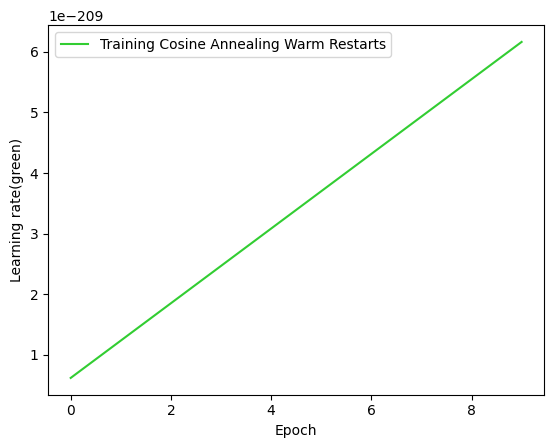

In [11]:
import matplotlib.pyplot as plt
lrs = []
for i in range(10):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()


plt.plot(range(10), lrs, color = 'limegreen',  label = 'Training Cosine Annealing Warm Restarts')
plt.xlabel('Epoch')
plt.ylabel('Learning rate(green)')
plt.legend()
plt.show()

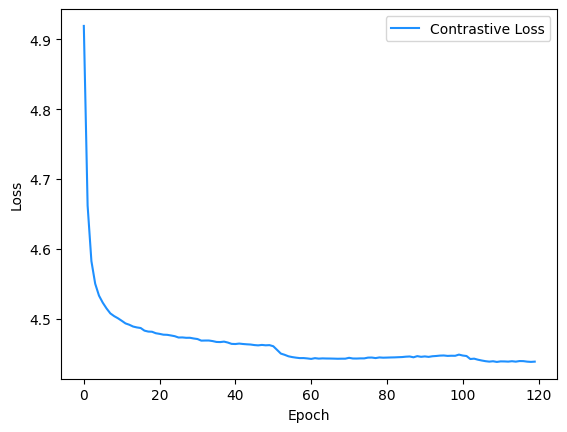

In [26]:
plt.plot(range(120),results_loss['epoch_by_trn'], color = 'dodgerblue', label = 'Contrastive Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
torch.save({"model_state_dict": model.state_dict(),
            },
           f"Contrastive_Embedding_Net(1117AE).pt")

In [54]:
print(model)

Contrastive_Embedding(
  (encoder): Sequential(
    (0): Linear(in_features=222, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.56, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.56, inplace=False)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.56, inplace=False)
    (11): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.56, inplace=False)
    (3): LeakyReLU(negative_slope=0.

In [18]:
emb_df = make_embeded_df(model)


Start Getting the latent space vector(Train, Valid sample)
818286

End, Time consume(min):0.09841051896413168


In [20]:
sample = pd.concat([dataset[['subject_id', 'stay_id', 'hadm_id']].reset_index(drop=True), emb_df.reset_index(drop=True)], axis = 1, ignore_index=True)
sample = sample.rename(columns = {0: 'subject_id', 1:'stay_id', 2:'hadm_id'})
sample

,subject_id,stay_id,hadm_id,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184
0,15332791,30003598,20683754,-0.001014,-0.009162,-0.009464,-0.001002,-0.000988,-0.009106,-0.009416,-0.009061,-0.009510,-0.000999,-0.001019,-0.009394,-0.009065,-0.000993,-0.009465,-0.009292,-0.009414,-0.009063,-0.001027,-0.009478,-0.009288,-0.009373,-0.001029,-0.009483,-0.008518,-0.009234,-0.009363,-0.009054,-0.009238,-0.001008,-0.009250,-0.009453,-0.009230,-0.009493,-0.009371,-0.009301,-0.009320,-0.001029,-0.009140,-0.001023,-0.001028,-0.009337,-0.009065,-0.009471,-0.009558,-0.009213,-0.009430,-0.009309,-0.009456,-0.009356,-0.009362,-0.001025,-0.001021,-0.001035,-0.009370,-0.009389,-1.033548e-03,-0.009285,-0.009166,-0.009313,-0.009333,-0.009467,-0.008837,-0.009275,-0.008142,-0.009303,-0.009602,-0.009177,-0.009367,-0.007936,-0.009302,-0.009367,-0.009460,-0.001046,-0.001006,-0.001023,-0.009440,-0.009383,-0.009410,-0.001024,-0.009276,-0.009462,-0.009312,-0.009202,-0.009274,-0.009259,-0.009174,-0.009142,-0.009488,-0.009448,-0.009330,-0.001023,-0.008025,-0.009363,-0.000988,-0.001019,-0.009590,-0.009362,-0.009161,-0.009398,-0.008683,-0.001001,-0.009491,-0.009557,-0.009275,-0.009317,-0.009408,-0.001010,-0.001008,-0.009300,-0.009451,-0.009306,-0.009206,-0.001004,-0.009422,-0.001021,-0.001012,-0.009244,-0.001021,-0.001018,-0.009380,-0.001021,-0.009279,-0.009660,-0.001005,-0.009348,-0.001009,-0.009439,-0.001048,-0.009281,-0.001029,-0.009491,-0.009398,-0.009379,-0.009317,-0.001008,-0.009379,-0.001011,-0.000994,-0.008322,-0.009528,-0.009209,-0.009175,-0.001023,-0.009396,-0.009037,-0.001002,-0.009413,-0.001009,-0.009416,-0.009291,-0.009421,-0.009411,-0.009273,-0.009410,-0.009351,-0.009103,-0.001015,-0.009423,-0.001018,-0.009166,-0.009409,-0.009423,-0.009473,-0.001024,-0.009293,-0.009384,-0.001020,-0.009617,-0.009393,-0.009280,-0.009501,-0.001018,-0.001024,-0.009511,-0.009249,-0.009229,-0.009345,-0.009345,-0.001010,-0.001001,1
1,15332791,30003598,20683754,-0.001003,-0.007288,-0.007451,-0.000990,-0.000978,-0.007154,-0.007484,-0.007209,-0.007576,-0.000989,-0.001007,-0.007447,-0.007117,-0.000982,-0.007538,-0.007402,-0.007486,-0.007225,-0.001018,-0.007545,-0.007335,-0.007459,-0.001019,-0.007549,-0.006784,-0.007350,-0.007437,-0.007102,-0.007348,-0.000998,-0.007353,-0.007526,-0.007352,-0.007554,-0.007345,-0.007303,-0.007397,-0.001018,-0.007278,-0.001013,-0.001017,-0.007417,-0.007215,-0.007545,-0.007584,-0.007325,-0.007496,-0.007334,-0.007505,-0.007454,-0.007461,-0.001013,-0.001012,-0.001024,-0.007456,-0.007464,-1.024011e-03,-0.007380,-0.007281,-0.007422,-0.007356,-0.007525,-0.006911,-0.007310,-0.006353,-0.007400,-0.007627,-0.007290,-0.007451,-0.006227,-0.007362,-0.007451,-0.007529,-0.001035,-0.000995,-0.001014,-0.007501,-0.007395,-0.007488,-0.001014,-0.007338,-0.007538,-0.007412,-0.007328,-0.007379,-0.007363,-0.007286,-0.007254,-0.007497,-0.007525,-0.007428,-0.001013,-0.006308,-0.007450,-0.000977,-0.001007,-0.007611,-0.007436,-0.007283,-0.007480,-0.006836,-0.000990,-0.007506,-0.007531,-0.007374,-0.007347,-0.007466,-0.001000,-0.000998,-0.007390,-0.007505,-0.007408,-0.007319,-0.000994,-0.007464,-0.001010,-0.001001,-0.007288,-0.001009,-0.001007,-0.007459,-0.001010,-0.007384,-0.007669,-0.000995,-0.007356,-0.000998,-0.007506,-0.001037,-0.007388,-0.001018,-0.007477,-0.007395,-0.007461,-0.007384,-0.000997,-0.007403,-0.001001,-0.000982,-0.006583,-0.007574,-0.007276,-0.007202,-0.001013,-0.007479,-0.007162,-0.000990,

In [22]:
sample.to_csv('embedding_data.csv')